In [12]:
# Install required packages for Python 3.11
%pip install numpy pandas matplotlib nltk scikit-learn

# Import pickle (built-in module)
import pickle

import missingno as msno

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sessions = np.arange(25, 76)
data = []

for session in sessions:
    directory = "./TXT/Session " + str(session) + " - " + str(1945 + session)
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist. Skipping session {session}.")
        continue
    for filename in os.listdir(directory):
        if filename[0] == ".":  # ignore hidden files
            continue
        try:
            with open(os.path.join(directory, filename), encoding='utf-8') as f:
                splt = filename.split("_")
                data.append([session, 1945 + session, splt[0], f.read()])
        except UnicodeDecodeError as e:
            print(f"Encoding error in file {filename}: {e}. Skipping.")
        except Exception as e:
            print(f"Error reading file {filename}: {e}. Skipping.")

df_speech = pd.DataFrame(data, columns=['Session', 'Year', 'ISO-alpha3 Code', 'Speech'])

df_speech.tail()

,Session,Year,ISO-alpha3 Code,Speech
8476,75,2020,WSM,"Mr. President,\nDistinguished delegates,\nLadi..."
8477,75,2020,YEM,In the name of God the Merciful and the Compas...
8478,75,2020,ZAF,"President of the General Assembly, Secretary-G..."
8479,75,2020,ZMB,"Your excellency Mr. Volkan Bozkir, President o..."
8480,75,2020,ZWE,"Your Excellency, Ambassador Volkan Bozkir, Pre..."


In [14]:
df_codes = pd.read_csv('UNSD_Methodology.csv', sep=';')
df_codes.head()

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Algeria,12,DZ,DZA,NaN,NaN,NaN
1,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Egypt,818,EG,EGY,NaN,NaN,NaN
2,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Libya,434,LY,LBY,NaN,NaN,NaN
3,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Morocco,504,MA,MAR,NaN,NaN,NaN
4,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Sudan,729,SD,SDN,x,NaN,NaN


In [15]:
df_un_merged = pd.merge(df_speech, df_codes, on='ISO-alpha3 Code', how='left')
df_un_merged = df_un_merged[["Country or Area", "Region Name","Sub-region Name", "ISO-alpha3 Code","Least Developed Countries (LDC)", "Session", "Year", "Speech"]]
df_un_merged.set_index(['Year', 'ISO-alpha3 Code'], inplace=True)
df_un_merged.head()

Country or Area Region Name  \
Year ISO-alpha3 Code                               
1970 ALB                     Albania      Europe   
     ARG                   Argentina    Americas   
     AUS                   Australia     Oceania   
     AUT                     Austria      Europe   
     BEL                     Belgium      Europe   

                                      Sub-region Name  \
Year ISO-alpha3 Code                                    
1970 ALB                              Southern Europe   
     ARG              Latin America and the Caribbean   
     AUS                    Australia and New Zealand   
     AUT                               Western Europe   
     BEL                               Western Europe   

                     Least Developed Countries (LDC)  Session  \
Year ISO-alpha3 Code                                            
1970 ALB                                         NaN       25   
     ARG                                         NaN       25   
     AUS                                         NaN       25   
     AUT                                         NaN       25   
     BEL                                         NaN       25   

                                                                 Speech  
Year ISO-alpha3 Code                                                     
1970 ALB              33: May I first convey to our President the co...  
     ARG              177.\t : It is a fortunate coincidence that pr...  
     AUS              100.\t  It is a pleasure for me to extend to y...  
     AUT              155.\t  May I begin by expressing to Ambassado...  
     BEL              176. No doubt each of us, before coming up to ...

## Get other data sources ready, basic EDA

In [192]:
# Import and merge additional datasets
print("Importing additional datasets...")
# Import the datasets
merchandise_exports = pd.read_csv('./numerical-data/merchandise-exports-gdp-cepii/merchandise-exports-gdp-cepii.csv')
income_groups = pd.read_csv('./numerical-data/world-bank-income-groups/world-bank-income-groups.csv')
life_expectancy = pd.read_csv('./numerical-data/life-expectancy/life-expectancy.csv')
income_day = pd.read_csv('./numerical-data/daily-median-income/daily-median-income.csv')
child_mortality = pd.read_csv('./numerical-data/child-mortality/child-mortality.csv')
child_mortality_income = pd.read_csv('./numerical-data/child-mortality-by-income-level-of-country/child-mortality-by-income-level-of-country.csv')

print("Dataset shapes:")
print(f"merchandise_exports: {merchandise_exports.shape}")
print(f"income_groups: {income_groups.shape}")
print(f"life_expectancy: {life_expectancy.shape}")
print(f"income_day: {income_day.shape}")
print(f"child_mortality: {child_mortality.shape}")
print(f"child_mortality_income: {child_mortality_income.shape}")


Importing additional datasets...
Dataset shapes:
merchandise_exports: (13808, 4)
income_groups: (7953, 4)
life_expectancy: (21565, 4)
income_day: (2671, 5)
child_mortality: (16835, 4)
child_mortality_income: (13700, 4)


In [193]:
# Check columns and data structure
datasets = {
    'merchandise_exports': merchandise_exports,
    'income_groups': income_groups,
    'life_expectancy': life_expectancy,
    'income_day': income_day,
    'child_mortality': child_mortality,
    'child_mortality_income': child_mortality_income
}

print("\nDataset columns:")
for name, df in datasets.items():
    print(f"{name}: {list(df.columns)}")

# Create a new merged dataframe starting with the UN merged data
print("\nMerging datasets...")
merged_health_trade_df = df_un_merged.reset_index().copy()

# Merge each dataset one by one
for name, df in datasets.items():
    print(f"\nMerging {name}...")
    print(f"  Before merge: {merged_health_trade_df.shape}")
    
    # Check if the dataset has the required columns (Code and Year)
    if 'Code' in df.columns and 'Year' in df.columns:
        # Remove duplicates first
        df_clean = df.drop_duplicates(['Code', 'Year'], keep='first')
        
        merged_health_trade_df = pd.merge(
            merged_health_trade_df,
            df_clean,
            left_on=['ISO-alpha3 Code', 'Year'],
            right_on=['Code', 'Year'],
            how='left',
            suffixes=('', f'_{name}')
        )
        
        # Drop the duplicate Code column from the right dataframe
        cols_to_drop = [col for col in merged_health_trade_df.columns if col.endswith(f'_{name}') and col.startswith('Code')]
        if cols_to_drop:
            merged_health_trade_df.drop(cols_to_drop, axis=1, inplace=True)
        
        print(f"  After merge: {merged_health_trade_df.shape}")
    else:
        print(f"  Warning: {name} missing required columns 'Code' and/or 'Year'")
        print(f"  Available columns: {list(df.columns)}")

# Set the index back to Year and ISO-alpha3 Code
merged_health_trade_df = merged_health_trade_df.set_index(['Year', 'ISO-alpha3 Code'])

print(f"\nFinal merged dataset shape: {merged_health_trade_df.shape}")
print(f"Columns: {list(merged_health_trade_df.columns)}")

# Show summary statistics
print(f"\nData summary:")
print(f"Unique countries: {merged_health_trade_df.reset_index()['ISO-alpha3 Code'].nunique()}")
print(f"Year range: {merged_health_trade_df.reset_index()['Year'].min()}-{merged_health_trade_df.reset_index()['Year'].max()}")

print("\nHealth and trade data merged successfully!")
print("You can now access all health and trade columns by Year and ISO-alpha3 Code in merged_health_trade_df")



Dataset columns:
merchandise_exports: ['Entity', 'Code', 'Year', 'Value of global merchandise exports as a share of GDP (Fouquin and Hugot; CEPII 2016; National data)']
income_groups: ['Entity', 'Code', 'Year', "World Bank's income classification"]
life_expectancy: ['Entity', 'Code', 'Year', 'Period life expectancy at birth']
income_day: ['Entity', 'Code', 'Year', 'Median (2021 prices) - Income or consumption consolidated', '1103374-annotations']
child_mortality: ['Entity', 'Code', 'Year', 'Child mortality rate']
child_mortality_income: ['Entity', 'Code', 'Year', 'Child mortality rate of children aged under five years, per 100 live births']

Merging datasets...

Merging merchandise_exports...
  Before merge: (8481, 8)
  After merge: (8481, 11)

Merging income_groups...
  Before merge: (8481, 11)
  After merge: (8481, 13)

Merging life_expectancy...
  Before merge: (8481, 13)
  After merge: (8481, 15)

Merging income_day...
  Before merge: (8481, 15)
  After merge: (8481, 18)

Merging 

In [194]:
merged_health_trade_df.head()

Country or Area Region Name  \
Year ISO-alpha3 Code                               
1970 ALB                     Albania      Europe   
     ARG                   Argentina    Americas   
     AUS                   Australia     Oceania   
     AUT                     Austria      Europe   
     BEL                     Belgium      Europe   

                                      Sub-region Name  \
Year ISO-alpha3 Code                                    
1970 ALB                              Southern Europe   
     ARG              Latin America and the Caribbean   
     AUS                    Australia and New Zealand   
     AUT                               Western Europe   
     BEL                               Western Europe   

                     Least Developed Countries (LDC)  Session  \
Year ISO-alpha3 Code                                            
1970 ALB                                         NaN       25   
     ARG                                         NaN       25   
     AUS                                         NaN       25   
     AUT                                         NaN       25   
     BEL                                         NaN       25   

                                                                 Speech  \
Year ISO-alpha3 Code                                                      
1970 ALB              33: May I first convey to our President the co...   
     ARG              177.\t : It is a fortunate coincidence that pr...   
     AUS              100.\t  It is a pleasure for me to extend to y...   
     AUT              155.\t  May I begin by expressing to Ambassado...   
     BEL              176. No doubt each of us, before coming up to ...   

                         Entity Code  \
Year ISO-alpha3 Code                   
1970 ALB                Albania  ALB   
     ARG              Argentina  ARG   
     AUS              Australia  AUS   
     AUT                Austria  AUT   
     BEL                Belgium  BEL   

                      Value of global merchandise exports as a share of GDP (Fouquin and Hugot; CEPII 2016; National data)  \
Year ISO-alpha3 Code                                                                                                         
1970 ALB                                                        2.13133                                                      
     ARG                                                        6.54746                                                      
     AUS                                                       11.65536                                                      
     AUT                                                       18.57593                                                      
     BEL                                                       43.20208                                                      

                     Entity_income_groups World Bank's income classification  \
Year ISO-alpha3 Code                                                           
1970 ALB                              NaN                                NaN   
     ARG                              NaN                                NaN   
     AUS                              NaN                                NaN   
     AUT                              NaN                                NaN   
     BEL                              NaN                                NaN   

                     Entity_life_expectancy  Period life expectancy at birth  \
Year ISO-alpha3 Code                                                           
1970 ALB                            Albania                          65.2343   
     ARG                          Argentina                          65.6474   
     AUS                          Australia                          70.6534   
     AUT                            Austria                          70.0860   
     BEL                            Belgium                          

### Rename for ease of use

In [195]:
# Rename the long column name to a shorter, more readable one
merged_health_trade_df = merged_health_trade_df.rename(columns={
    'Value of global merchandise exports as a share of GDP (Fouquin and Hugot; CEPII 2016; National data)': 'exports_share_GDP'
})

# Rename the child mortality column to a shorter name
merged_health_trade_df = merged_health_trade_df.rename(columns={
    'Child mortality rate of children aged under five years, per 100 live births': 'mortality_under_5'
})

# Rename Entity_income_groups to income_group
merged_health_trade_df = merged_health_trade_df.rename(columns={
    'Entity_income_groups': 'income_group'
})

merged_health_trade_df.head()


Country or Area Region Name  \
Year ISO-alpha3 Code                               
1970 ALB                     Albania      Europe   
     ARG                   Argentina    Americas   
     AUS                   Australia     Oceania   
     AUT                     Austria      Europe   
     BEL                     Belgium      Europe   

                                      Sub-region Name  \
Year ISO-alpha3 Code                                    
1970 ALB                              Southern Europe   
     ARG              Latin America and the Caribbean   
     AUS                    Australia and New Zealand   
     AUT                               Western Europe   
     BEL                               Western Europe   

                     Least Developed Countries (LDC)  Session  \
Year ISO-alpha3 Code                                            
1970 ALB                                         NaN       25   
     ARG                                         NaN       25   
     AUS                                         NaN       25   
     AUT                                         NaN       25   
     BEL                                         NaN       25   

                                                                 Speech  \
Year ISO-alpha3 Code                                                      
1970 ALB              33: May I first convey to our President the co...   
     ARG              177.\t : It is a fortunate coincidence that pr...   
     AUS              100.\t  It is a pleasure for me to extend to y...   
     AUT              155.\t  May I begin by expressing to Ambassado...   
     BEL              176. No doubt each of us, before coming up to ...   

                         Entity Code  exports_share_GDP income_group  \
Year ISO-alpha3 Code                                                   
1970 ALB                Albania  ALB            2.13133          NaN   
     ARG              Argentina  ARG            6.54746          NaN   
     AUS              Australia  AUS           11.65536          NaN   
     AUT                Austria  AUT           18.57593          NaN   
     BEL                Belgium  BEL           43.20208          NaN   

                     World Bank's income classification  \
Year ISO-alpha3 Code                                      
1970 ALB                                            NaN   
     ARG                                            NaN   
     AUS                                            NaN   
     AUT                                            NaN   
     BEL                                            NaN   

                     Entity_life_expectancy  Period life expectancy at birth  \
Year ISO-alpha3 Code                                                           
1970 ALB                            Albania                          65.2343   
     ARG                          Argentina                          65.6474   
     AUS                          Australia                          70.6534   
     AUT                            Austria                          70.0860   
     BEL                            Belgium                          70.9368   

                     Entity_income_day  \
Year ISO-alpha3 Code                     
1970 ALB                           NaN   
     ARG                           NaN   
     AUS                           NaN   
     AUT                           NaN   
     BEL                           NaN   

                      Median (2021 prices) - Income or consumption consolidated  \
Year ISO-alpha3 Code                                                              
1970 ALB                                                            NaN           
     ARG                                                            NaN           
     AUS                                                            NaN           
     AUT                                                            NaN           
 

In [196]:
# Keep only the requested columns (match case-insensitively / normalized)
desired = [
    "country or area", "region name", "sub-region name",
    "session", "speech", "entity", "code",
    "exports_share_GDP", "income_group", "mortality_under_5"
]

available_cols = list(merged_health_trade_df.columns)

# build lookup with normalized names
norm_map = {}
for c in available_cols:
    norm = c.lower().replace('_', ' ').replace('-', ' ').strip()
    norm_map[norm] = c

selected = []
missing = []
for d in desired:
    d_norm = d.lower().replace('_', ' ').replace('-', ' ').strip()
    if d_norm in norm_map:
        selected.append(norm_map[d_norm])
    else:
        # try substring match as a last resort
        matches = [c for c in available_cols if d_norm in c.lower()]
        if matches:
            selected.append(matches[0])
        else:
            missing.append(d)

print("Selected columns (kept):", selected)
if missing:
    print("Warning - could not find these requested columns:", missing)

# Subset the dataframe (overwrite merged_health_trade_df to keep only these)
merged_health_trade_df = merged_health_trade_df[selected].copy()
merged_health_trade_df.head()

Selected columns (kept): ['Country or Area', 'Region Name', 'Sub-region Name', 'Session', 'Speech', 'Entity', 'Code', 'exports_share_GDP', 'income_group', 'mortality_under_5']


Country or Area Region Name  \
Year ISO-alpha3 Code                               
1970 ALB                     Albania      Europe   
     ARG                   Argentina    Americas   
     AUS                   Australia     Oceania   
     AUT                     Austria      Europe   
     BEL                     Belgium      Europe   

                                      Sub-region Name  Session  \
Year ISO-alpha3 Code                                             
1970 ALB                              Southern Europe       25   
     ARG              Latin America and the Caribbean       25   
     AUS                    Australia and New Zealand       25   
     AUT                               Western Europe       25   
     BEL                               Western Europe       25   

                                                                 Speech  \
Year ISO-alpha3 Code                                                      
1970 ALB              33: May I first convey to our President the co...   
     ARG              177.\t : It is a fortunate coincidence that pr...   
     AUS              100.\t  It is a pleasure for me to extend to y...   
     AUT              155.\t  May I begin by expressing to Ambassado...   
     BEL              176. No doubt each of us, before coming up to ...   

                         Entity Code  exports_share_GDP income_group  \
Year ISO-alpha3 Code                                                   
1970 ALB                Albania  ALB            2.13133          NaN   
     ARG              Argentina  ARG            6.54746          NaN   
     AUS              Australia  AUS           11.65536          NaN   
     AUT                Austria  AUT           18.57593          NaN   
     BEL                Belgium  BEL           43.20208          NaN   

                      mortality_under_5  
Year ISO-alpha3 Code                     
1970 ALB                            NaN  
     ARG                       7.170254  
     AUS                       2.146410  
     AUT                       2.905047  
     BEL                       2.392771

## See NaN visually

<Figure size 600x400 with 0 Axes>

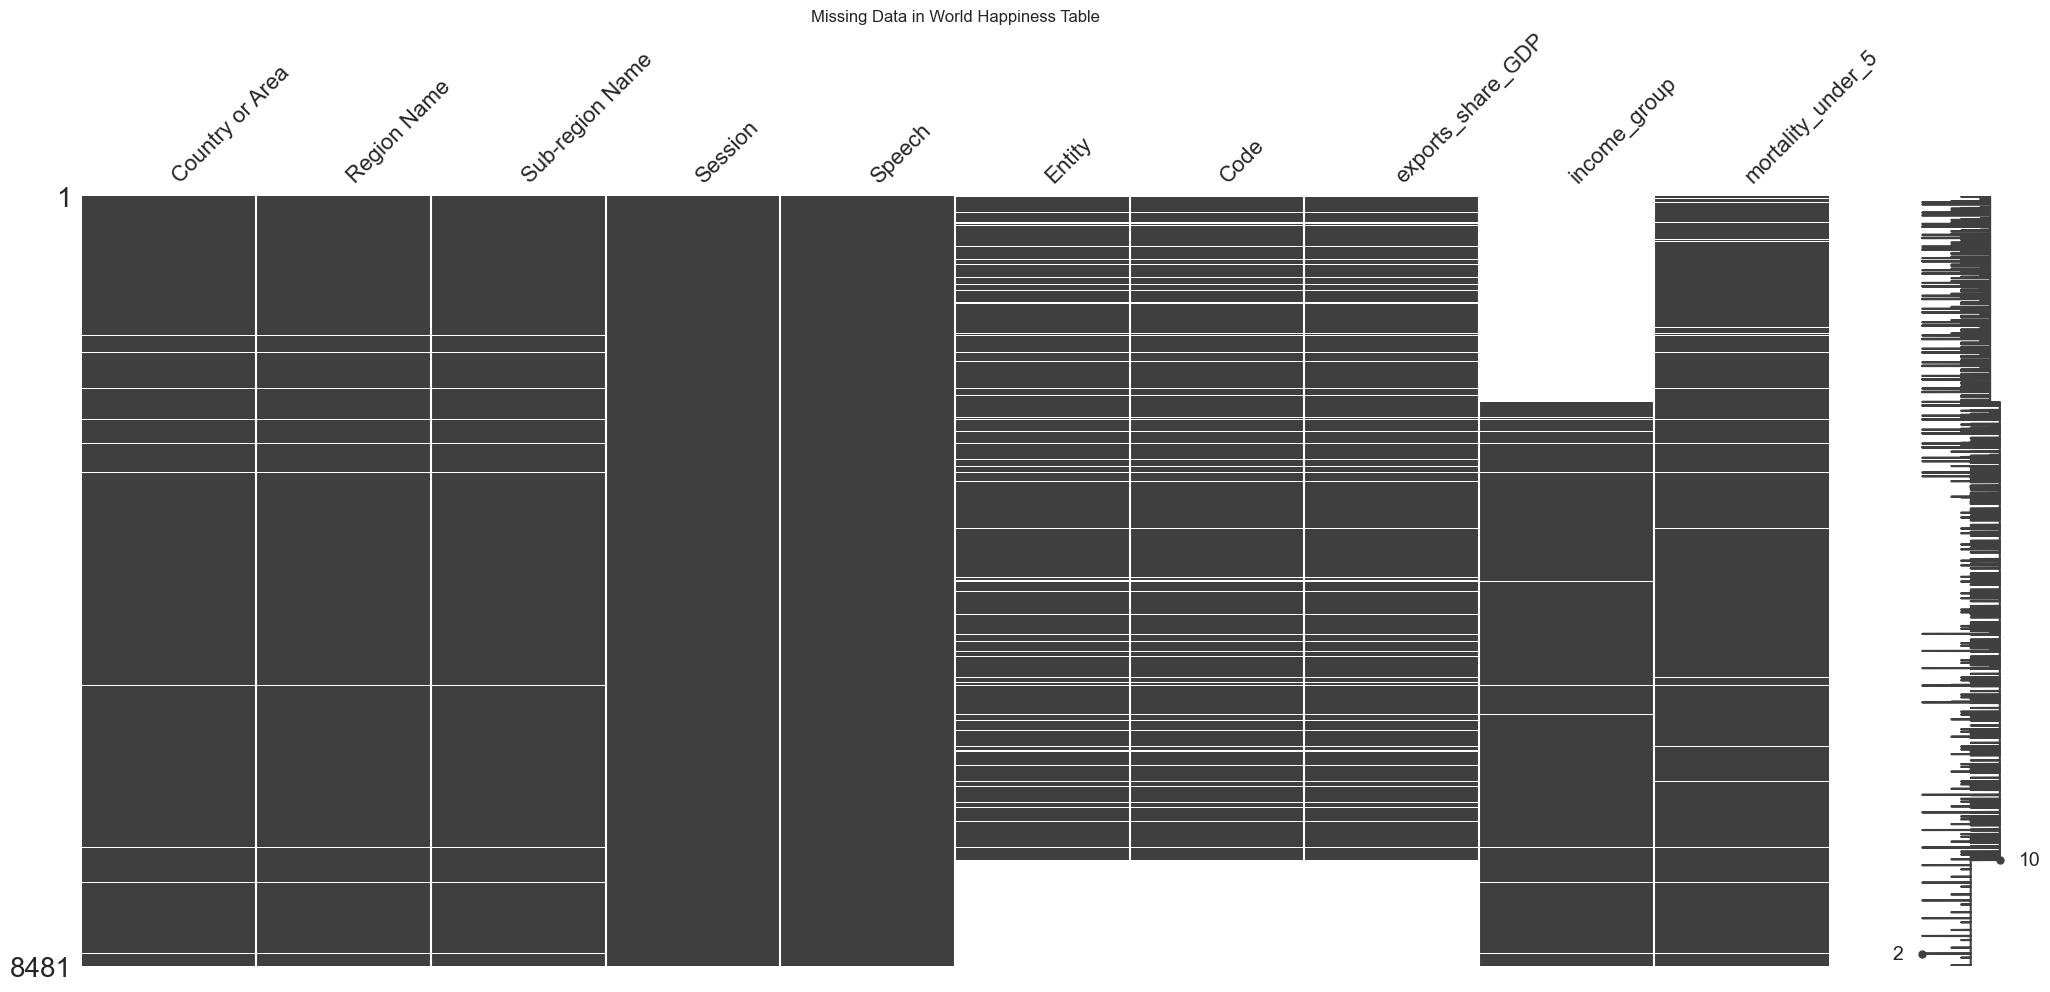

In [197]:
## quality of data
#nan values seem to happen at random make heatmap to make sure
plt.figure(figsize=(6,4))  # make the figure smaller
msno.matrix(merged_health_trade_df)
plt.title("Missing Data in World Happiness Table")
plt.show()



## See data coverage

In [198]:
# Verify income_groups year coverage from merged_health_trade_df (Python kernel)
if "merged_health_trade_df" not in globals():
    raise NameError("merged_health_trade_df is not available; run the earlier merge cell first.")

coverage_df = merged_health_trade_df.reset_index()

if "Year" not in coverage_df.columns:
    raise KeyError("Column 'Year' not found after resetting index.")

income_cols = [
    col for col in coverage_df.columns
    if col.lower() == "income_group" or ("income" in col.lower() and "class" in col.lower())
]
if not income_cols:
    raise KeyError("No income classification column found in merged_health_trade_df.")

income_col = income_cols[0]
year_series = coverage_df.loc[coverage_df[income_col].notna(), "Year"].dropna()

if year_series.empty:
    print("No income group data with year information available.")
else:
    year_series = year_series.astype(int)
    distinct_years = np.sort(year_series.unique())
    print(f"Distinct years covered: {distinct_years[0]}–{distinct_years[-1]}")
    print(f"Total distinct years: {len(distinct_years)}")

    year_summary = (
        year_series.value_counts()
        .sort_index()
        .rename_axis("Year")
        .reset_index(name="Rows with income data")
    )

    display(year_summary)

    full_range = set(range(distinct_years[0], distinct_years[-1] + 1))
    observed_years = set(distinct_years)
    missing_years = sorted(full_range - observed_years)

    if missing_years:
        preview = missing_years[:20]
        suffix = " ..." if len(missing_years) > 20 else ""
        print(f"Missing years within the range: {preview}{suffix}")
    else:
        print("No missing years within the range.")

Distinct years covered: 1987–2020
Total distinct years: 34


,Year,Rows with income data
0,1987,138
1,1988,141
2,1989,142
3,1990,149
4,1991,159
5,1992,165
6,1993,173
7,1994,177
8,1995,171
9,1996,180


No missing years within the range.


In [199]:
## check all countries have income_groups data in the year range 1987–2020
import pandas as pd
import numpy as np

if "merged_health_trade_df" not in globals():
    raise NameError("merged_health_trade_df is not available; run the merge cell above first.")

coverage_df = merged_health_trade_df.reset_index()

required_columns = {"Year", "ISO-alpha3 Code"}
missing_columns = required_columns - set(coverage_df.columns)
if missing_columns:
    raise KeyError(f"Missing required columns: {sorted(missing_columns)}")

income_cols = [
    col for col in coverage_df.columns
    if col.lower() == "income_group" or ("income" in col.lower() and "class" in col.lower())
]
if not income_cols:
    raise KeyError("No income classification column found in merged_health_trade_df.")
income_col = income_cols[0]

year_start, year_end = 1987, 2020
expected_years = list(range(year_start, year_end + 1))

range_df = coverage_df[coverage_df["Year"].between(year_start, year_end)]
range_df = range_df.copy()
range_df["Year"] = range_df["Year"].astype(int)

non_null_income = range_df[range_df[income_col].notna()]

countries = sorted(range_df["ISO-alpha3 Code"].dropna().unique())
missing_details = []

for code in countries:
    observed_years = set(non_null_income.loc[non_null_income["ISO-alpha3 Code"] == code, "Year"])
    missing_years = [year for year in expected_years if year not in observed_years]
    if missing_years:
        missing_details.append({
            "ISO-alpha3 Code": code,
            "Missing Count": len(missing_years),
            "Sample Missing Years": missing_years[:10]
        })

total_countries = len(countries)
complete_countries = total_countries - len(missing_details)

print(f"Year range checked: {year_start}–{year_end}")
print(f"Total countries in range: {total_countries}")
print(f"Countries with full coverage: {complete_countries}")
print(f"Countries missing income data in this range: {len(missing_details)}")

if missing_details:
    missing_df = (
        pd.DataFrame(missing_details)
        .sort_values(["Missing Count", "ISO-alpha3 Code"], ascending=[False, True])
        .reset_index(drop=True)
    )
    print("\nTop countries with gaps (showing up to 20):")
    display(missing_df.head(20))
else:
    print("All countries have income group data for every year in the specified range.")

Year range checked: 1987–2020
Total countries in range: 200
Countries with full coverage: 106
Countries missing income data in this range: 94

Top countries with gaps (showing up to 20):


,ISO-alpha3 Code,Missing Count,Sample Missing Years
0,CSK,34,"[1987, 1988, 1989, 1990, 1991, 1992, 1993, 199..."
1,DDR,34,"[1987, 1988, 1989, 1990, 1991, 1992, 1993, 199..."
2,EU,34,"[1987, 1988, 1989, 1990, 1991, 1992, 1993, 199..."
3,VAT,34,"[1987, 1988, 1989, 1990, 1991, 1992, 1993, 199..."
4,YMD,34,"[1987, 1988, 1989, 1990, 1991, 1992, 1993, 199..."
5,YUG,34,"[1987, 1988, 1989, 1990, 1991, 1992, 1993, 199..."
6,NRU,28,"[1987, 1988, 1989, 1990, 1991, 1992, 1993, 199..."
7,SSD,25,"[1987, 1988, 1989, 1990, 1991, 1992, 1993, 199..."
8,TUV,22,"[1987, 1988, 1989, 1990, 1991, 1992, 1993, 199..."
9,MNE,19,"[1987, 1988, 1989, 1990, 1991, 1992, 1993, 199..."


In [200]:
## make a list of which countries have full income_groups coverage in this year range
import pandas as pd
import numpy as np

if "merged_health_trade_df" not in globals():
    raise NameError("merged_health_trade_df is not available; run the merge cell above first.")

coverage_df = merged_health_trade_df.reset_index()

required_columns = {"Year", "ISO-alpha3 Code"}
missing_columns = required_columns - set(coverage_df.columns)
if missing_columns:
    raise KeyError(f"Missing required columns: {sorted(missing_columns)}")

income_cols = [
    col for col in coverage_df.columns
    if col.lower() == "income_group" or ("income" in col.lower() and "class" in col.lower())
]
if not income_cols:
    raise KeyError("No income classification column found in merged_health_trade_df.")
income_col = income_cols[0]

year_start, year_end = 1987, 2020
total_years = year_end - year_start + 1

range_df = coverage_df[coverage_df["Year"].between(year_start, year_end)].copy()
range_df["Year"] = range_df["Year"].astype(int)

non_null_income = range_df[range_df[income_col].notna()]

years_per_country = (
    non_null_income.groupby("ISO-alpha3 Code")["Year"].nunique()
    .rename("Years_with_income_data")
)

full_codes = years_per_country[years_per_country == total_years].index.tolist()

if not full_codes:
    print("No countries have complete income group coverage for every year in the specified range.")
else:
    metadata_cols = [
        col for col in ["Country or Area", "Entity", "Region Name", "Sub-region Name"]
        if col in coverage_df.columns
    ]

    full_coverage_df = (
        coverage_df[coverage_df["ISO-alpha3 Code"].isin(full_codes)][["ISO-alpha3 Code"] + metadata_cols]
        .drop_duplicates("ISO-alpha3 Code")
        .sort_values("ISO-alpha3 Code")
        .reset_index(drop=True)
    )

    print(f"Countries with full income group coverage from {year_start} to {year_end}: {len(full_codes)}")
    display(full_coverage_df)

    missing_lookup = years_per_country[years_per_country < total_years]
    print("\nSample of countries missing at least one year (top 10 by gaps):")
    gap_preview = (
        missing_lookup
        .sort_values(ascending=False)
        .head(10)
        .rename("Years_with_income_data")
        .reset_index()
    )
    display(gap_preview)

Countries with full income group coverage from 1987 to 2020: 106


,ISO-alpha3 Code,Country or Area,Entity,Region Name,Sub-region Name
0,AFG,Afghanistan,Afghanistan,Asia,Southern Asia
1,ARE,United Arab Emirates,United Arab Emirates,Asia,Western Asia
2,ARG,Argentina,Argentina,Americas,Latin America and the Caribbean
3,AUS,Australia,Australia,Oceania,Australia and New Zealand
4,AUT,Austria,Austria,Europe,Western Europe
...,...,...,...,...,...
101,URY,Uruguay,Uruguay,Americas,Latin America and the Caribbean
102,USA,United States of America,United States,Americas,Northern America
103,VCT,Saint Vincent and the Grenadines,Saint Vincent and the Grenadines,Americas,Latin America and the Caribbean
104,VNM,Viet Nam,Vietnam,Asia,South-eastern Asia



Sample of countries missing at least one year (top 10 by gaps):


,ISO-alpha3 Code,Years_with_income_data
0,AGO,33
1,ATG,33
2,COD,33
3,BWA,33
4,COM,33
5,LBN,33
6,HND,33
7,GNB,33
8,OMN,33
9,SLE,33


# Misc.: 

## See if countries change between income groups often

In [201]:
""" # Check the structure of income data for creating the income group change plot
print("Checking available income data...")
print(f"filtered_data columns: {list(filtered_data.columns)}")

# Check the structure of all_income_data
print(f"\nall_income_data columns: {list(all_income_data.columns)}")
print(f"all_income_data shape: {all_income_data.shape}")

# Sample the income data to understand structure
print(f"\nSample of all_income_data:")
print(all_income_data.head())

# Check unique years in income data
print(f"\nYear range in income data: {all_income_data['Year'].min()} - {all_income_data['Year'].max()}")

# Check which of our 40 countries have income group data
our_countries = set(filtered_data['Entity'].unique())
income_countries = set(all_income_data['Entity'].unique())
matching_countries = our_countries.intersection(income_countries)
print(f"\nOur 40 countries: {len(our_countries)}")
print(f"Countries with income data: {len(matching_countries)}")
print(f"Missing countries: {our_countries - income_countries}") """

' # Check the structure of income data for creating the income group change plot\nprint("Checking available income data...")\nprint(f"filtered_data columns: {list(filtered_data.columns)}")\n\n# Check the structure of all_income_data\nprint(f"\nall_income_data columns: {list(all_income_data.columns)}")\nprint(f"all_income_data shape: {all_income_data.shape}")\n\n# Sample the income data to understand structure\nprint(f"\nSample of all_income_data:")\nprint(all_income_data.head())\n\n# Check unique years in income data\nprint(f"\nYear range in income data: {all_income_data[\'Year\'].min()} - {all_income_data[\'Year\'].max()}")\n\n# Check which of our 40 countries have income group data\nour_countries = set(filtered_data[\'Entity\'].unique())\nincome_countries = set(all_income_data[\'Entity\'].unique())\nmatching_countries = our_countries.intersection(income_countries)\nprint(f"\nOur 40 countries: {len(our_countries)}")\nprint(f"Countries with income data: {len(matching_countries)}")\npri

## seems that already filtered those 107

## plot income group changes for selected countries

In [202]:
""" # Create plot showing income group changes for the selected countries using the merged dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Work with the merged dataset where the index holds the year information
analysis_df = merged_health_trade_df.reset_index().copy()

required_columns = {"Year", "Entity", "income_group"}
missing_required = required_columns - set(analysis_df.columns)
if missing_required:
    raise KeyError(f"Missing required columns in merged_health_trade_df after reset_index(): {sorted(missing_required)}")

analysis_df["Year"] = analysis_df["Year"].astype(int)

# Prefer the 20-country selection from the earlier step if available
if "selected_countries_data" in locals() and selected_countries_data:
    iso_codes = set(selected_countries_data.get("all_countries", []))
    our_countries_list = (
        analysis_df.loc[analysis_df["ISO-alpha3 Code"].isin(iso_codes), "Entity"]
        .dropna()
        .unique()
        .tolist()
    )
else:
    our_countries_list = analysis_df["Entity"].dropna().unique().tolist()

if not our_countries_list:
    raise ValueError("No countries available to plot. Ensure earlier selection steps have run successfully.")

print(f"Creating income group change plot for {len(our_countries_list)} countries")

# Filter income data for our selected countries
income_plot_data = analysis_df[analysis_df['Entity'].isin(our_countries_list)].copy()

print(f"Income data shape for our countries: {income_plot_data.shape}")
print(f"Years available: {income_plot_data['Year'].min()} - {income_plot_data['Year'].max()}")

# Establish an order for income groups
default_income_order = [
    'Low-income countries',
    'Lower-middle-income countries',
    'Upper-middle-income countries',
    'High-income countries'
 ]
available_income_groups = income_plot_data['income_group'].dropna().unique().tolist()
income_groups_order = [group for group in default_income_order if group in available_income_groups]
for group in sorted(available_income_groups):
    if group not in income_groups_order:
        income_groups_order.append(group)

if not income_groups_order:
    raise ValueError("No income group labels found for the selected countries.")

income_numeric_map = {group: i for i, group in enumerate(income_groups_order)}
reverse_map = {i: group for i, group in enumerate(income_groups_order)}

income_plot_data['Income_Numeric'] = income_plot_data['income_group'].map(income_numeric_map)

# Drop rows where the mapping failed
income_plot_data = income_plot_data.dropna(subset=['Income_Numeric'])

# Create a large figure to accommodate all countries
plt.figure(figsize=(16, 12))

# Generate distinct colors for countries
colors = plt.cm.tab20(np.linspace(0, 1, len(our_countries_list)))
country_colors = dict(zip(our_countries_list, colors))

# Plot each country's income group trajectory
for country in our_countries_list:
    country_data = income_plot_data[income_plot_data['Entity'] == country].sort_values('Year')
    if len(country_data) > 0:
        plt.plot(
            country_data['Year'],
            country_data['Income_Numeric'],
            marker='o',
            markersize=4,
            linewidth=2,
            color=country_colors[country],
            label=country,
            alpha=0.8
        )

# Customize the plot
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Income Group', fontsize=14, fontweight='bold')
plt.title(
    f"Income Group Changes Over Time (1987-2024)\nfor {len(our_countries_list)} Selected Countries",
    fontsize=16,
    fontweight='bold',
    pad=20
 )

# Set y-axis ticks and labels
plt.yticks(range(len(income_groups_order)), income_groups_order)
plt.grid(True, alpha=0.3, linestyle='--')

# Set x-axis limits
plt.xlim(analysis_df['Year'].min() - 1, analysis_df['Year'].max() + 1)

# Add legend with smaller font and multiple columns
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=9,
    ncol=2,
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary:")
print(f"Total countries plotted: {len(our_countries_list)}")
print(f"Years covered: {income_plot_data['Year'].min()} - {income_plot_data['Year'].max()}")

# Show countries that changed income groups
print(f"\nCountries with income group changes:")
countries_with_changes = []
for country in our_countries_list:
    country_data = income_plot_data[income_plot_data['Entity'] == country]
    unique_groups = country_data['income_group'].dropna().unique()
    if len(unique_groups) > 1:
        countries_with_changes.append(
            f"{country}: {len(unique_groups)} different groups {list(unique_groups)}"
        )

if countries_with_changes:
    for change in countries_with_changes:
        print(f"  • {change}")
else:
    print("  • None")

print(f"\nTotal countries with income group transitions: {len(countries_with_changes)}")
print(f"Countries that remained stable: {len(our_countries_list) - len(countries_with_changes)}") """

' # Create plot showing income group changes for the selected countries using the merged dataset\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\n\n# Work with the merged dataset where the index holds the year information\nanalysis_df = merged_health_trade_df.reset_index().copy()\n\nrequired_columns = {"Year", "Entity", "income_group"}\nmissing_required = required_columns - set(analysis_df.columns)\nif missing_required:\n    raise KeyError(f"Missing required columns in merged_health_trade_df after reset_index(): {sorted(missing_required)}")\n\nanalysis_df["Year"] = analysis_df["Year"].astype(int)\n\n# Prefer the 20-country selection from the earlier step if available\nif "selected_countries_data" in locals() and selected_countries_data:\n    iso_codes = set(selected_countries_data.get("all_countries", []))\n    our_countries_list = (\n        analysis_df.loc[analysis_df["ISO-alpha3 Code"].isin(iso_codes), "Entity"]\n        .dropna()\n        .unique()\n    

In [203]:
""" # Create plot showing income group changes for the 40 selected countries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the 40 selected countries (excluding NaN entries)
our_countries_list = [c for c in filtered_data['Entity'].unique() if pd.notna(c)]
print(f"Creating income group change plot for {len(our_countries_list)} countries")

# Filter income data for our selected countries
income_plot_data = all_income_data[
    all_income_data['Entity'].isin(our_countries_list)
].copy()

print(f"Income data shape for our countries: {income_plot_data.shape}")
print(f"Years available: {income_plot_data['Year'].min()} - {income_plot_data['Year'].max()}")

# Define numeric mapping for income groups (for y-axis positioning)
income_groups_order = [
    'Low-income countries',
    'Lower-middle-income countries', 
    'Upper-middle-income countries',
    'High-income countries'
]

# Create numeric mapping
income_numeric_map = {group: i for i, group in enumerate(income_groups_order)}
reverse_map = {i: group for i, group in enumerate(income_groups_order)}

# Add numeric values for plotting
income_plot_data['Income_Numeric'] = income_plot_data["World Bank's income classification"].map(income_numeric_map)

# Create a large figure to accommodate all countries
plt.figure(figsize=(16, 12))

# Generate distinct colors for countries
colors = plt.cm.tab20(np.linspace(0, 1, len(our_countries_list)))
country_colors = dict(zip(our_countries_list, colors))

# Plot each country's income group trajectory
for i, country in enumerate(our_countries_list):
    country_data = income_plot_data[income_plot_data['Entity'] == country].sort_values('Year')
    
    if len(country_data) > 0:
        plt.plot(country_data['Year'], country_data['Income_Numeric'], 
                marker='o', markersize=4, linewidth=2, 
                color=country_colors[country], label=country, alpha=0.8)

# Customize the plot
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Income Group', fontsize=14, fontweight='bold')
plt.title('Income Group Changes Over Time (1987-2024)\nfor 40 Selected Countries', 
          fontsize=16, fontweight='bold', pad=20)

# Set y-axis ticks and labels
plt.yticks(range(len(income_groups_order)), income_groups_order)
plt.grid(True, alpha=0.3, linestyle='--')

# Set x-axis limits
plt.xlim(1986, 2025)

# Add legend with smaller font and multiple columns
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
          fontsize=9, ncol=2, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary:")
print(f"Total countries plotted: {len(our_countries_list)}")
print(f"Years covered: {income_plot_data['Year'].min()} - {income_plot_data['Year'].max()}")

# Show countries that changed income groups
print(f"\nCountries with income group changes:")
countries_with_changes = []
for country in our_countries_list:
    country_data = income_plot_data[income_plot_data['Entity'] == country]
    unique_groups = country_data["World Bank's income classification"].nunique()
    if unique_groups > 1:
        groups = country_data["World Bank's income classification"].unique()
        countries_with_changes.append(f"{country}: {unique_groups} different groups {list(groups)}")

for change in countries_with_changes:
    print(f"  • {change}")

print(f"\nTotal countries with income group transitions: {len(countries_with_changes)}")
print(f"Countries that remained stable: {len(our_countries_list) - len(countries_with_changes)}") """

' # Create plot showing income group changes for the 40 selected countries\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\n\n# Get the 40 selected countries (excluding NaN entries)\nour_countries_list = [c for c in filtered_data[\'Entity\'].unique() if pd.notna(c)]\nprint(f"Creating income group change plot for {len(our_countries_list)} countries")\n\n# Filter income data for our selected countries\nincome_plot_data = all_income_data[\n    all_income_data[\'Entity\'].isin(our_countries_list)\n].copy()\n\nprint(f"Income data shape for our countries: {income_plot_data.shape}")\nprint(f"Years available: {income_plot_data[\'Year\'].min()} - {income_plot_data[\'Year\'].max()}")\n\n# Define numeric mapping for income groups (for y-axis positioning)\nincome_groups_order = [\n    \'Low-income countries\',\n    \'Lower-middle-income countries\', \n    \'Upper-middle-income countries\',\n    \'High-income countries\'\n]\n\n# Create numeric mapping\nincome_numeric_map

# EDA

Years covered in analysis: 1987–2020
Income groups included: ['Low-income countries', 'Lower-middle-income countries', 'Upper-middle-income countries', 'High-income countries']


,Year,World Bank's income classification,mean,median,observations
0,1987,High-income countries,1.393151,1.060277,29
1,1987,Low-income countries,16.558406,16.918472,47
2,1987,Lower-middle-income countries,6.315892,5.749307,41
3,1987,Upper-middle-income countries,3.899927,3.385468,21
4,1988,High-income countries,1.324096,1.018414,29


World Bank's income classification,Low-income countries,Lower-middle-income countries,Upper-middle-income countries,High-income countries
Year,,,,
1987,16.558406,6.315892,3.899927,1.393151
1988,16.631288,6.327138,3.678378,1.324096
1989,15.640932,6.256906,3.855655,1.282344
1990,15.414309,5.712685,3.420512,1.054777
1991,14.168213,5.506949,2.836208,1.004820


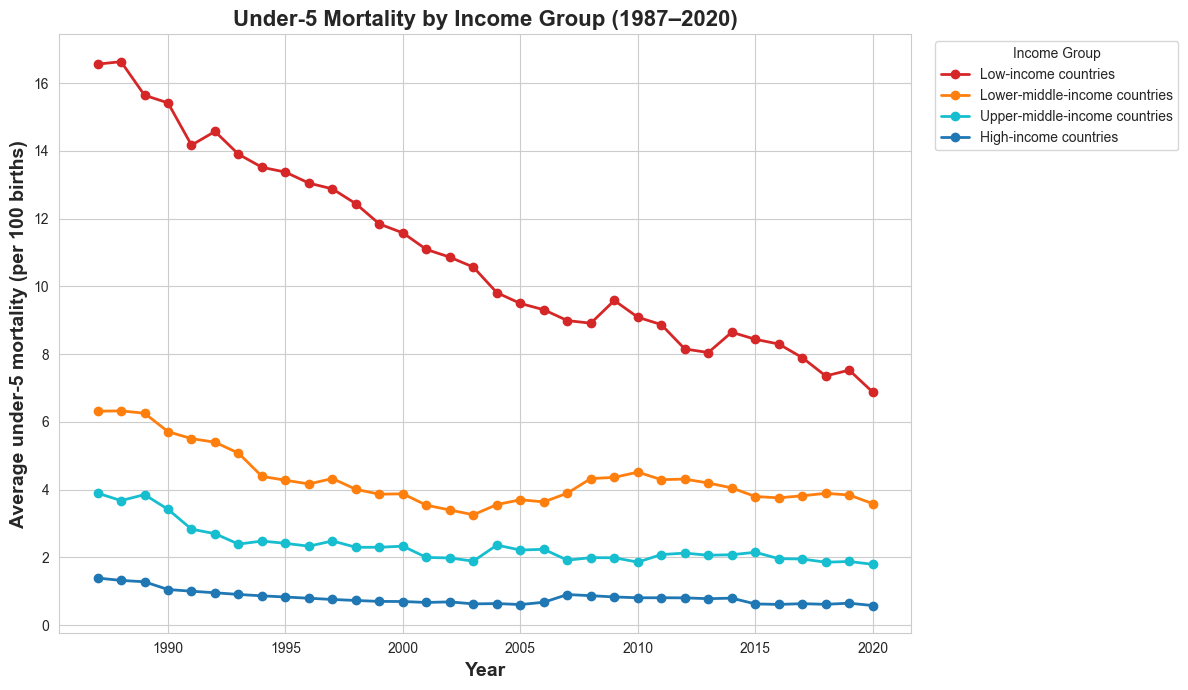


Summary statistics by income group:
  Low-income countries: mean=10.98, median=9.72, observations=1592
  Lower-middle-income countries: mean=4.33, median=3.29, observations=1770
  Upper-middle-income countries: mean=2.35, median=1.76, observations=1287
  High-income countries: mean=0.81, median=0.53, observations=1420


C:\Users\mariu\AppData\Local\Temp\ipykernel_25676\1917067467.py:102: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [204]:
# Mortality time series per income_group (1987–2020)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

analysis_df = merged_health_trade_df.reset_index().copy()

classification_col = "World Bank's income classification"
if "income_groups" in globals() and isinstance(income_groups, pd.DataFrame):
    classification_source = income_groups.copy()
else:
    classification_source = pd.read_csv('./numerical-data/world-bank-income-groups/world-bank-income-groups.csv')

classification_lookup = (
    classification_source[["Code", "Year", classification_col]]
    .drop_duplicates(["Code", "Year"])
    .rename(columns={"Code": "ISO-alpha3 Code"})
)

required_cols = {"Year", "ISO-alpha3 Code", "mortality_under_5"}
missing_cols = required_cols - set(analysis_df.columns)
if missing_cols:
    raise KeyError(f"Missing required columns for mortality analysis: {sorted(missing_cols)}")

analysis_df["Year"] = analysis_df["Year"].astype(int, errors="ignore")
analysis_df["mortality_under_5"] = pd.to_numeric(analysis_df["mortality_under_5"], errors="coerce")

mortality_df = analysis_df.merge(
    classification_lookup,
    on=["ISO-alpha3 Code", "Year"],
    how="left"
)

year_start, year_end = 1987, 2020
mortality_df = mortality_df[(mortality_df["Year"].between(year_start, year_end)) &
                           (mortality_df[classification_col].notna()) &
                           (mortality_df["mortality_under_5"].notna())].copy()

if mortality_df.empty:
    raise ValueError("No mortality data available with income groups in the specified year range.")

mortality_df[classification_col] = mortality_df[classification_col].str.strip()

grouped_stats = (
    mortality_df
    .groupby(["Year", classification_col])["mortality_under_5"]
    .agg(mean="mean", median="median", observations="count")
    .reset_index()
    .sort_values(["Year", classification_col])
)

pivot_mean = grouped_stats.pivot(index="Year", columns=classification_col, values="mean")
pivot_mean = pivot_mean.sort_index()

desired_order = [
    "Low-income countries",
    "Lower-middle-income countries",
    "Upper-middle-income countries",
    "High-income countries"
 ]
available_order = [group for group in desired_order if group in pivot_mean.columns]
pivot_mean = pivot_mean[available_order]
grouped_stats[classification_col] = pd.Categorical(
    grouped_stats[classification_col],
    categories=available_order,
    ordered=True
)

print(f"Years covered in analysis: {pivot_mean.index.min()}–{pivot_mean.index.max()}")
print(f"Income groups included: {list(pivot_mean.columns)}")
display(grouped_stats.head())
display(pivot_mean.head())

color_map = {
    "Low-income countries": "#d62728",  # red
    "Lower-middle-income countries": "#ff7f0e",  # orange
    "Upper-middle-income countries": "#17becf",  # light blue
    "High-income countries": "#1f77b4"  # blue
}

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
for income_group in available_order:
    plt.plot(
        pivot_mean.index,
        pivot_mean[income_group],
        marker="o",
        linewidth=2,
        label=income_group,
        color=color_map.get(income_group, None)
    )

plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Average under-5 mortality (per 100 births)", fontsize=14, fontweight="bold")
plt.title("Under-5 Mortality by Income Group (1987–2020)", fontsize=16, fontweight="bold")
plt.legend(title="Income Group", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

print("\nSummary statistics by income group:")
for income_group, stats in grouped_stats.groupby(classification_col):
    print(
        f"  {income_group}: mean={stats['mean'].mean():.2f}, "
        f"median={stats['median'].median():.2f}, observations={int(stats['observations'].sum())}"
    )

## discuss why different than Our world in data vis: graphs/child-mortality-rate-per-4-group

## REDO: basic EDA for data quality - take 10 countries per income group

* not using main dataframe. code for 1995 not needed.
* and filtering not random anymore

In [205]:
""" # Step 1: Select first 10 alphabetical countries from each income group using 1995 World Bank classification

print("Using World Bank income classification from 1995...")

# Use the income_groups dataset and filter for 1995 data (reload if needed)
if isinstance(income_groups, np.ndarray):
    print("Reloading income groups data...")
    income_groups_temp = pd.read_csv('./numerical-data/world-bank-income-groups/world-bank-income-groups.csv')
else:
    income_groups_temp = income_groups

income_1995 = income_groups_temp[income_groups_temp['Year'] == 1995].copy()
print(f"Income groups data for 1995: {income_1995.shape[0]} countries")

# Check the column name for income classification
income_col_name = "World Bank's income classification"
if income_col_name not in income_1995.columns:
    print("Available columns in income_groups:", list(income_1995.columns))
    # Try alternative column names
    alt_names = [col for col in income_1995.columns if 'income' in col.lower() or 'classification' in col.lower()]
    if alt_names:
        income_col_name = alt_names[0]
        print(f"Using alternative column: {income_col_name}")
    else:
        print("No income classification column found!")
        income_col_name = None

if income_col_name and not income_1995.empty:
    # Get unique income groups from 1995
    unique_income_groups = income_1995[income_col_name].dropna().unique()
    print(f"Income groups in 1995: {unique_income_groups}")
    
    # Select first 10 alphabetical countries from each income group
    selected_countries_by_group = {}
    
    for group in unique_income_groups:
        # Get countries in this income group for 1995
        group_data = income_1995[income_1995[income_col_name] == group]
        group_countries = group_data['Code'].dropna().unique()
        
        # Remove any empty strings or invalid country codes
        group_countries = [country for country in group_countries if country and len(str(country)) == 3]
        
        # Sort alphabetically and take first 10 only
        selected_countries = sorted(group_countries)[:10]
        selected_countries_by_group[group] = selected_countries
        
        print(f"\n{group}: {len(selected_countries)} countries selected (out of {len(group_countries)} total)")
        print(f"Selected countries: {selected_countries}")
    
    # Create a flat list of all selected countries (should be ~40 total, 10 per group)
    all_selected_countries = []
    for countries in selected_countries_by_group.values():
        all_selected_countries.extend(countries)
    
    # Remove any duplicates that might appear across groups
    all_selected_countries = list(set(all_selected_countries))
    
    print(f"\nTotal unique selected countries: {len(all_selected_countries)}")
    print(f"Expected: ~{len(unique_income_groups) * 10} countries (10 per income group)")
    
    # Debug: Show breakdown by group
    for group, countries in selected_countries_by_group.items():
        print(f"{group}: {len(countries)} countries")
    
    # Now filter the merged_health_trade_df for these selected countries
    analysis_df = merged_health_trade_df.reset_index()
    
    # Filter data for selected countries and years 1970-2020
    filtered_data = analysis_df[
        (analysis_df['ISO-alpha3 Code'].isin(all_selected_countries)) &
        (analysis_df['Year'] >= 1970) &
        (analysis_df['Year'] <= 2020)
    ].copy()
    
    # Add 1995 income group info to filtered data
    income_mapping = income_1995[['Code', income_col_name]].set_index('Code')[income_col_name].to_dict()
    filtered_data['Income_Group_1995'] = filtered_data['ISO-alpha3 Code'].map(income_mapping)
    
    # Retain only the specified columns
    columns_to_retain = [
        'Region Name', 'Session', 'Speech', 'Entity', 'Code', 
        'exports_share_GDP', 'income_group', 'mortality_under_5',
        'ISO-alpha3 Code', 'Year', 'Income_Group_1995'  # Keep these for analysis
    ]
    
    # Check which columns actually exist in the data
    available_columns = [col for col in columns_to_retain if col in filtered_data.columns]
    missing_columns = [col for col in columns_to_retain if col not in filtered_data.columns]
    
    print(f"\nColumns to retain: {columns_to_retain}")
    print(f"Available columns: {available_columns}")
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
    
    # Filter to keep only the specified columns
    filtered_data = filtered_data[available_columns].copy()
    
    print(f"\nFiltered data shape after column selection: {filtered_data.shape}")
    print(f"Retained columns: {list(filtered_data.columns)}")
    print(f"Unique countries in filtered data: {filtered_data['ISO-alpha3 Code'].nunique()}")
    
    # Verify we have the right countries
    actual_countries = sorted(filtered_data['ISO-alpha3 Code'].unique())
    print(f"Countries in filtered data: {actual_countries}")
    
    # Calculate statistics for each income group on the retained numeric columns
    numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns
    numeric_columns = [col for col in numeric_columns if col not in ['Year', 'Session']]
    
    print(f"\nCalculating statistics for {len(numeric_columns)} numeric columns: {list(numeric_columns)}")
    
    # Group by 1995 income group and calculate statistics
    income_group_stats = {}
    
    for group in unique_income_groups:
        group_data = filtered_data[filtered_data['Income_Group_1995'] == group]
        
        if len(group_data) > 0:
            if len(numeric_columns) > 0:
                group_stats = group_data[numeric_columns].describe()
                income_group_stats[group] = group_stats
            
            print(f"\n{group} - Statistics Summary:")
            print(f"Countries: {len(group_data['ISO-alpha3 Code'].unique())}")
            print(f"Total observations: {len(group_data)}")
            print(f"Year range: {group_data['Year'].min()}-{group_data['Year'].max()}")
            
            # Show key statistics for the retained columns
            key_columns = ['exports_share_GDP', 'mortality_under_5']
            available_key_cols = [col for col in key_columns if col in numeric_columns]
            
            if available_key_cols and len(numeric_columns) > 0:
                print(f"Key indicators (mean ± std):")
                for col in available_key_cols:
                    if col in group_stats.columns:
                        mean_val = group_stats.loc['mean', col]
                        std_val = group_stats.loc['std', col]
                        print(f"  {col}: {mean_val:.2f} ± {std_val:.2f}")
    
    # Store results for next cell
    selected_countries_data = {
        'countries_by_group': selected_countries_by_group,
        'all_countries': all_selected_countries,
        'filtered_data': filtered_data,
        'stats_by_group': income_group_stats,
        'income_col': 'Income_Group_1995',
        'reference_year': 1995
    }
    
    print(f"\nData prepared for visualization. Selected {len(all_selected_countries)} countries across {len(unique_income_groups)} income groups based on 1995 World Bank classification.")
    
else:
    print("Could not find income groups data for 1995 or income classification column.")
    selected_countries_data = None """

' # Step 1: Select first 10 alphabetical countries from each income group using 1995 World Bank classification\n\nprint("Using World Bank income classification from 1995...")\n\n# Use the income_groups dataset and filter for 1995 data (reload if needed)\nif isinstance(income_groups, np.ndarray):\n    print("Reloading income groups data...")\n    income_groups_temp = pd.read_csv(\'./numerical-data/world-bank-income-groups/world-bank-income-groups.csv\')\nelse:\n    income_groups_temp = income_groups\n\nincome_1995 = income_groups_temp[income_groups_temp[\'Year\'] == 1995].copy()\nprint(f"Income groups data for 1995: {income_1995.shape[0]} countries")\n\n# Check the column name for income classification\nincome_col_name = "World Bank\'s income classification"\nif income_col_name not in income_1995.columns:\n    print("Available columns in income_groups:", list(income_1995.columns))\n    # Try alternative column names\n    alt_names = [col for col in income_1995.columns if \'income\' in c

In [206]:
""" filtered_data.head() """

' filtered_data.head() '

In [207]:
""" # Step 2: Create 2D plot of income groups (1970-2020)
# Using child mortality rate for children under 5 and global merchandise value

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check if we have the selected countries data from Step 1
if 'selected_countries_data' in locals() and selected_countries_data is not None:
    filtered_data = selected_countries_data['filtered_data']
    
    # Check available columns related to child mortality and merchandise
    print("Available columns in the dataset:")
    mortality_cols = [col for col in filtered_data.columns if 'mortality' in col.lower() or 'child' in col.lower()]
    merchandise_cols = [col for col in filtered_data.columns if 'merchandise' in col.lower() or 'export' in col.lower() or 'trade' in col.lower()]
    
    print(f"\nMortality-related columns: {mortality_cols}")
    print(f"Merchandise/Trade-related columns: {merchandise_cols}")
    
    # Select the appropriate columns
    mortality_col = None
    merchandise_col = None
    
    # Find child mortality column
    for col in mortality_cols:
        if 'child' in col.lower() and ('under' in col.lower() or '5' in col.lower() or 'mortality' in col.lower()):
            mortality_col = col
            break
    
    if not mortality_col and mortality_cols:
        mortality_col = mortality_cols[0]  # Use first available mortality column
    
    # Find merchandise exports column
    for col in merchandise_cols:
        if 'merchandise' in col.lower() and ('export' in col.lower() or 'value' in col.lower()):
            merchandise_col = col
            break
    
    if not merchandise_col and merchandise_cols:
        merchandise_col = merchandise_cols[0]  # Use first available merchandise column
    
    print(f"\nSelected columns:")
    print(f"Mortality column: {mortality_col}")
    print(f"Merchandise column: {merchandise_col}")
    
    if mortality_col and merchandise_col:
        # Create the plot data
        plot_data = filtered_data[
            (filtered_data[mortality_col].notna()) & 
            (filtered_data[merchandise_col].notna())
        ].copy()
        
        print(f"\nPlot data shape: {plot_data.shape}")
        print(f"Years range: {plot_data['Year'].min()}-{plot_data['Year'].max()}")
        print(f"Income groups: {plot_data['Income_Group_1995'].unique()}")
        
    else:
        print("Could not find appropriate columns for plotting.")
        plot_data = None
        
else:
    print("Selected countries data not available. Please run Step 1 first.")
    plot_data = None """

' # Step 2: Create 2D plot of income groups (1970-2020)\n# Using child mortality rate for children under 5 and global merchandise value\n\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\n\n# Check if we have the selected countries data from Step 1\nif \'selected_countries_data\' in locals() and selected_countries_data is not None:\n    filtered_data = selected_countries_data[\'filtered_data\']\n    \n    # Check available columns related to child mortality and merchandise\n    print("Available columns in the dataset:")\n    mortality_cols = [col for col in filtered_data.columns if \'mortality\' in col.lower() or \'child\' in col.lower()]\n    merchandise_cols = [col for col in filtered_data.columns if \'merchandise\' in col.lower() or \'export\' in col.lower() or \'trade\' in col.lower()]\n    \n    print(f"\nMortality-related columns: {mortality_cols}")\n    print(f"Merchandise/Trade-related columns: {merchandise_cols}")\n    \n    # Select the appropriate 

## Text analysis

## NLTK from assignment

In [208]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

KeyboardInterrupt: 

In [ ]:
from nltk.probability import FreqDist
from nltk import word_tokenize

# load text of Austria in 1970
text = df_un_merged.loc[1970,'AUT']["Speech"]

# tokenize words
words = word_tokenize(text)

# compute word frequency
freq = FreqDist(words)

# show 30 most frequent words
freq.most_common(30)

[('the', 383),
 ('of', 268),
 (',', 180),
 ('to', 163),
 ('.', 160),
 ('and', 116),
 ('in', 104),
 ('a', 91),
 ('that', 55),
 ('by', 39),
 ('this', 39),
 ('for', 39),
 ('which', 38),
 ('be', 35),
 ('on', 34),
 ('is', 32),
 ('United', 30),
 ('The', 29),
 ('Nations', 28),
 ('as', 27),
 ('Austria', 26),
 ('our', 23),
 ('with', 23),
 ('I', 22),
 ('international', 22),
 ('it', 22),
 ('has', 21),
 ('States', 21),
 ('all', 20),
 ('its', 20)]

<Axes: xlabel='Samples', ylabel='Counts'>

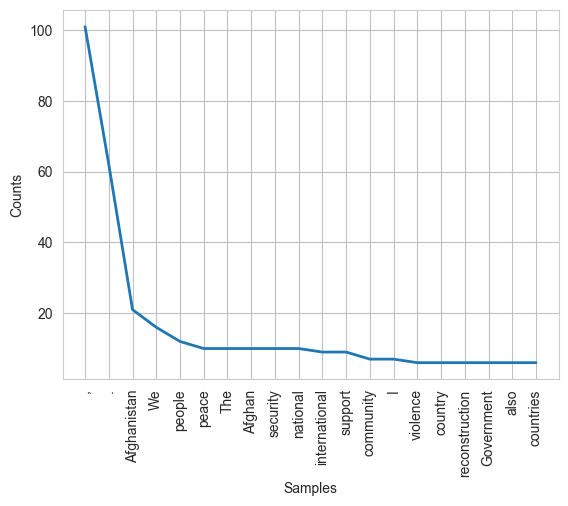

In [ ]:
from nltk.corpus import stopwords

def preprocess(words):
    sw = stopwords.words("english")
    no_sw = []
    for w in words:
        if (w not in sw):
            no_sw.append(w)
    return no_sw

text = df_un_merged.loc[2002,"AFG"]["Speech"]

words = word_tokenize(text)
words = preprocess(words)
freq = FreqDist(words)

freq.plot(20)

<Axes: xlabel='Samples', ylabel='Counts'>

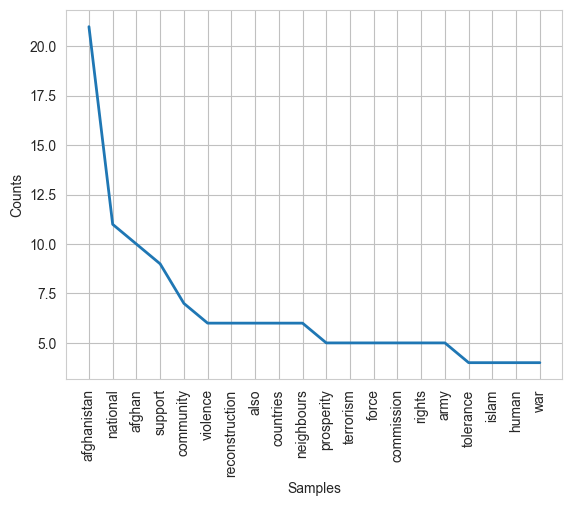

In [ ]:
from nltk.corpus import stopwords

def preprocess(words):
    sw = stopwords.words("english")
    # Add additional non-informative words
    sw.extend(["united", "nations", "international", "organization", "assembly", "general", "delegation", "government", "people", "country", "world", "peace", "security", "development", "cooperation", "resolution", "committee", "secretary", "president", "ambassador", "excellency", "mr", "mrs", "ms", "sir", "madam"])
    no_sw = []
    for w in words:
        w = w.lower()  # Convert to lowercase
        if w.isalpha() and w not in sw:  # Remove punctuation and non-informative words
            no_sw.append(w)
    return no_sw

text = df_un_merged.loc[2002,"AFG"]["Speech"]
words = word_tokenize(text)
words = preprocess(words)
freq = FreqDist(words)
freq.plot(20)

## Topic Analysis: 5 Random Countries Over 20 Years

Let's analyze speech topics for 5 randomly selected countries over the last 20 years (2004-2024), sampling every 4 years. We'll use topic modeling to identify key themes in their speeches.

In [ ]:
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define the years we want to analyze (every 4 years for the last 20 years)
analysis_years = [2004, 2008, 2012, 2016, 2020]

# Get all available countries in our dataset
available_countries = df_un_merged.index.get_level_values('ISO-alpha3 Code').unique()
print(f"Total countries available: {len(available_countries)}")

# Select 5 random countries
selected_countries = random.sample(list(available_countries), 5)
print(f"Selected countries: {selected_countries}")

# Get country names for the selected countries
country_names = {}
for country in selected_countries:
    try:
        country_name = df_un_merged.loc[(df_un_merged.index.get_level_values('ISO-alpha3 Code') == country), 'Country or Area'].iloc[0]
        country_names[country] = country_name
    except:
        country_names[country] = country
        
print("Country names:")
for code, name in country_names.items():
    print(f"  {code}: {name}")

Total countries available: 200
Selected countries: ['FSM', 'IRQ', 'BOL', 'PSE', 'AFG']
Country names:
  FSM: Micronesia (Federated States of)
  IRQ: Iraq
  BOL: Bolivia (Plurinational State of)
  PSE: State of Palestine
  AFG: Afghanistan


In [ ]:
# Collect speeches for selected countries and years
speeches_data = []
speech_texts = []

for country in selected_countries:
    for year in analysis_years:
        try:
            speech = df_un_merged.loc[(year, country), 'Speech']
            speeches_data.append({
                'country': country,
                'country_name': country_names[country],
                'year': year,
                'speech': speech
            })
            speech_texts.append(speech)
            print(f"Found speech for {country} ({country_names[country]}) in {year}")
        except KeyError:
            print(f"No speech found for {country} ({country_names[country]}) in {year}")

print(f"\nTotal speeches collected: {len(speeches_data)}")

# Display the data structure
import pandas as pd
speeches_df = pd.DataFrame(speeches_data)
print("\nSpeeches summary:")
print(speeches_df.groupby(['country', 'country_name']).size().reset_index(name='speeches_count'))

Found speech for FSM (Micronesia (Federated States of)) in 2004
Found speech for FSM (Micronesia (Federated States of)) in 2008
Found speech for FSM (Micronesia (Federated States of)) in 2012
Found speech for FSM (Micronesia (Federated States of)) in 2016
Found speech for FSM (Micronesia (Federated States of)) in 2020
Found speech for IRQ (Iraq) in 2004
Found speech for IRQ (Iraq) in 2008
Found speech for IRQ (Iraq) in 2012
Found speech for IRQ (Iraq) in 2016
Found speech for IRQ (Iraq) in 2020
Found speech for BOL (Bolivia (Plurinational State of)) in 2004
Found speech for BOL (Bolivia (Plurinational State of)) in 2008
Found speech for BOL (Bolivia (Plurinational State of)) in 2012
Found speech for BOL (Bolivia (Plurinational State of)) in 2016
Found speech for BOL (Bolivia (Plurinational State of)) in 2020
Found speech for PSE (State of Palestine) in 2004
Found speech for PSE (State of Palestine) in 2008
Found speech for PSE (State of Palestine) in 2012
Found speech for PSE (State of

In [ ]:
# Enhanced preprocessing function for topic modeling
def preprocess_for_topics(text):
    """
    Enhanced preprocessing for topic modeling:
    - Tokenize
    - Convert to lowercase
    - Remove punctuation and non-alphabetic tokens
    - Remove stopwords and common UN terms
    - Filter short words
    """
    words = word_tokenize(text.lower())
    
    # Extended stopwords including UN-specific terms
    stop_words = set(stopwords.words('english'))
    un_stopwords = {
        'united', 'nations', 'international', 'organization', 'assembly', 
        'general', 'delegation', 'government', 'people', 'country', 'countries',
        'world', 'peace', 'security', 'development', 'cooperation', 'resolution', 
        'committee', 'secretary', 'president', 'ambassador', 'excellency', 
        'mr', 'mrs', 'ms', 'sir', 'madam', 'distinguished', 'delegates',
        'member', 'states', 'nation', 'also', 'would', 'could', 'should',
        'must', 'may', 'might', 'will', 'shall', 'today', 'year', 'years'
    }
    stop_words.update(un_stopwords)
    
    # Filter words: alphabetic, not in stopwords, length > 2
    filtered_words = [
        word for word in words 
        if word.isalpha() and word not in stop_words and len(word) > 2
    ]
    
    return ' '.join(filtered_words)

# Preprocess all speeches
print("Preprocessing speeches for topic modeling...")
processed_speeches = [preprocess_for_topics(speech) for speech in speech_texts]

# Remove empty speeches
valid_indices = [i for i, speech in enumerate(processed_speeches) if len(speech.strip()) > 0]
processed_speeches = [processed_speeches[i] for i in valid_indices]
valid_speeches_data = [speeches_data[i] for i in valid_indices]

print(f"Valid speeches after preprocessing: {len(processed_speeches)}")

# Show sample of processed text
if processed_speeches:
    print(f"\nSample processed speech (first 200 chars):")
    print(processed_speeches[0][:200] + "...")

Preprocessing speeches for topic modeling...
Valid speeches after preprocessing: 25

Sample processed speech (first 200 chars):
honoured opportunity speak session behalf pacific island federated micronesia behalf joseph urusemal allow extend congratulations election high office like recognize julian robert hunte saint lucia se...


In [ ]:
# Step 3: SDG3 Analysis - Focus on Health and Well-being mentions in speeches

# Import necessary libraries for text analysis
import re
from collections import defaultdict
from nltk import word_tokenize

# SDG3 specific keywords (Health and Well-being)
sdg3_keywords = [
    "well being", "wellbeing", "well-being", "mental health", "public health", "global health", 
    "health care", "healthcare", "health issues", "mental wellness", "disabilit*", "sexual education", 
    "mindfulness", "holism", "illness", "health education", "communicable disease", "health determinants", 
    "vaccine", "substance abuse", "maternal mortality", "family planning", "hazardous chemicals", 
    "pollution", "health equity", "neonatal mortality", "infant mortality", "child health", 
    "road traffic accidents", "reproductive health", "epidemics", "universal health coverage"
 ]

def analyze_sdg3_mentions(text):
    """
    Analyze SDG3 (Health) mentions in a text based on keyword matching.
    Returns the count of SDG3 mentions.
    """
    if pd.isna(text) or not isinstance(text, str):
        return 0
    
    # Convert text to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    # Tokenize the text
    words = word_tokenize(text_lower)
    text_string = ' '.join(words)
    
    sdg3_count = 0
    
    for keyword in sdg3_keywords:
        # Handle wildcard keywords (ending with *)
        if keyword.endswith('*'):
            pattern = keyword[:-1]
            pattern_regex = r'\b' + re.escape(pattern) + r'\w*\b'
            matches = re.findall(pattern_regex, text_string)
            sdg3_count += len(matches)
        else:
            pattern_regex = r'\b' + re.escape(keyword) + r'\b'
            matches = re.findall(pattern_regex, text_string)
            sdg3_count += len(matches)
    
    return sdg3_count

# Analyze SDG3 mentions in speeches for the full-coverage countries (1987–2020)
print("Analyzing SDG3 (Health and Well-being) mentions in speeches...")

# Reset index to access Year and ISO-alpha3 Code as columns
speech_data = merged_health_trade_df.reset_index()

required_columns = {"ISO-alpha3 Code", "Year", "Speech"}
missing_required = required_columns - set(speech_data.columns)
if missing_required:
    raise KeyError(f"Missing required columns for SDG3 filtering: {sorted(missing_required)}")

speech_data["Year"] = pd.to_numeric(speech_data["Year"], errors="coerce")
speech_data = speech_data.dropna(subset=["Year"])
speech_data = speech_data[speech_data["Year"].between(1987, 2020)].copy()

if "full_coverage_df" not in globals() or not isinstance(full_coverage_df, pd.DataFrame):
    raise NameError("full_coverage_df is required but not available. Run the coverage cell first.")

if "ISO-alpha3 Code" not in full_coverage_df.columns:
    raise KeyError("Column 'ISO-alpha3 Code' not found in full_coverage_df.")

coverage_iso_codes = full_coverage_df["ISO-alpha3 Code"].dropna().unique()
speech_data = speech_data[speech_data["ISO-alpha3 Code"].isin(coverage_iso_codes)].copy()

# Filter data to have speeches (remove rows without speech data)
speech_data = speech_data[speech_data['Speech'].notna()]

# Add SDG3 mention counts
print("Processing speeches for SDG3 mentions...")
speech_data['SDG3_mentions'] = speech_data['Speech'].apply(analyze_sdg3_mentions)

# Summary statistics
total_speeches = len(speech_data)
speeches_with_sdg3 = len(speech_data[speech_data['SDG3_mentions'] > 0])
total_sdg3_mentions = speech_data['SDG3_mentions'].sum()

print(f"SDG3 Analysis Summary (1987–2020, {len(coverage_iso_codes)} countries):")
print(f"Total speeches analyzed: {total_speeches}")
print(f"Speeches mentioning SDG3 topics: {speeches_with_sdg3}")
print(f"Percentage of speeches with SDG3 mentions: {(speeches_with_sdg3/total_speeches)*100:.2f}%")
print(f"Total SDG3 mentions across all speeches: {total_sdg3_mentions}")
print(f"Average SDG3 mentions per speech: {total_sdg3_mentions/total_speeches:.2f}")

# Show top countries by SDG3 mentions
country_sdg3_summary = speech_data.groupby('ISO-alpha3 Code').agg({
    'SDG3_mentions': ['sum', 'mean', 'count']
}).round(2)
country_sdg3_summary.columns = ['Total_SDG3_Mentions', 'Avg_SDG3_per_Speech', 'Number_of_Speeches']
country_sdg3_summary = country_sdg3_summary.sort_values('Total_SDG3_Mentions', ascending=False)

print(f"\nTop 10 countries by total SDG3 mentions:")
print(country_sdg3_summary.head(10))

# Store the processed data for use in next cells
sdg3_speech_data = speech_data.copy()

Analyzing SDG3 (Health and Well-being) mentions in speeches...
Processing speeches for SDG3 mentions...


KeyboardInterrupt: 

Using sdg3_speech_data with the following coverage:
  Years: 1987–2020
  Countries: 106
  Income groups: 4


C:\Users\mariu\AppData\Local\Temp\ipykernel_23920\4093557538.py:136: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['SDG3_mentions'] > 0).sum() / len(df) * 100)


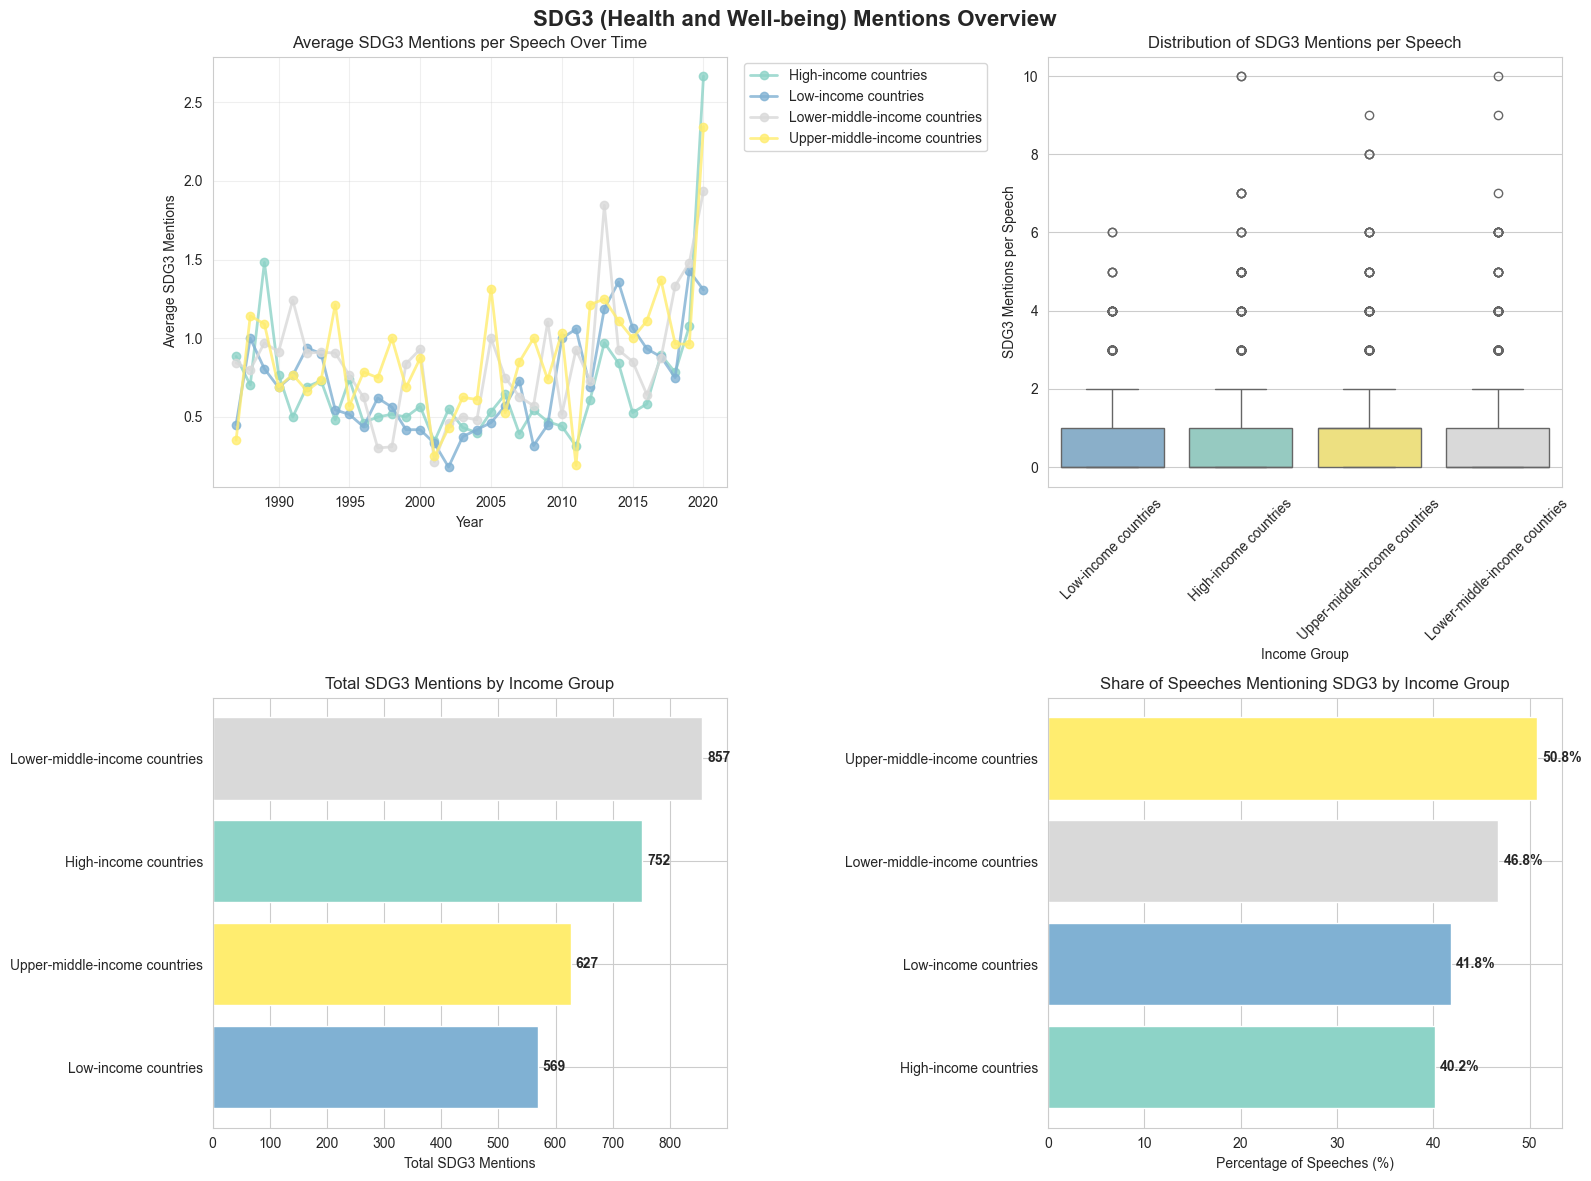


SDG3 MENTIONS SUMMARY BY INCOME GROUP

High-income countries:
  Countries: 41
  Total speeches: 1065
  Total SDG3 mentions: 752
  Speeches mentioning SDG3: 428 (40.2%)
  Average mentions per speech: 0.71

Low-income countries:
  Countries: 38
  Total speeches: 863
  Total SDG3 mentions: 569
  Speeches mentioning SDG3: 361 (41.8%)
  Average mentions per speech: 0.66

Lower-middle-income countries:
  Countries: 61
  Total speeches: 1005
  Total SDG3 mentions: 857
  Speeches mentioning SDG3: 470 (46.8%)
  Average mentions per speech: 0.85

Upper-middle-income countries:
  Countries: 43
  Total speeches: 671
  Total SDG3 mentions: 627
  Speeches mentioning SDG3: 341 (50.8%)
  Average mentions per speech: 0.93


In [ ]:
# Step 4: Visualize SDG3 mentions using the precomputed sdg3_speech_data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

if 'sdg3_speech_data' not in globals() or sdg3_speech_data is None or sdg3_speech_data.empty:
    raise NameError("sdg3_speech_data is not available. Please run the SDG3 analysis cell first.")

sdg3_selected = sdg3_speech_data.copy()

required_columns = {'ISO-alpha3 Code', 'Year', 'SDG3_mentions'}
missing_columns = required_columns - set(sdg3_selected.columns)
if missing_columns:
    raise KeyError(f"sdg3_speech_data is missing required columns: {sorted(missing_columns)}")

sdg3_selected['Year'] = pd.to_numeric(sdg3_selected['Year'], errors='coerce')
sdg3_selected = sdg3_selected.dropna(subset=['Year'])
sdg3_selected['Year'] = sdg3_selected['Year'].astype(int)
sdg3_selected['SDG3_mentions'] = pd.to_numeric(sdg3_selected['SDG3_mentions'], errors='coerce').fillna(0)

classification_col = "World Bank's income classification"
if 'income_groups' in globals() and isinstance(income_groups, pd.DataFrame):
    classification_source = income_groups.copy()
else:
    classification_source = pd.read_csv('./numerical-data/world-bank-income-groups/world-bank-income-groups.csv')

required_lookup_cols = {'Code', 'Year', classification_col}
missing_lookup = required_lookup_cols - set(classification_source.columns)
if missing_lookup:
    raise KeyError(f"Income classification data missing columns: {sorted(missing_lookup)}")

classification_lookup = (
    classification_source[['Code', 'Year', classification_col]]
    .drop_duplicates(subset=['Code', 'Year'])
    .rename(columns={'Code': 'ISO-alpha3 Code'})
)

sdg3_selected = sdg3_selected.merge(
    classification_lookup,
    on=['ISO-alpha3 Code', 'Year'],
    how='left'
)

sdg3_selected['Income_Group'] = sdg3_selected[classification_col].fillna('Unknown income group')
sdg3_selected = sdg3_selected.drop(columns=[classification_col], errors='ignore')

print("Using sdg3_speech_data with the following coverage:")
print(f"  Years: {sdg3_selected['Year'].min()}–{sdg3_selected['Year'].max()}")
print(f"  Countries: {sdg3_selected['ISO-alpha3 Code'].nunique()}")
print(f"  Income groups: {sdg3_selected['Income_Group'].nunique()}")

income_groups = sorted(sdg3_selected['Income_Group'].unique())
palette = plt.cm.Set3(np.linspace(0, 1, len(income_groups)))
group_color_map = dict(zip(income_groups, palette))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SDG3 (Health and Well-being) Mentions Overview', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
for group in income_groups:
    group_data = sdg3_selected[sdg3_selected['Income_Group'] == group]
    if group_data.empty:
        continue
    yearly_avg = (
        group_data
        .groupby('Year')['SDG3_mentions']
        .mean()
        .sort_index()
)
    ax1.plot(
        yearly_avg.index,
        yearly_avg.values,
        marker='o',
        linewidth=2,
        label=group,
        color=group_color_map[group],
        alpha=0.8
    )
ax1.set_title('Average SDG3 Mentions per Speech Over Time')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average SDG3 Mentions')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

ax2 = axes[0, 1]
sdg3_clean = sdg3_selected.dropna(subset=['Income_Group'])
if sdg3_clean['Income_Group'].nunique() > 1:
    sns.boxplot(
        data=sdg3_clean,
        x='Income_Group',
        y='SDG3_mentions',
        hue='Income_Group',
        palette=group_color_map,
        legend=False,
        ax=ax2
)
    ax2.tick_params(axis='x', rotation=45)
else:
    single_group = sdg3_clean['Income_Group'].iloc[0] if not sdg3_clean.empty else 'Unknown income group'
    ax2.bar(
        [0],
        [sdg3_clean['SDG3_mentions'].mean() if not sdg3_clean.empty else 0],
        color=group_color_map.get(single_group, '#1f77b4')
)
    ax2.set_xticks([0])
    ax2.set_xticklabels([single_group])
ax2.set_title('Distribution of SDG3 Mentions per Speech')
ax2.set_xlabel('Income Group')
ax2.set_ylabel('SDG3 Mentions per Speech')

ax3 = axes[1, 0]
group_totals = sdg3_selected.groupby('Income_Group')['SDG3_mentions'].sum().sort_values(ascending=True)
bars = ax3.barh(
    range(len(group_totals)),
    group_totals.values,
    color=[group_color_map[g] for g in group_totals.index]
)
ax3.set_yticks(range(len(group_totals)))
ax3.set_yticklabels(group_totals.index)
ax3.set_title('Total SDG3 Mentions by Income Group')
ax3.set_xlabel('Total SDG3 Mentions')
for i, value in enumerate(group_totals.values):
    ax3.text(
        value + max(group_totals.values) * 0.01,
        i,
        int(value),
        va='center',
        fontweight='bold'
)

ax4 = axes[1, 1]
group_percentages = (
    sdg3_selected
    .groupby('Income_Group')
    .apply(lambda df: (df['SDG3_mentions'] > 0).sum() / len(df) * 100)
    .sort_values(ascending=True)
)
group_percentages = group_percentages.rename('Percent_with_SDG3')
bars = ax4.barh(
    range(len(group_percentages)),
    group_percentages.values,
    color=[group_color_map[g] for g in group_percentages.index]
)
ax4.set_yticks(range(len(group_percentages)))
ax4.set_yticklabels(group_percentages.index)
ax4.set_title('Share of Speeches Mentioning SDG3 by Income Group')
ax4.set_xlabel('Percentage of Speeches (%)')
for i, value in enumerate(group_percentages.values):
    ax4.text(
        value + max(group_percentages.values) * 0.01,
        i,
        f"{value:.1f}%",
        va='center',
        fontweight='bold'
)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("SDG3 MENTIONS SUMMARY BY INCOME GROUP")
print("=" * 60)
for group in income_groups:
    group_data = sdg3_selected[sdg3_selected['Income_Group'] == group]
    if group_data.empty:
        continue
    total_speeches = len(group_data)
    total_mentions = group_data['SDG3_mentions'].sum()
    speeches_with_mentions = (group_data['SDG3_mentions'] > 0).sum()
    avg_mentions = group_data['SDG3_mentions'].mean()
    print(f"\n{group}:")
    print(f"  Countries: {group_data['ISO-alpha3 Code'].nunique()}")
    print(f"  Total speeches: {total_speeches}")
    print(f"  Total SDG3 mentions: {int(total_mentions)}")
    print(
        f"  Speeches mentioning SDG3: {speeches_with_mentions} "
        f"({(speeches_with_mentions / total_speeches) * 100:.1f}%)"
)
    print(f"  Average mentions per speech: {avg_mentions:.2f}")

In [ ]:
# show top 10 countries mentioning SDG3 per income_group

In [ ]:
# how many of total speeches contain SDG3 mentinons per income_group

## Take 1995-2000 (5 years)

Using sdg3_speech_data with the following coverage (filtered window):
  Years: 1995–2000
  Countries: 106
  Income groups: 4


C:\Users\mariu\AppData\Local\Temp\ipykernel_23920\986912783.py:144: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['SDG3_mentions'] > 0).sum() / len(df) * 100)


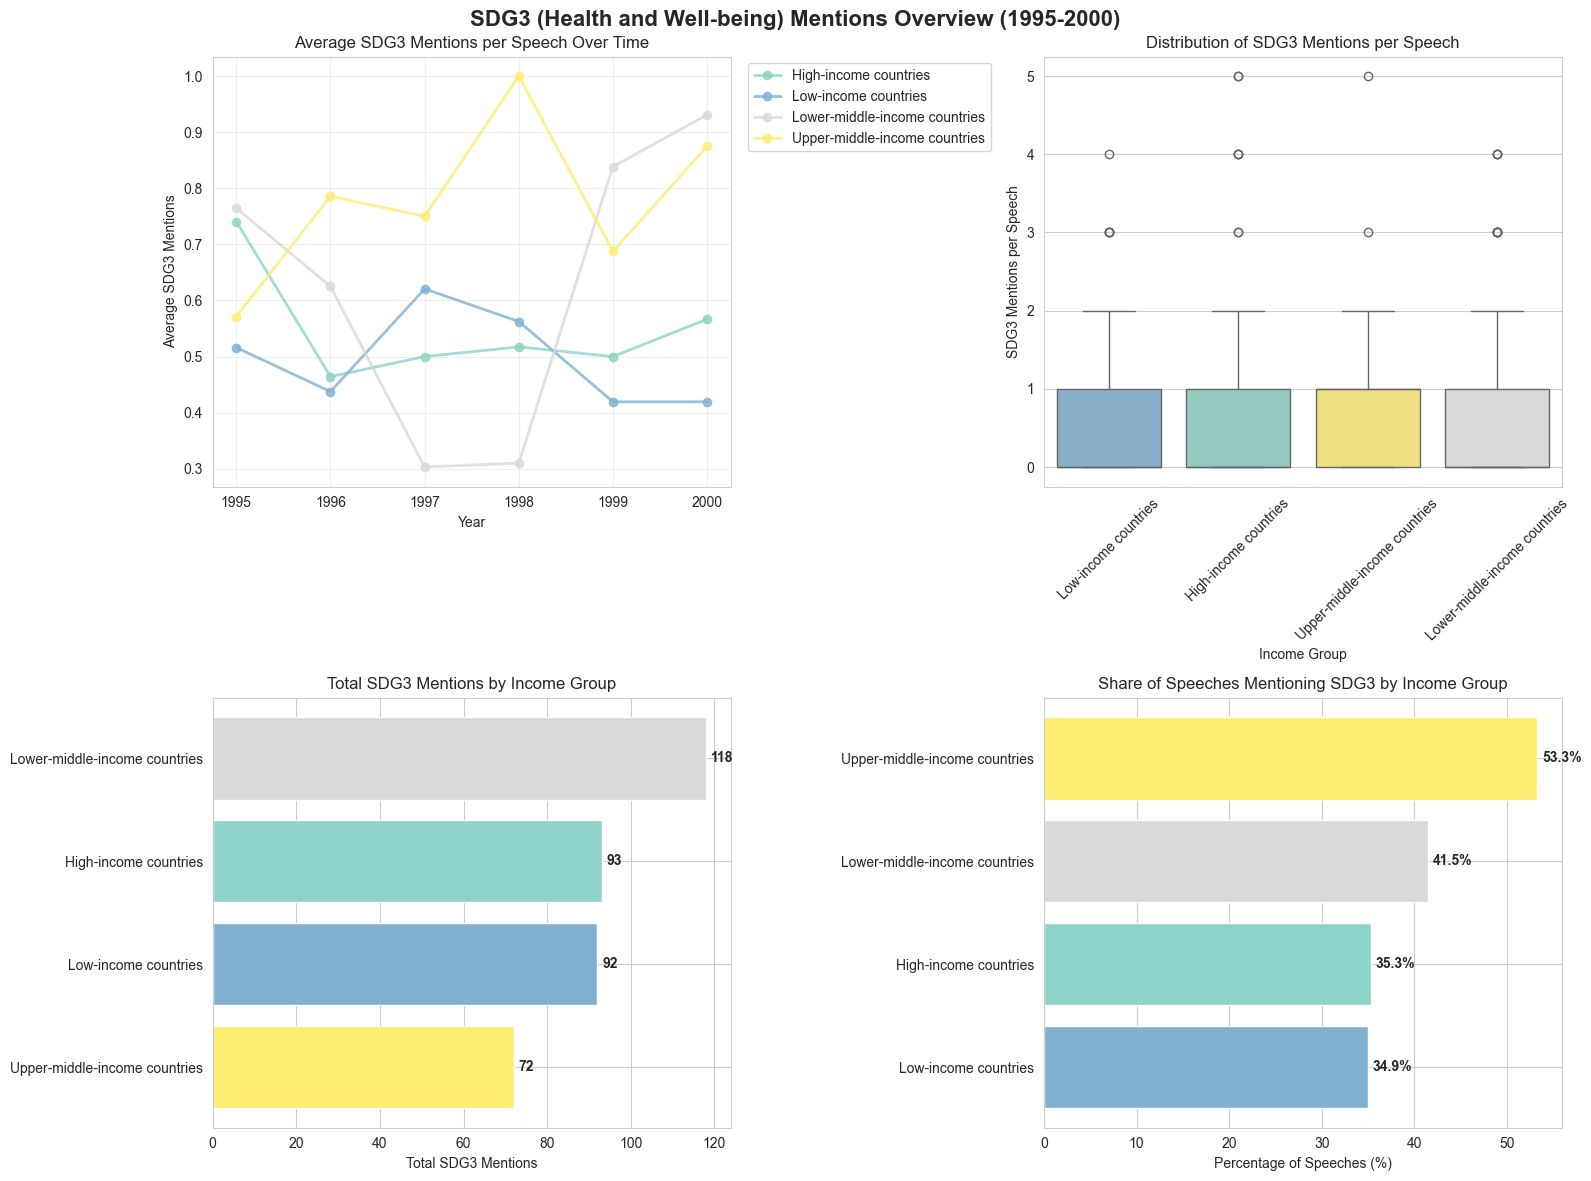


SDG3 MENTIONS SUMMARY BY INCOME GROUP (1995-2000)

High-income countries:
  Countries: 30
  Total speeches: 170
  Total SDG3 mentions: 93
  Speeches mentioning SDG3: 60 (35.3%)
  Average mentions per speech: 0.55

Low-income countries:
  Countries: 34
  Total speeches: 186
  Total SDG3 mentions: 92
  Speeches mentioning SDG3: 65 (34.9%)
  Average mentions per speech: 0.49

Lower-middle-income countries:
  Countries: 37
  Total speeches: 188
  Total SDG3 mentions: 118
  Speeches mentioning SDG3: 78 (41.5%)
  Average mentions per speech: 0.63

Upper-middle-income countries:
  Countries: 19
  Total speeches: 92
  Total SDG3 mentions: 72
  Speeches mentioning SDG3: 49 (53.3%)
  Average mentions per speech: 0.78


In [ ]:
# Step 4: Visualize SDG3 mentions using the precomputed sdg3_speech_data (Filtered to 1995-2000)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

YEAR_START, YEAR_END = 1995, 2000

if 'sdg3_speech_data' not in globals() or sdg3_speech_data is None or sdg3_speech_data.empty:
    raise NameError("sdg3_speech_data is not available. Please run the SDG3 analysis cell first.")

sdg3_selected = sdg3_speech_data.copy()

required_columns = {'ISO-alpha3 Code', 'Year', 'SDG3_mentions'}
missing_columns = required_columns - set(sdg3_selected.columns)
if missing_columns:
    raise KeyError(f"sdg3_speech_data is missing required columns: {sorted(missing_columns)}")

sdg3_selected['Year'] = pd.to_numeric(sdg3_selected['Year'], errors='coerce')
sdg3_selected = sdg3_selected.dropna(subset=['Year'])
sdg3_selected['Year'] = sdg3_selected['Year'].astype(int)
sdg3_selected['SDG3_mentions'] = pd.to_numeric(sdg3_selected['SDG3_mentions'], errors='coerce').fillna(0)

# Apply year window filter
sdg3_selected = sdg3_selected[(sdg3_selected['Year'] >= YEAR_START) & (sdg3_selected['Year'] <= YEAR_END)].copy()
if sdg3_selected.empty:
    raise ValueError(f"No SDG3 speech data in the selected window {YEAR_START}-{YEAR_END}.")

classification_col = "World Bank's income classification"
if 'income_groups' in globals() and isinstance(income_groups, pd.DataFrame):
    classification_source = income_groups.copy()
else:
    classification_source = pd.read_csv('./numerical-data/world-bank-income-groups/world-bank-income-groups.csv')

required_lookup_cols = {'Code', 'Year', classification_col}
missing_lookup = required_lookup_cols - set(classification_source.columns)
if missing_lookup:
    raise KeyError(f"Income classification data missing columns: {sorted(missing_lookup)}")

classification_lookup = (
    classification_source[['Code', 'Year', classification_col]]
    .drop_duplicates(subset=['Code', 'Year'])
    .rename(columns={'Code': 'ISO-alpha3 Code'})
)

sdg3_selected = sdg3_selected.merge(
    classification_lookup,
    on=['ISO-alpha3 Code', 'Year'],
    how='left'
)

sdg3_selected['Income_Group'] = sdg3_selected[classification_col].fillna('Unknown income group')
sdg3_selected = sdg3_selected.drop(columns=[classification_col], errors='ignore')

print("Using sdg3_speech_data with the following coverage (filtered window):")
print(f"  Years: {sdg3_selected['Year'].min()}–{sdg3_selected['Year'].max()}")
print(f"  Countries: {sdg3_selected['ISO-alpha3 Code'].nunique()}")
print(f"  Income groups: {sdg3_selected['Income_Group'].nunique()}")

income_groups = sorted(sdg3_selected['Income_Group'].unique())
palette = plt.cm.Set3(np.linspace(0, 1, len(income_groups)))
group_color_map = dict(zip(income_groups, palette))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'SDG3 (Health and Well-being) Mentions Overview ({YEAR_START}-{YEAR_END})', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
for group in income_groups:
    group_data = sdg3_selected[sdg3_selected['Income_Group'] == group]
    if group_data.empty:
        continue
    yearly_avg = (
        group_data
        .groupby('Year')['SDG3_mentions']
        .mean()
        .sort_index()
)
    ax1.plot(
        yearly_avg.index,
        yearly_avg.values,
        marker='o',
        linewidth=2,
        label=group,
        color=group_color_map[group],
        alpha=0.8
)
ax1.set_title('Average SDG3 Mentions per Speech Over Time')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average SDG3 Mentions')
ax1.set_xticks(range(YEAR_START, YEAR_END + 1))
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

ax2 = axes[0, 1]
sdg3_clean = sdg3_selected.dropna(subset=['Income_Group'])
if sdg3_clean['Income_Group'].nunique() > 1:
    sns.boxplot(
        data=sdg3_clean,
        x='Income_Group',
        y='SDG3_mentions',
        hue='Income_Group',
        palette=group_color_map,
        legend=False,
        ax=ax2
)
    ax2.tick_params(axis='x', rotation=45)
else:
    single_group = sdg3_clean['Income_Group'].iloc[0] if not sdg3_clean.empty else 'Unknown income group'
    ax2.bar(
        [0],
        [sdg3_clean['SDG3_mentions'].mean() if not sdg3_clean.empty else 0],
        color=group_color_map.get(single_group, '#1f77b4')
)
    ax2.set_xticks([0])
    ax2.set_xticklabels([single_group])
ax2.set_title('Distribution of SDG3 Mentions per Speech')
ax2.set_xlabel('Income Group')
ax2.set_ylabel('SDG3 Mentions per Speech')

ax3 = axes[1, 0]
group_totals = sdg3_selected.groupby('Income_Group')['SDG3_mentions'].sum().sort_values(ascending=True)
bars = ax3.barh(
    range(len(group_totals)),
    group_totals.values,
    color=[group_color_map[g] for g in group_totals.index]
)
ax3.set_yticks(range(len(group_totals)))
ax3.set_yticklabels(group_totals.index)
ax3.set_title('Total SDG3 Mentions by Income Group')
ax3.set_xlabel('Total SDG3 Mentions')
for i, value in enumerate(group_totals.values):
    ax3.text(
        value + max(group_totals.values) * 0.01,
        i,
        int(value),
        va='center',
        fontweight='bold',
)

ax4 = axes[1, 1]
group_percentages = (
    sdg3_selected
    .groupby('Income_Group')
    .apply(lambda df: (df['SDG3_mentions'] > 0).sum() / len(df) * 100)
    .sort_values(ascending=True)
)
group_percentages = group_percentages.rename('Percent_with_SDG3')
bars = ax4.barh(
    range(len(group_percentages)),
    group_percentages.values,
    color=[group_color_map[g] for g in group_percentages.index]
)
ax4.set_yticks(range(len(group_percentages)))
ax4.set_yticklabels(group_percentages.index)
ax4.set_title('Share of Speeches Mentioning SDG3 by Income Group')
ax4.set_xlabel('Percentage of Speeches (%)')
for i, value in enumerate(group_percentages.values):
    ax4.text(
        value + max(group_percentages.values) * 0.01,
        i,
        f"{value:.1f}%",
        va='center',
        fontweight='bold',
)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print(f"SDG3 MENTIONS SUMMARY BY INCOME GROUP ({YEAR_START}-{YEAR_END})")
print("=" * 60)
for group in income_groups:
    group_data = sdg3_selected[sdg3_selected['Income_Group'] == group]
    if group_data.empty:
        continue
    total_speeches = len(group_data)
    total_mentions = group_data['SDG3_mentions'].sum()
    speeches_with_mentions = (group_data['SDG3_mentions'] > 0).sum()
    avg_mentions = group_data['SDG3_mentions'].mean()
    print(f"\n{group}:")
    print(f"  Countries: {group_data['ISO-alpha3 Code'].nunique()}")
    print(f"  Total speeches: {total_speeches}")
    print(f"  Total SDG3 mentions: {int(total_mentions)}")
    print(
        f"  Speeches mentioning SDG3: {speeches_with_mentions} "
        f"({(speeches_with_mentions / total_speeches) * 100:.1f}%)"
)
    print(f"  Average mentions per speech: {avg_mentions:.2f}")

Countries with speeches between 1995 and 2000 (inclusive):
                 Income_Group  Countries_with_Speeches
Lower-middle-income countries                       37
         Low-income countries                       34
        High-income countries                       30
Upper-middle-income countries                       19


C:\Users\mariu\AppData\Local\Temp\ipykernel_23920\574543096.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


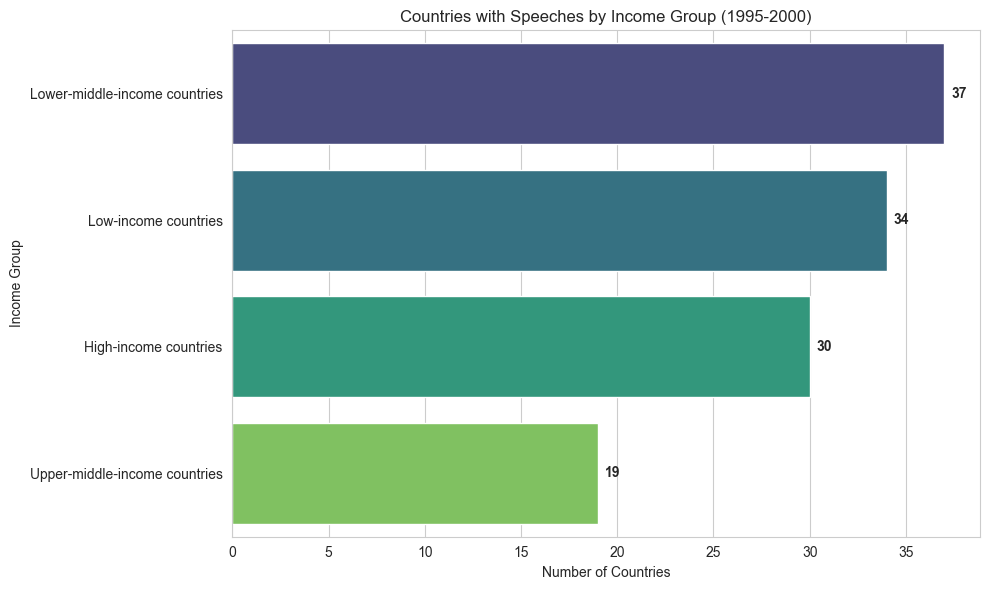

In [ ]:
# Countries with speeches per income group (1995-2000 window)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

window_start, window_end = 1995, 2000

if 'sdg3_speech_data' not in globals() or sdg3_speech_data is None or sdg3_speech_data.empty:
    raise NameError("sdg3_speech_data is not available. Please run the SDG3 analysis cell first.")

window_df = sdg3_speech_data.copy()
required_columns = {'ISO-alpha3 Code', 'Year'}
missing_columns = required_columns - set(window_df.columns)
if missing_columns:
    raise KeyError(f"sdg3_speech_data is missing required columns: {sorted(missing_columns)}")

window_df['Year'] = pd.to_numeric(window_df['Year'], errors='coerce')
window_df = window_df.dropna(subset=['Year'])
window_df['Year'] = window_df['Year'].astype(int)

window_df = window_df[(window_df['Year'] >= window_start) & (window_df['Year'] <= window_end)]
if window_df.empty:
    raise ValueError(f"No speech records found between {window_start} and {window_end}.")

classification_col = "World Bank's income classification"
classification_source = None
if 'income_groups' in globals() and isinstance(income_groups, pd.DataFrame):
    if {'Code', 'Year', classification_col}.issubset(income_groups.columns):
        classification_source = income_groups.copy()

if classification_source is None:
    classification_source = pd.read_csv('./numerical-data/world-bank-income-groups/world-bank-income-groups.csv')

classification_lookup = (
    classification_source[['Code', 'Year', classification_col]]
    .drop_duplicates(subset=['Code', 'Year'])
    .rename(columns={'Code': 'ISO-alpha3 Code'})
    .dropna(subset=['ISO-alpha3 Code'])
    .copy()
    )

window_df = window_df.merge(
    classification_lookup,
    on=['ISO-alpha3 Code', 'Year'],
    how='left'
    )

window_df['Income_Group'] = window_df[classification_col].fillna('Unknown income group')
window_df = window_df.drop(columns=[classification_col], errors='ignore')

countries_per_group = (
    window_df.dropna(subset=['Income_Group'])
    .drop_duplicates(subset=['Income_Group', 'ISO-alpha3 Code'])
    .groupby('Income_Group')
    .size()
    .sort_values(ascending=False)
    )

summary_df = countries_per_group.reset_index()
summary_df.columns = ['Income_Group', 'Countries_with_Speeches']

print(f"Countries with speeches between {window_start} and {window_end} (inclusive):")
print(summary_df.to_string(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary_df,
    x='Countries_with_Speeches',
    y='Income_Group',
    palette='viridis'
    )
plt.title(f"Countries with Speeches by Income Group ({window_start}-{window_end})")
plt.xlabel('Number of Countries')
plt.ylabel('Income Group')
for index, value in enumerate(summary_df['Countries_with_Speeches']):
    plt.text(
        value + summary_df['Countries_with_Speeches'].max() * 0.01,
        index,
        f"{int(value)}",
        va='center',
        fontweight='bold'
        )
plt.tight_layout()
plt.show()

In [ ]:
# speeches in 5 y period

In [ ]:
# Countries with speeches per year (1995-2000) derived from merged_health_trade_df
import pandas as pd
WINDOW_START, WINDOW_END = 1995, 2000

if 'merged_health_trade_df' not in globals() or merged_health_trade_df is None or merged_health_trade_df.empty:
    raise NameError("merged_health_trade_df not available.")

# Flatten index if MultiIndex
if isinstance(merged_health_trade_df.index, pd.MultiIndex):
    flat_df = merged_health_trade_df.reset_index()
else:
    flat_df = merged_health_trade_df.copy()

required_cols = {'ISO-alpha3 Code','Year','Speech'}
missing_cols = required_cols - set(flat_df.columns)
if missing_cols:
    raise KeyError(f"merged_health_trade_df missing required columns: {sorted(missing_cols)}")

flat_df['Year'] = pd.to_numeric(flat_df['Year'], errors='coerce')
flat_df = flat_df.dropna(subset=['Year'])
flat_df['Year'] = flat_df['Year'].astype(int)
year_slice = flat_df[flat_df['Year'].between(WINDOW_START, WINDOW_END)].copy()

def speech_present(val):
    if pd.isna(val):
        return False
    if not isinstance(val, str):
        return False
    return len(val.strip()) > 0

year_slice['Has_Speech'] = year_slice['Speech'].apply(speech_present)

presence = (year_slice.groupby(['ISO-alpha3 Code','Year'])['Has_Speech'].max().reset_index())

# Attempt to attach readable country names
country_name_col = None
for candidate in ['Country','Country_Name','country_name','State']:
    if candidate in flat_df.columns:
        country_name_col = candidate
        break
if country_name_col:
    latest_names = (flat_df[[country_name_col,'ISO-alpha3 Code']].dropna().drop_duplicates(subset=['ISO-alpha3 Code'], keep='last'))
    presence = presence.merge(latest_names, on='ISO-alpha3 Code', how='left')

print(f"Speech presence by year ({WINDOW_START}-{WINDOW_END}):")
for yr in range(WINDOW_START, WINDOW_END+1):
    subset = presence[(presence['Year']==yr) & (presence['Has_Speech'])]
    codes = sorted(subset['ISO-alpha3 Code'].unique())
    print(f"\nYear {yr}: {len(codes)} countries with speech text")
    if codes:
        line = []
        line_len = 0
        for c in codes:
            token = c
            if line_len + len(token) + 2 > 100:
                print('  ' + ', '.join(line))
                line = [token]
                line_len = len(token)
            else:
                line.append(token)
                line_len += len(token) + 2
        if line:
            print('  ' + ', '.join(line))
    else:
        print('  (none)')

presence_matrix = (presence.pivot_table(index='ISO-alpha3 Code', columns='Year', values='Has_Speech', aggfunc='max', fill_value=False))
presence_matrix = presence_matrix.reindex(sorted(presence_matrix.index))
print("\nPresence matrix sample (first 25 countries):")
print(presence_matrix.head(25).replace({True:1, False:0}))

speech_presence_1995_2000 = presence_matrix.copy()

Speech presence by year (1995-2000):

Year 1995: 172 countries with speech text
  AFG, AGO, ALB, AND, ARE, ARG, ARM, ATG, AUS, AUT, AZE, BDI, BEL, BEN, BFA, BGD, BGR, BHR, BHS, BIH
  BLR, BLZ, BOL, BRA, BRB, BRN, BTN, BWA, CAF, CAN, CHL, CHN, CMR, COD, COG, COL, CRI, CUB, CYP, CZE
  DEU, DJI, DNK, DOM, DZA, ECU, EGY, ERI, ESP, EST, ETH, FIN, FJI, FRA, FSM, GAB, GBR, GEO, GHA, GIN
  GMB, GNB, GNQ, GRC, GRD, GTM, GUY, HND, HRV, HTI, HUN, IDN, IND, IRL, IRN, IRQ, ISL, ISR, ITA, JAM
  JOR, JPN, KAZ, KEN, KGZ, KHM, KNA, KOR, KWT, LAO, LBN, LBR, LBY, LCA, LIE, LKA, LSO, LTU, LUX, LVA
  MAR, MCO, MDA, MDG, MDV, MEX, MHL, MKD, MLI, MLT, MMR, MNG, MOZ, MRT, MUS, MWI, MYS, NAM, NER, NGA
  NIC, NLD, NOR, NPL, NZL, OMN, PAK, PAN, PER, PHL, PNG, POL, PRK, PRT, PRY, QAT, ROU, RUS, RWA, SDN
  SEN, SGP, SLB, SLE, SLV, SMR, SUR, SVK, SVN, SWE, SWZ, SYR, TCD, TGO, THA, TJK, TKM, TTO, TUN, TUR
  TZA, UGA, UKR, URY, USA, VCT, VEN, VNM, WSM, YEM, ZAF, ZMB

Year 1996: 181 countries with speech text
  AFG, A

C:\Users\mariu\AppData\Local\Temp\ipykernel_23920\126266553.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(presence_matrix.head(25).replace({True:1, False:0}))


In [ ]:
## sdg3_speech_data EDA

## availability of speeches in chosen countries over a period of 5 years

justified by the change in income group not being meaningful over it. and large enough to have a speech.

In [ ]:
# Count unique countries with speeches in sdg3_speech_data
if 'sdg3_speech_data' not in globals():
    raise NameError("sdg3_speech_data is not defined. Please run the SDG3 analysis cell first.")

unique_country_codes = sdg3_speech_data['ISO-alpha3 Code'].nunique()
unique_country_names = sdg3_speech_data['Country or Area'].dropna().nunique() if 'Country or Area' in sdg3_speech_data.columns else None

print(f"Unique country codes with speeches: {unique_country_codes}")
if unique_country_names is not None:
    print(f"Unique country names with speeches: {unique_country_names}")

Unique country codes with speeches: 106
Unique country names with speeches: 106


## Chi-square to see between group difference

In [ ]:
# Chi-square test: Income group vs presence of SDG3 mentions (1995–1999)
import pandas as pd
import numpy as np

YEAR_START, YEAR_END = 1995, 1999
classification_col = "World Bank's income classification"

# Preconditions
if 'sdg3_speech_data' not in globals() or sdg3_speech_data is None or sdg3_speech_data.empty:
    raise NameError("sdg3_speech_data is not available. Run the SDG3 analysis cell first.")

subset = sdg3_speech_data.copy()
required_cols = {'ISO-alpha3 Code','Year','SDG3_mentions'}
missing = required_cols - set(subset.columns)
if missing:
    raise KeyError(f"sdg3_speech_data missing columns: {sorted(missing)}")

# Clean & filter years
subset['Year'] = pd.to_numeric(subset['Year'], errors='coerce')
subset = subset.dropna(subset=['Year'])
subset['Year'] = subset['Year'].astype(int)
subset = subset[subset['Year'].between(YEAR_START, YEAR_END)]
if subset.empty:
    raise ValueError(f"No rows in window {YEAR_START}-{YEAR_END}.")

# Income classification source
if ('income_groups' in globals() and isinstance(income_groups, pd.DataFrame) and
    {'Code','Year', classification_col}.issubset(income_groups.columns)):
    classification_source = income_groups.copy()
else:
    classification_source = pd.read_csv('./numerical-data/world-bank-income-groups/world-bank-income-groups.csv')

class_lookup = (classification_source[['Code','Year', classification_col]]
                .drop_duplicates(subset=['Code','Year'])
                .rename(columns={'Code':'ISO-alpha3 Code'}))

subset = subset.merge(class_lookup, on=['ISO-alpha3 Code','Year'], how='left')
subset[classification_col] = subset[classification_col].fillna('Unknown income group')

# Binary presence
subset['SDG3_present'] = (pd.to_numeric(subset['SDG3_mentions'], errors='coerce').fillna(0) > 0)

# Build contingency table (rows: income groups, cols: False/True)
contingency = pd.crosstab(subset[classification_col], subset['SDG3_present'])
if contingency.shape[0] < 2 or contingency.shape[1] < 2:
    raise ValueError("Not enough category variation for chi-square test.")

# Manual chi-square (so we don't rely on SciPy being installed)
observed = contingency.values.astype(float)
row_tot = observed.sum(axis=1, keepdims=True)
col_tot = observed.sum(axis=0, keepdims=True)
grand_tot = observed.sum()
expected = row_tot @ col_tot / grand_tot
with np.errstate(divide='ignore', invalid='ignore'):
    chi_components = (observed - expected)**2 / expected
    chi_components = np.nan_to_num(chi_components)
chi2 = chi_components.sum()
dof = (observed.shape[0]-1)*(observed.shape[1]-1)

# p-value approximation (fallback) using survival function from scipy if available
try:
    from scipy.stats import chi2 as chi2_dist
    p_value = chi2_dist.sf(chi2, dof)
except Exception:
    # Simple approximation via incomplete gamma (optional) - fallback to None if scipy absent
    p_value = None

# Cramer's V
r, c = observed.shape
cramers_v = np.sqrt(chi2 / (grand_tot * (min(r-1, c-1)))) if min(r-1, c-1) > 0 else np.nan

# Output
print(f"Chi-square test: Income group vs SDG3 mention presence ({YEAR_START}-{YEAR_END})")
print('-'*78)
print('Observed counts:')
print(contingency)
print('\nExpected counts:')
exp_df = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
print(exp_df.round(2))
print('\nSummary:')
print(f"  Total observations : {int(grand_tot)}")
print(f"  Chi2 statistic     : {chi2:.3f}")
print(f"  Degrees of freedom : {dof}")
if p_value is not None:
    print(f"  p-value            : {p_value:.6f}")
else:
    print("  p-value            : (SciPy not available - install scipy for exact p-value)")
print(f"  Cramer's V         : {cramers_v:.3f}")

# Interpretation (only if p available)
if p_value is not None:
    alpha = 0.05
    if p_value < alpha:
        print(f"\nResult: p < {alpha}. Reject null hypothesis (association detected).")
    else:
        print(f"\nResult: p >= {alpha}. Fail to reject null (no significant association).")

# Check small expected counts
small_cells = int((expected < 5).sum())
if small_cells > 0:
    print(f"\nWarning: {small_cells} expected cell(s) < 5; chi-square approximation may be unreliable.")

Chi-square test: Income group vs SDG3 mention presence (1995-1999)
------------------------------------------------------------------------------
Observed counts:
SDG3_present                        False  True 
World Bank's income classification              
High-income countries                  95     45
Low-income countries                   98     57
Lower-middle-income countries          97     62
Upper-middle-income countries          34     42

Expected counts:
SDG3_present                        False  True 
World Bank's income classification              
High-income countries               85.58  54.42
Low-income countries                94.75  60.25
Lower-middle-income countries       97.20  61.80
Upper-middle-income countries       46.46  29.54

Summary:
  Total observations : 530
  Chi2 statistic     : 11.550
  Degrees of freedom : 3
  p-value            : 0.009097
  Cramer's V         : 0.148

Result: p < 0.05. Reject null hypothesis (association detected).


Post-hoc residual analysis (alpha=0.05, Bonferroni alpha=0.00625)
Significant cells (Bonferroni):
  Upper-middle-income countries / SDG3=No: Obs=34, Exp=46.46, AdjRes=-3.17, p=0.00153 (lower than expected)
  Upper-middle-income countries / SDG3=Yes: Obs=42, Exp=29.54, AdjRes=3.17, p=0.00153 (higher than expected)

Detailed table (first 12 rows):
                 Income_Group SDG3_present  Observed  Expected  Adj_Residual  p_value  Signif_Bonferroni
        High-income countries           No      95.0 85.584906      1.902988 0.057042                  0
         Low-income countries           No      98.0 94.754717      0.635739 0.524947                  0
Lower-middle-income countries           No      97.0 97.200000     -0.038891 0.968977                  0
Upper-middle-income countries           No      34.0 46.460377     -3.168139 0.001534                  1
        High-income countries          Yes      45.0 54.415094     -1.902988 0.057042                  0
         Low-income co

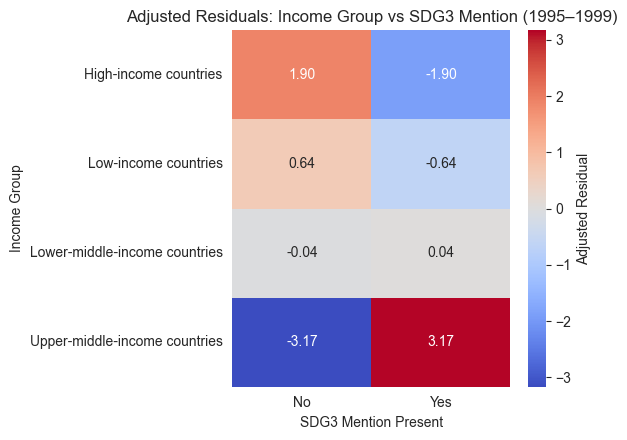

In [ ]:
# Post-hoc residual analysis for chi-square (income group vs SDG3 presence, 1995–1999)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
try:
    from scipy.stats import norm
    _have_norm = True
except Exception:
    _have_norm = False

def _rebuild_contingency():
    global contingency, expected, observed, classification_col, subset
    classification_col = "World Bank's income classification"
    if 'sdg3_speech_data' not in globals():
        raise NameError('sdg3_speech_data missing; cannot rebuild.')
    df = sdg3_speech_data.copy()
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df = df.dropna(subset=['Year'])
    df['Year'] = df['Year'].astype(int)
    df = df[df['Year'].between(1995,1999)]
    class_src = None
    if ('income_groups' in globals() and isinstance(income_groups, pd.DataFrame) and
        {'Code','Year', classification_col}.issubset(income_groups.columns)):
        class_src = income_groups.copy()
    else:
        class_src = pd.read_csv('./numerical-data/world-bank-income-groups/world-bank-income-groups.csv')
    lookup = (class_src[['Code','Year', classification_col]]
              .drop_duplicates(subset=['Code','Year'])
              .rename(columns={'Code':'ISO-alpha3 Code'}))
    df = df.merge(lookup, on=['ISO-alpha3 Code','Year'], how='left')
    df[classification_col] = df[classification_col].fillna('Unknown income group')
    df['SDG3_present'] = (pd.to_numeric(df['SDG3_mentions'], errors='coerce').fillna(0) > 0)
    subset_local = df
    cont = pd.crosstab(subset_local[classification_col], subset_local['SDG3_present'])
    obs = cont.values.astype(float)
    row_tot = obs.sum(axis=1, keepdims=True)
    col_tot = obs.sum(axis=0, keepdims=True)
    grand = obs.sum()
    exp = row_tot @ col_tot / grand
    contingency, expected, observed = cont, exp, obs
    return subset_local

# Ensure we have contingency and expected from previous cell; rebuild if not
missing_needed = any(name not in globals() for name in ['contingency','expected','observed'])
if missing_needed:
    subset = _rebuild_contingency()
else:
    # Also capture subset for clarity if absent
    if 'subset' not in globals():
        subset = _rebuild_contingency()

observed = observed.astype(float)
expected = expected.astype(float)
row_totals = observed.sum(axis=1, keepdims=True)
col_totals = observed.sum(axis=0, keepdims=True)
grand_total = observed.sum()

# Standardized residuals: (O - E)/sqrt(E)
std_resid = (observed - expected) / np.sqrt(expected)

# Adjusted residuals (Haberman): (O - E)/sqrt(E*(1 - row_prop)*(1 - col_prop))
row_prop = row_totals / grand_total
col_prop = col_totals / grand_total
adj_denom = np.sqrt(expected * (1 - row_prop) * (1 - col_prop))
with np.errstate(divide='ignore', invalid='ignore'):
    adj_resid = (observed - expected) / adj_denom
    adj_resid = np.nan_to_num(adj_resid)

# Two-tailed p-values per cell from adjusted residuals (approx Z)
if _have_norm:
    p_values = 2 * (1 - norm.cdf(np.abs(adj_resid)))
else:
    p_values = np.full_like(adj_resid, np.nan)

# Multiple testing correction (Bonferroni)
num_tests = adj_resid.size
alpha = 0.05
alpha_bonf = alpha / num_tests
significant = p_values < alpha_bonf if _have_norm else np.full_like(p_values, False)

index_names = contingency.index.tolist()
col_names = [str(c) for c in contingency.columns.tolist()]

def _matrix_to_df(mat, value_name):
    return (pd.DataFrame(mat, index=index_names, columns=col_names)
              .reset_index().melt(id_vars='index', var_name='SDG3_present', value_name=value_name)
              .rename(columns={'index': 'Income_Group'}))

df_std = _matrix_to_df(std_resid, 'Std_Residual')
df_adj = _matrix_to_df(adj_resid, 'Adj_Residual')
df_exp = _matrix_to_df(expected, 'Expected')
df_obs = _matrix_to_df(observed, 'Observed')
df_p = _matrix_to_df(p_values, 'p_value')
df_sig = _matrix_to_df(significant.astype(int), 'Signif_Bonferroni')

posthoc_df = df_obs.merge(df_exp, on=['Income_Group','SDG3_present'])\
                    .merge(df_std, on=['Income_Group','SDG3_present'])\
                    .merge(df_adj, on=['Income_Group','SDG3_present'])\
                    .merge(df_p, on=['Income_Group','SDG3_present'])\
                    .merge(df_sig, on=['Income_Group','SDG3_present'])
posthoc_df['SDG3_present'] = posthoc_df['SDG3_present'].map({'False':'No','True':'Yes'}).fillna(posthoc_df['SDG3_present'])

print(f"Post-hoc residual analysis (alpha={alpha}, Bonferroni alpha={alpha_bonf:.4g})")
print("Significant cells (Bonferroni):")
sig_cells = posthoc_df[posthoc_df['Signif_Bonferroni'] == 1]
if sig_cells.empty:
    print("  None")
else:
    for _, r in sig_cells.iterrows():
        direction = 'higher' if r['Adj_Residual'] > 0 else 'lower'
        print(f"  {r['Income_Group']} / SDG3={r['SDG3_present']}: Obs={int(r['Observed'])}, Exp={r['Expected']:.2f}, AdjRes={r['Adj_Residual']:.2f}, p={r['p_value']:.3g} ({direction} than expected)")

# Show compact table
display_cols = ['Income_Group','SDG3_present','Observed','Expected','Adj_Residual','p_value','Signif_Bonferroni']
print("\nDetailed table (first 12 rows):")
print(posthoc_df[display_cols].head(12).to_string(index=False))

# Heatmap of adjusted residuals
pivot_adj = posthoc_df.pivot(index='Income_Group', columns='SDG3_present', values='Adj_Residual')
plt.figure(figsize=(6, 4.5))
sns.heatmap(pivot_adj, annot=True, fmt='.2f', cmap='coolwarm', center=0, cbar_kws={'label':'Adjusted Residual'})
plt.title('Adjusted Residuals: Income Group vs SDG3 Mention (1995–1999)')
plt.ylabel('Income Group')
plt.xlabel('SDG3 Mention Present')
plt.tight_layout()
plt.show()

# Export (optional): uncomment to save
# posthoc_df.to_csv('chi2_posthoc_1995_1999.csv', index=False)
posthoc_residuals_1995_1999 = posthoc_df.copy()

## BERT experiment. 

In [ ]:
#BERT speech analysis

# SDG3 specific keywords (Health and Well-being)
sdg3_keywords = [
    "well being", "wellbeing", "well-being", "mental health", "public health", "global health", 
    "health care", "healthcare", "health issues", "mental wellness", "disabilit*", "sexual education", 
    "mindfulness", "holism", "illness", "health education", "communicable disease", "health determinants", 
    "vaccine", "substance abuse", "maternal mortality", "family planning", "hazardous chemicals", 
    "pollution", "health equity", "neonatal mortality", "infant mortality", "child health", 
    "road traffic accidents", "reproductive health", "epidemics", "universal health coverage"
 ]

## BERT-Based (Semantic) Health Topic Mention Detection

We augment the earlier dictionary / lexical counts with a semantic approach using a vanilla BERT model. The idea:

1. Take the existing SDG3 / health keyword list (from the earlier cell) as seed terms.
2. Encode each keyword using a BERT encoder (CLS-pooled + mean token pooling hybrid) to obtain a set of health seed embeddings (and an overall centroid).
3. Split each speech into sentences.
4. Encode sentences in batches; for each sentence compute cosine similarity to:
   - (a) the centroid embedding (b) the closest single keyword embedding.
5. A sentence is flagged as a semantic health mention if either similarity exceeds a chosen threshold (default 0.55 — adjustable after inspecting similarity distributions).
6. For each speech we derive:
   - bert_health_sentence_count: number of sentences flagged
   - bert_health_any: binary indicator (>=1 flagged sentence)
   - bert_health_similarity_sum: sum of the maximum (keyword) similarity for flagged sentences (a soft intensity proxy)
   - bert_health_top_sentences: up to N (default 5) example sentences with their similarity scores (for qualitative inspection)
7. We then compare the semantic counts to the lexical SDG3_mentions previously computed.

Notes & Caveats:
- This is not a fine-tuned health classifier; it's a zero-shot semantic proximity heuristic. A dedicated fine-tuning or a domain SentenceTransformer model would likely perform better.
- Threshold choice matters: after running once you can inspect the similarity histogram (below) and adjust.
- Runtime: Encoding every sentence in all years can be slow; we restrict (by default) to the subset of speeches already in `sdg3_speech_data` (106 income-group countries) and (optionally) a year window.
- Reproducibility: Set a fixed random seed; results are deterministic given same model version.
- If GPU is available (CUDA), it will be used automatically.

You can rerun with different parameters (e.g., threshold) without recomputing keyword embeddings.

Proceeding with implementation below.

In [ ]:
df_un_merged.head()

Country or Area Region Name  \
Year ISO-alpha3 Code                               
1970 ALB                     Albania      Europe   
     ARG                   Argentina    Americas   
     AUS                   Australia     Oceania   
     AUT                     Austria      Europe   
     BEL                     Belgium      Europe   

                                      Sub-region Name  \
Year ISO-alpha3 Code                                    
1970 ALB                              Southern Europe   
     ARG              Latin America and the Caribbean   
     AUS                    Australia and New Zealand   
     AUT                               Western Europe   
     BEL                               Western Europe   

                     Least Developed Countries (LDC)  Session  \
Year ISO-alpha3 Code                                            
1970 ALB                                         NaN       25   
     ARG                                         NaN       25   
     AUS                                         NaN       25   
     AUT                                         NaN       25   
     BEL                                         NaN       25   

                                                                 Speech  
Year ISO-alpha3 Code                                                     
1970 ALB              33: May I first convey to our President the co...  
     ARG              177.\t : It is a fortunate coincidence that pr...  
     AUS              100.\t  It is a pleasure for me to extend to y...  
     AUT              155.\t  May I begin by expressing to Ambassado...  
     BEL              176. No doubt each of us, before coming up to ...

## Run this to build Speech_data

Using device: cuda
Loaded 32 unique health keywords.
Selected source DataFrame: df_un_merged (rows=8481)
Available columns (first 25): ['Country or Area', 'Region Name', 'Sub-region Name', 'Least Developed Countries (LDC)', 'Session', 'Speech']
Index level names: ['Year', 'ISO-alpha3 Code']
Detected ISO column: index level -> ISO-alpha3 Code
Detected Year source: index level -> Year (session=False)
Year column after extraction (first 8 rows):
         0     1     2     3     4     5     6     7
Year  1970  1970  1970  1970  1970  1970  1970  1970
Year non-NaN ratio: 100.00%; range: 1970 – 2020
Rows within [1995,1995] year window: 172 (dropped 8309)
Dropped 0 empty speech rows. Remaining: 172
Requested ISOs: ['ARG', 'BRA', 'CHN', 'COL', 'MEX', 'ZAF', 'THA', 'TUR', 'PER', 'MYS']
Present targets (pre-filter): ['ARG', 'BRA', 'CHN', 'COL', 'MEX', 'MYS', 'PER', 'THA', 'TUR', 'ZAF']
Rows after ISO subset: 10 (dropped 162)
Post-filter speeches: 10 | Countries: 10 | Years: [np.int64(1995)]
Spee

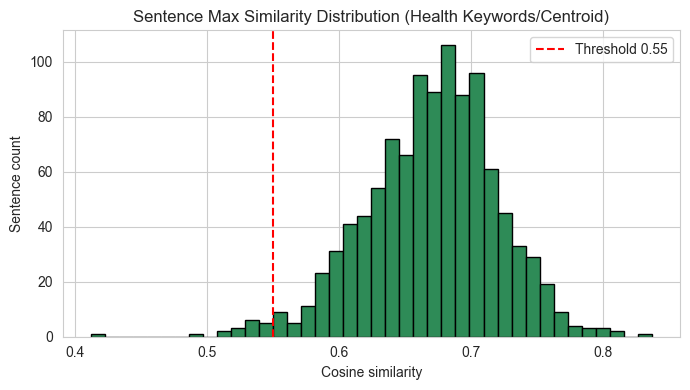

90th percentile of non-flagged similarities: 0.542

Overlap summary:
  lexical_any: 1
  semantic_any: 10
  both: 1
  lexical_only: 0
  semantic_only: 9
  Jaccard lexical vs semantic: 0.100

Done. Result DataFrame: bert_semantic_df (status=ok)


In [ ]:
# Simplified BERT semantic health mention detection (self-building speech dataset)
# Enhanced v2: prioritizes true Year index over Session, correct Session->Year mapping, ISO normalization, deep diagnostics.
# Produces bert_semantic_df (may be empty) and bert_semantic_status with reason; no hard failures.

import math
import re
import torch
import numpy as np
import pandas as pd
from typing import List, Sequence, Optional, Union

try:
    from transformers import AutoTokenizer, AutoModel
except ImportError:
    raise ImportError("Please install transformers: pip install transformers")

# ------------------------------------------------------------------
# User-configurable parameters
# ------------------------------------------------------------------
TARGET_ISO_CODES: Optional[Union[str, Sequence[str]]] = ['ARG', 'BRA', 'CHN', 'COL', 'MEX', 'ZAF', 'THA', 'TUR', 'PER', 'MYS']  # or 'USA' or None
START_YEAR: int = 1995
END_YEAR: int = 1995
USE_GLOBAL_WINDOW = False   # If True and WINDOW_START/END exist they override START/END
if USE_GLOBAL_WINDOW and 'WINDOW_START' in globals() and 'WINDOW_END' in globals():
    START_YEAR, END_YEAR = WINDOW_START, WINDOW_END

# MANUAL OVERRIDES
MANUAL_ISO_COL: Optional[str] = None
MANUAL_YEAR_COL: Optional[str] = None
MANUAL_ISO_INDEX_LEVEL: Optional[str] = None
MANUAL_YEAR_INDEX_LEVEL: Optional[str] = None

BERT_MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE_SENT = 32
SIM_THRESHOLD = 0.55
TOP_EXAMPLE_SENTENCES = 5
USE_CENTROID = True
MAX_SEQ_LEN = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SOURCE_PRIORITY = [
    'df_un_merged',
    'merged_health_trade_df',
    'speech_data',
    'sdg3_speech_data'
]

print(f"Using device: {DEVICE}")

# ------------------------------------------------------------------
# Keywords
# ------------------------------------------------------------------
if 'sdg3_keywords' not in globals():
    raise ValueError("Expected 'sdg3_keywords' list defined earlier.")
health_keywords = sorted(set([kw.lower() for kw in sdg3_keywords]))
print(f"Loaded {len(health_keywords)} unique health keywords.")

# ------------------------------------------------------------------
# Source discovery
# ------------------------------------------------------------------
REQUIRED_SPEECH_COL = 'Speech'
source_df = None
source_name = None
for name in SOURCE_PRIORITY:
    if name in globals():
        candidate = globals()[name]
        if isinstance(candidate, pd.DataFrame) and REQUIRED_SPEECH_COL in candidate.columns:
            source_df = candidate
            source_name = name
            break

skip_reason = None

if source_df is None:
    skip_reason = "no_source_df_with_speech"
else:
    print(f"Selected source DataFrame: {source_name} (rows={len(source_df)})")
    print("Available columns (first 25):", list(source_df.columns)[:25])
    if isinstance(source_df.index, pd.MultiIndex):
        print("Index level names:", source_df.index.names)

# Detect ISO column
ISO_CANDIDATES = ['ISO-alpha3 Code','ISO3','ISO','country','country_code','Code','iso3','iso_code','Country Code','Country_Code','Alpha-3 code']
iso_col = None
iso_from_index = False
if not skip_reason:
    # Manual override first (column)
    if MANUAL_ISO_COL and MANUAL_ISO_COL in source_df.columns:
        iso_col = MANUAL_ISO_COL
    else:
        # Column candidates
        for cand in ISO_CANDIDATES:
            if cand in source_df.columns:
                iso_col = cand
                break
    # Index fallback
    if iso_col is None and isinstance(source_df.index, pd.MultiIndex):
        if MANUAL_ISO_INDEX_LEVEL and MANUAL_ISO_INDEX_LEVEL in source_df.index.names:
            iso_col = MANUAL_ISO_INDEX_LEVEL
            iso_from_index = True
        else:
            # Prefer an index level literally called 'ISO-alpha3 Code'
            if 'ISO-alpha3 Code' in source_df.index.names:
                iso_col = 'ISO-alpha3 Code'
                iso_from_index = True
            else:
                for lvl in source_df.index.names:
                    if lvl is None: continue
                    low = lvl.lower()
                    if 'year' in low or 'session' in low: continue
                    iso_col = lvl
                    iso_from_index = True
                    break
    if iso_col is None:
        skip_reason = 'no_iso_column'

# Detect Year column (PRIORITIZE true Year index level over Session column)
YEAR_CANDIDATES = ['Year','year','YEAR','Session','session']
year_col = None
year_from_index = False
year_is_session = False
if not skip_reason:
    # Manual column override first
    if MANUAL_YEAR_COL and MANUAL_YEAR_COL in source_df.columns:
        year_col = MANUAL_YEAR_COL
    else:
        # If MultiIndex and has a Year level, take that immediately
        if isinstance(source_df.index, pd.MultiIndex) and 'Year' in source_df.index.names:
            year_col = 'Year'
            year_from_index = True
        else:
            # Column candidates
            for cand in YEAR_CANDIDATES:
                if cand in source_df.columns:
                    year_col = cand
                    break
            # Index level fallback (if not found yet)
            if year_col is None and isinstance(source_df.index, pd.MultiIndex):
                if MANUAL_YEAR_INDEX_LEVEL and MANUAL_YEAR_INDEX_LEVEL in source_df.index.names:
                    year_col = MANUAL_YEAR_INDEX_LEVEL
                    year_from_index = True
                else:
                    for lvl in source_df.index.names:
                        if lvl is None: continue
                        low = lvl.lower()
                        if 'year' in low or 'session' in low:
                            year_col = lvl
                            year_from_index = True
                            break
    if year_col is None:
        skip_reason = 'no_year_column'
    else:
        if 'session' in year_col.lower():
            year_is_session = True

# Helper: ensure a name is a column (extract from index if needed)

def ensure_column(df: pd.DataFrame, name: str) -> pd.DataFrame:
    if name in df.columns:
        return df
    if isinstance(df.index, pd.MultiIndex) and name in df.index.names:
        df = df.reset_index()
        return df
    if name == df.index.name:
        df = df.reset_index()
        return df
    return df

YEAR_REGEX = re.compile(r'(19|20)\d{2}')
SESSION_NUM_REGEX = re.compile(r'^(?:Session\s*)?(\d{1,3})$')
CURRENT_YEAR = pd.Timestamp.today().year

def extract_year_series(series: pd.Series, name: str, treat_as_session: bool) -> pd.Series:
    """Coerce a heterogeneous year/session column into actual years.
    Rules:
      - If treat_as_session: numeric parse then map (1945 + session).
      - Else attempt numeric parse; accept only if >=60% numeric and median >= 1900.
      - Else regex 4-digit year extraction (>=60% non-null)
      - Else attempt session mapping if >=60% numeric and mapped years plausible.
      - Else return all NaN series to trigger empty outcome.
    """
    ser_str = series.astype(str).str.strip()
    numeric = pd.to_numeric(ser_str, errors='coerce')

    def map_session(num_ser: pd.Series) -> pd.Series:
        mapped = 1945 + num_ser
        # Validate plausible year range
        mask = mapped.between(1946, CURRENT_YEAR + 1)
        if mask.mean() >= 0.6:
            return mapped
        return pd.Series([np.nan]*len(num_ser), index=num_ser.index)

    if treat_as_session:
        mapped = map_session(numeric)
        return mapped

    # Direct numeric year candidate
    numeric_valid = numeric.notna().mean()
    if numeric_valid >= 0.6 and numeric.median(skipna=True) >= 1900:
        # keep only plausible years; else set to NaN
        plausible = numeric.where(numeric.between(1800, CURRENT_YEAR + 2))
        return plausible

    # Regex extraction
    extracted = ser_str.str.extract(YEAR_REGEX, expand=False)
    extracted_numeric = pd.to_numeric(extracted, errors='coerce')
    if extracted_numeric.notna().mean() >= 0.6:
        return extracted_numeric

    # Session mapping fallback
    session_match = ser_str.str.extract(SESSION_NUM_REGEX, expand=False)
    session_nums = pd.to_numeric(session_match, errors='coerce')
    if session_nums.notna().mean() >= 0.6:
        mapped = map_session(session_nums)
        return mapped

    return pd.Series([np.nan]*len(series), index=series.index)

if skip_reason:
    print(f"Skipping BERT semantic detection: {skip_reason}")
    bert_semantic_df = pd.DataFrame(columns=['ISO-alpha3 Code','Year','SDG3_mentions','bert_health_sentence_count','bert_health_any','bert_health_similarity_sum','bert_health_example_sentences'])
    bert_semantic_status = skip_reason
else:
    print(f"Detected ISO column: {'index level' if iso_from_index else 'column'} -> {iso_col}")
    print(f"Detected Year source: {'index level' if year_from_index else 'column'} -> {year_col} (session={year_is_session})")

    work_src = source_df.copy()

    # Resolve ambiguity: if name is both index level & column
    if iso_col in work_src.columns and isinstance(work_src.index, pd.MultiIndex) and iso_col in work_src.index.names:
        work_src = work_src.reset_index()
    if year_col in work_src.columns and isinstance(work_src.index, pd.MultiIndex) and year_col in work_src.index.names:
        work_src = work_src.reset_index()

    # Ensure columns extracted from index
    work_src = ensure_column(work_src, iso_col)
    work_src = ensure_column(work_src, year_col)

    # Drop duplicate column names
    work_src = work_src.loc[:, ~work_src.columns.duplicated()]

    base_cols = [iso_col, year_col, REQUIRED_SPEECH_COL]
    missing_needed = [c for c in base_cols if c not in work_src.columns]
    if missing_needed:
        print("Missing required columns after extraction:", missing_needed)
        bert_semantic_df = pd.DataFrame(columns=['ISO-alpha3 Code','Year','SDG3_mentions','bert_health_sentence_count','bert_health_any','bert_health_similarity_sum','bert_health_example_sentences'])
        bert_semantic_status = 'missing_after_extraction'
    else:
        work = work_src[base_cols].copy()
        work.rename(columns={iso_col: 'ISO-alpha3 Code', year_col: 'Year', REQUIRED_SPEECH_COL: 'Speech'}, inplace=True)

        # Normalize ISO codes
        work['ISO-alpha3 Code'] = work['ISO-alpha3 Code'].astype(str).str.strip().str.upper()

        # Year extraction
        raw_year = work['Year']
        work['Year'] = extract_year_series(raw_year, year_col, year_is_session)
        sample_year_preview = work[['Year']].head(8).T
        print("Year column after extraction (first 8 rows):")
        print(sample_year_preview)
        pre_na_ratio = work['Year'].notna().mean()
        yr_min, yr_max = work['Year'].min(skipna=True), work['Year'].max(skipna=True)
        print(f"Year non-NaN ratio: {pre_na_ratio:.2%}; range: {yr_min} – {yr_max}")

        # Filter year range after numeric extraction
        pre_filter_count = len(work)
        work = work[work['Year'].between(START_YEAR, END_YEAR)]
        print(f"Rows within [{START_YEAR},{END_YEAR}] year window: {len(work)} (dropped {pre_filter_count - len(work)})")

        # Clean speech text
        work['Speech'] = work['Speech'].astype(str)
        empty_before = len(work)
        work = work[work['Speech'].str.strip().ne('')]
        print(f"Dropped {empty_before - len(work)} empty speech rows. Remaining: {len(work)}")

        # Target ISO filtering with diagnostics
        if TARGET_ISO_CODES is not None:
            target_list = [TARGET_ISO_CODES] if isinstance(TARGET_ISO_CODES, str) else list(TARGET_ISO_CODES)
            present_targets = sorted(set(target_list) & set(work['ISO-alpha3 Code'].unique()))
            missing_targets = sorted(set(target_list) - set(present_targets))
            print(f"Requested ISOs: {target_list}")
            print(f"Present targets (pre-filter): {present_targets}")
            if missing_targets:
                print(f"Missing targets (no speeches in window): {missing_targets}")
            if present_targets:
                pre_iso_rows = len(work)
                work = work[work['ISO-alpha3 Code'].isin(present_targets)]
                print(f"Rows after ISO subset: {len(work)} (dropped {pre_iso_rows - len(work)})")
            else:
                print("No requested ISOs present in this window; leaving dataset unfiltered for inspection.")

        # Sort & basic stats
        work.sort_values(['ISO-alpha3 Code','Year'], inplace=True)
        work.reset_index(drop=True, inplace=True)
        print(f"Post-filter speeches: {len(work)} | Countries: {work['ISO-alpha3 Code'].nunique()} | Years: {sorted(work['Year'].dropna().unique())}")
        if not work.empty:
            print("Speeches per country (top 15):")
            print(work['ISO-alpha3 Code'].value_counts().head(15))
        else:
            # Provide extra diagnostics if empty
            print("Dataset empty after filters. Diagnostics:")
            print("Unique raw years (pre-filter):", sorted(set(pd.to_numeric(raw_year, errors='coerce').dropna().unique()))[:25])
            if year_is_session:
                print("Note: Session numbers may correspond to earlier calendar years than the specified window.")

        if work.empty:
            bert_semantic_df = pd.DataFrame(columns=['ISO-alpha3 Code','Year','SDG3_mentions','bert_health_sentence_count','bert_health_any','bert_health_similarity_sum','bert_health_example_sentences'])
            bert_semantic_status = 'empty_after_filters'
        else:
            # Lexical counts
            TOKEN_PATTERN = re.compile(r"[A-Za-z']+")
            health_set = set(health_keywords)
            def count_health_mentions(text: str) -> int:
                if not text: return 0
                toks = [t.lower() for t in TOKEN_PATTERN.findall(text)]
                return sum(1 for t in toks if t in health_set)
            work['SDG3_mentions'] = work['Speech'].apply(count_health_mentions)

            # Sentence splitter
            SENT_SPLIT_REGEX = re.compile(r'(?<=[.!?])\s+(?=[A-Z0-9])')
            def split_into_sentences(text: str) -> List[str]:
                if not text or not text.strip(): return []
                cleaned = ' '.join(text.split())
                sents = SENT_SPLIT_REGEX.split(cleaned)
                return [s.strip() for s in sents if len(s.strip()) > 3]

            # Model utils
            _tokenizer = None
            _model = None
            @torch.no_grad()
            def load_model():
                global _tokenizer, _model
                if _tokenizer is None or _model is None:
                    _tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
                    _model = AutoModel.from_pretrained(BERT_MODEL_NAME)
                    _model.to(DEVICE)
                    _model.eval()
                return _tokenizer, _model
            @torch.no_grad()
            def encode_texts(texts: List[str]) -> torch.Tensor:
                tokenizer, model = load_model()
                outs = []
                for i in range(0, len(texts), BATCH_SIZE_SENT):
                    batch = texts[i:i+BATCH_SIZE_SENT]
                    enc = tokenizer(batch, padding=True, truncation=True, max_length=MAX_SEQ_LEN, return_tensors='pt')
                    enc = {k:v.to(DEVICE) for k,v in enc.items()}
                    out = model(**enc)
                    cls = out.last_hidden_state[:,0,:]
                    attn = enc['attention_mask'].unsqueeze(-1)
                    mean = (out.last_hidden_state * attn).sum(dim=1) / attn.sum(dim=1).clamp(min=1)
                    outs.append(((cls + mean)/2.0).cpu())
                return torch.cat(outs, dim=0)

            # Keyword embeddings
            keyword_embeddings = encode_texts(health_keywords)
            keyword_centroid = keyword_embeddings.mean(dim=0, keepdim=True) if USE_CENTROID else None
            print("Keyword embeddings shape:", keyword_embeddings.shape)
            @torch.no_grad()
            def cosine_sim(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
                a_norm = a / (a.norm(dim=1, keepdim=True) + 1e-9)
                b_norm = b / (b.norm(dim=1, keepdim=True) + 1e-9)
                return a_norm @ b_norm.T

            results = []
            all_sentence_sims = []
            for _, r in work.iterrows():
                sentences = split_into_sentences(r['Speech'])
                if not sentences:
                    results.append({
                        'ISO-alpha3 Code': r['ISO-alpha3 Code'],
                        'Year': r['Year'],
                        'SDG3_mentions': r['SDG3_mentions'],
                        'bert_health_sentence_count': 0,
                        'bert_health_any': 0,
                        'bert_health_similarity_sum': 0.0,
                        'bert_health_example_sentences': []
                    })
                    continue
                sent_emb = encode_texts(sentences)
                sim_kw = cosine_sim(sent_emb, keyword_embeddings)
                max_kw, _ = sim_kw.max(dim=1)
                if USE_CENTROID:
                    sim_cent = cosine_sim(sent_emb, keyword_centroid).squeeze(1)
                    max_sim = torch.maximum(max_kw, sim_cent)
                else:
                    max_sim = max_kw
                flags = max_sim >= SIM_THRESHOLD
                flagged_idx = flags.nonzero(as_tuple=True)[0].tolist()
                all_sentence_sims.extend(max_sim.tolist())
                count_flag = int(flags.sum().item())
                any_flag = 1 if count_flag > 0 else 0
                sim_sum = float(max_sim[flags].sum().item()) if any_flag else 0.0
                examples = []
                if any_flag:
                    scored = [(j, max_sim[j].item()) for j in flagged_idx]
                    scored.sort(key=lambda x: x[1], reverse=True)
                    for j, sc in scored[:TOP_EXAMPLE_SENTENCES]:
                        examples.append({'sentence': sentences[j][:400], 'similarity': round(sc,4)})
                results.append({
                    'ISO-alpha3 Code': r['ISO-alpha3 Code'],
                    'Year': r['Year'],
                    'SDG3_mentions': r['SDG3_mentions'],
                    'bert_health_sentence_count': count_flag,
                    'bert_health_any': any_flag,
                    'bert_health_similarity_sum': sim_sum,
                    'bert_health_example_sentences': examples
                })
            bert_semantic_df = pd.DataFrame(results)
            bert_semantic_status = 'ok'
            print("\nSample semantic rows:")
            print(bert_semantic_df.head(3))
            print(f"Total speeches processed: {len(bert_semantic_df)} | Countries: {bert_semantic_df['ISO-alpha3 Code'].nunique()}")

            # Similarity distribution
            import matplotlib.pyplot as plt
            sim_arr = np.array(all_sentence_sims)
            if sim_arr.size > 0:
                plt.figure(figsize=(7,4))
                plt.hist(sim_arr, bins=40, color='seagreen', edgecolor='black')
                plt.axvline(SIM_THRESHOLD, color='red', linestyle='--', label=f'Threshold {SIM_THRESHOLD}')
                plt.title('Sentence Max Similarity Distribution (Health Keywords/Centroid)')
                plt.xlabel('Cosine similarity')
                plt.ylabel('Sentence count')
                plt.legend(); plt.tight_layout(); plt.show()
                below = sim_arr[sim_arr < SIM_THRESHOLD]
                if below.size > 0:
                    p90 = np.percentile(below, 90)
                    print(f"90th percentile of non-flagged similarities: {p90:.3f}")
            else:
                print("No sentences encoded (all speeches empty after splitting).")

            # Overlap summary
            lex_any = (bert_semantic_df['SDG3_mentions'] > 0).astype(int)
            sem_any = bert_semantic_df['bert_health_any']
            both = ((lex_any==1) & (sem_any==1)).sum()
            lex_only = ((lex_any==1) & (sem_any==0)).sum()
            sem_only = ((lex_any==0) & (sem_any==1)).sum()
            print("\nOverlap summary:")
            print("  lexical_any:", int(lex_any.sum()))
            print("  semantic_any:", int(sem_any.sum()))
            print("  both:", int(both))
            print("  lexical_only:", int(lex_only))
            print("  semantic_only:", int(sem_only))
            union = (lex_any | sem_any).sum()
            if union > 0:
                jaccard = both / union
                print(f"  Jaccard lexical vs semantic: {jaccard:.3f}")
            print("\nDone. Result DataFrame: bert_semantic_df (status=ok)")

# Final status report if skipped
if skip_reason:
    bert_semantic_status = skip_reason
    bert_semantic_df = bert_semantic_df if 'bert_semantic_df' in globals() else pd.DataFrame()
    print(f"bert_semantic_df is empty (status={skip_reason}). Set overrides (MANUAL_ISO_*/MANUAL_YEAR_*) and rerun.")

### Construct `per_speech_health` (Lexical + Semantic Unified Frame)
This cell builds a unified per-speech DataFrame `per_speech_health` from the semantic output (`bert_semantic_df`) and the filtered speech data (`work`) produced in the semantic extraction cell. It adds:
- token_count, sentence_count
- mentions_per_1k_tokens (lexical density)
- semantic_sentences_per_100_sent (semantic density)
- similarity_per_flagged_sentence (mean semantic strength)
- overlap flags & categorical label (`overlap_category`)
If multiple rows exist for a country-year (unexpected), they are aggregated (summing counts, averaging similarity).

In [ ]:
import pandas as pd, numpy as np, re
from collections import defaultdict

# Preconditions
if 'bert_semantic_df' not in globals():
    raise RuntimeError("bert_semantic_df not found. Run semantic extraction cell.")
if bert_semantic_df.empty:
    print(f"bert_semantic_df empty (status={globals().get('bert_semantic_status','unknown')}); cannot build per_speech_health.")
else:
    # Attempt to recover the working speech DataFrame `work` from globals (semantic cell scope)
    # If not present, rebuild minimal subset from bert_semantic_df only (Speech text not stored there)
    if 'work' not in globals():
        print("Warning: original 'work' DataFrame not in scope; rebuilding structure without token/sentence counts from raw speeches.")
        reconstructed = bert_semantic_df.copy()
        reconstructed['token_count'] = np.nan
        reconstructed['sentence_count'] = np.nan
        reconstructed['mentions_per_1k_tokens'] = np.nan
        reconstructed['semantic_sentences_per_100_sent'] = np.nan
        reconstructed['similarity_per_flagged_sentence'] = (
            reconstructed['bert_health_similarity_sum'] / reconstructed['bert_health_sentence_count'].replace(0, np.nan)
        )
        reconstructed['lexical_any'] = (reconstructed['SDG3_mentions'] > 0).astype(int)
        reconstructed['semantic_any'] = reconstructed['bert_health_any']
        def overlap_cat(row):
            if row['lexical_any'] and row['semantic_any']: return 'both'
            if row['lexical_any'] and not row['semantic_any']: return 'lexical_only'
            if not row['lexical_any'] and row['semantic_any']: return 'semantic_only'
            return 'none'
        reconstructed['overlap_category'] = reconstructed.apply(overlap_cat, axis=1)
        per_speech_health = reconstructed
    else:
        # We have 'work' containing Speech text & counts; recompute richer metrics.
        # Merge bert_semantic_df with work to ensure alignment on ISO-alpha3 Code + Year + SDG3_mentions (unique per speech)
        work_subset = work[['ISO-alpha3 Code','Year','Speech','SDG3_mentions']].copy()
        merged = pd.merge(
            work_subset,
            bert_semantic_df,
            on=['ISO-alpha3 Code','Year','SDG3_mentions'],
            how='inner',
            suffixes=('','_sem')
        )
        if merged.empty:
            print("Merged semantic + work is empty; fallback to semantic-only structure.")
            merged = bert_semantic_df.copy()
            merged['Speech'] = ''
        # Token & sentence counts
        TOKEN_PATTERN = re.compile(r"[A-Za-z']+")
        SENT_SPLIT_REGEX = re.compile(r'(?<=[.!?])\s+(?=[A-Z0-9])')
        def count_tokens(text):
            if not text: return 0
            return sum(1 for _ in TOKEN_PATTERN.finditer(text))
        def count_sentences(text):
            if not text or not text.strip(): return 0
            return len([s for s in SENT_SPLIT_REGEX.split(' '.join(text.split())) if len(s.strip())>3])
        merged['token_count'] = merged['Speech'].apply(count_tokens)
        merged['sentence_count'] = merged['Speech'].apply(count_sentences)
        merged['mentions_per_1k_tokens'] = merged.apply(lambda r: (r['SDG3_mentions']/r['token_count']*1000) if r['token_count']>0 else 0, axis=1)
        merged['semantic_sentences_per_100_sent'] = merged.apply(lambda r: (r['bert_health_sentence_count']/r['sentence_count']*100) if r['sentence_count']>0 else 0, axis=1)
        merged['similarity_per_flagged_sentence'] = merged.apply(lambda r: (r['bert_health_similarity_sum']/r['bert_health_sentence_count']) if r['bert_health_sentence_count']>0 else np.nan, axis=1)
        merged['lexical_any'] = (merged['SDG3_mentions'] > 0).astype(int)
        merged['semantic_any'] = merged['bert_health_any']
        def overlap_cat(row):
            if row['lexical_any'] and row['semantic_any']: return 'both'
            if row['lexical_any'] and not row['semantic_any']: return 'lexical_only'
            if not row['lexical_any'] and row['semantic_any']: return 'semantic_only'
            return 'none'
        merged['overlap_category'] = merged.apply(overlap_cat, axis=1)

        # Guard: if duplicates exist (country-year), aggregate
        dup_key = ['ISO-alpha3 Code','Year']
        if merged.duplicated(dup_key).any():
            print("Duplicate country-year speeches detected; aggregating.")
            agg_map = {
                'Speech':'first',
                'SDG3_mentions':'sum',
                'bert_health_sentence_count':'sum',
                'bert_health_any':'max',
                'bert_health_similarity_sum':'sum',
                'token_count':'sum',
                'sentence_count':'sum',
                'mentions_per_1k_tokens':'mean',
                'semantic_sentences_per_100_sent':'mean',
                'similarity_per_flagged_sentence':'mean',
                'lexical_any':'max',
                'semantic_any':'max',
                'overlap_category':lambda s: ','.join(sorted(set(s)))
            }
            # Example sentences: flatten
            if 'bert_health_example_sentences' in merged.columns:
                agg_map['bert_health_example_sentences'] = lambda lsts: (lsts.iloc[0] if len(lsts)>0 else [])
            merged = merged.groupby(dup_key, as_index=False).agg(agg_map)
        per_speech_health = merged

    print("per_speech_health constructed with shape:", per_speech_health.shape)
    display_cols = [
        'ISO-alpha3 Code','Year','SDG3_mentions','bert_health_sentence_count',
        'mentions_per_1k_tokens','semantic_sentences_per_100_sent',
        'similarity_per_flagged_sentence','overlap_category'
    ]
    existing = [c for c in display_cols if c in per_speech_health.columns]
    print(per_speech_health[existing].head())

per_speech_health constructed with shape: (10, 16)
  ISO-alpha3 Code  Year  SDG3_mentions  bert_health_sentence_count  \
0             ARG  1995              0                          80   
1             BRA  1995              0                         137   
2             CHN  1995              0                          90   
3             COL  1995              0                          49   
4             MEX  1995              0                          72   

   mentions_per_1k_tokens  semantic_sentences_per_100_sent  \
0                     0.0                        98.765432   
1                     0.0                        99.275362   
2                     0.0                        98.901099   
3                     0.0                        96.078431   
4                     0.0                        97.297297   

   similarity_per_flagged_sentence overlap_category  
0                         0.656925    semantic_only  
1                         0.681096    semantic_

## Visualizing Speech-Level Topic Presence

This section uses the output of the semantic analysis (Cell 64: `bert_semantic_df`) to show how strongly each country's speech addresses the health topic. We derive per-speech intensity metrics (normalized lexical and semantic) and render several complementary views:

1. Heatmap: country × year semantic intensity
2. Bar chart: top countries by average semantic intensity
3. Scatter: lexical vs semantic normalized intensities per speech
4. Time trends: semantic intensity over years for selected countries
5. Distribution: density comparison of lexical vs semantic intensities
6. Table: top speeches with strongest semantic evidence (example sentences)

If `bert_semantic_status` is not `ok` or the DataFrame is empty, the cell will explain what to adjust (year window, ISO list, threshold).

Speeches: 10 | Countries: 10 | Years: [np.int64(1995)] ...


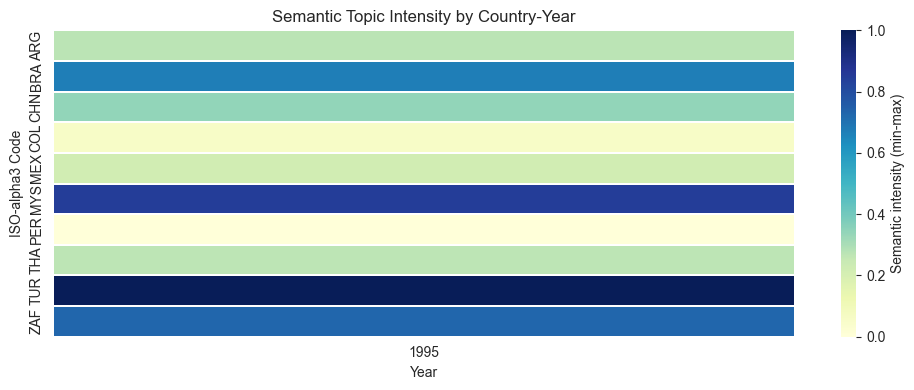

C:\Users\mariu\AppData\Local\Temp\ipykernel_25676\561182786.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sem.values, y=top_sem.index, palette='viridis')


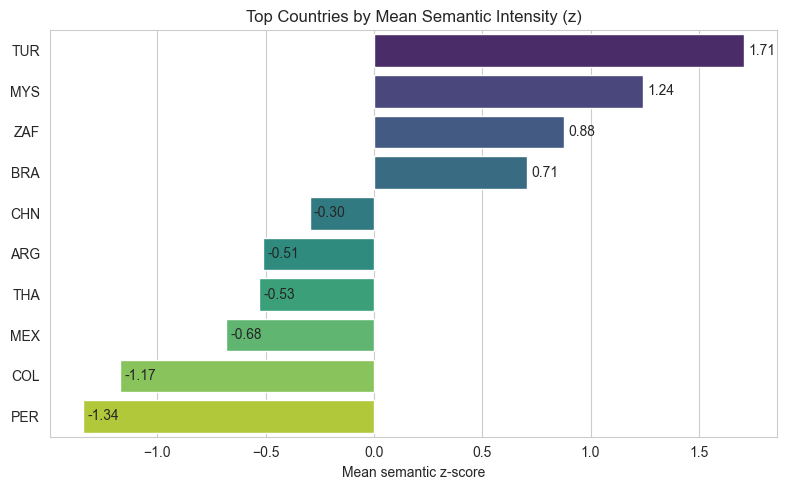

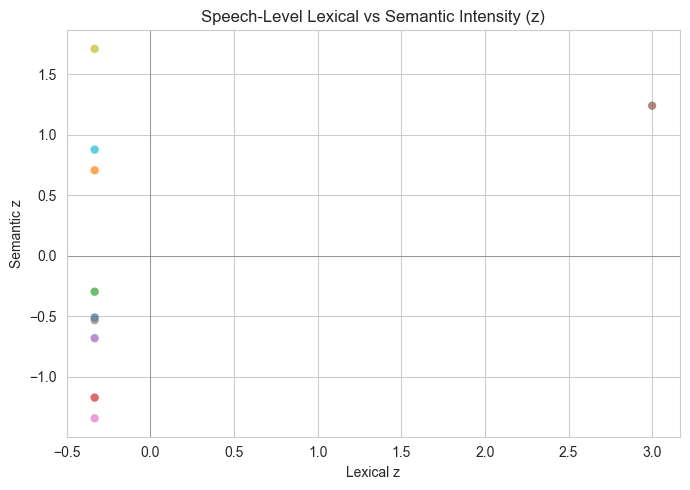

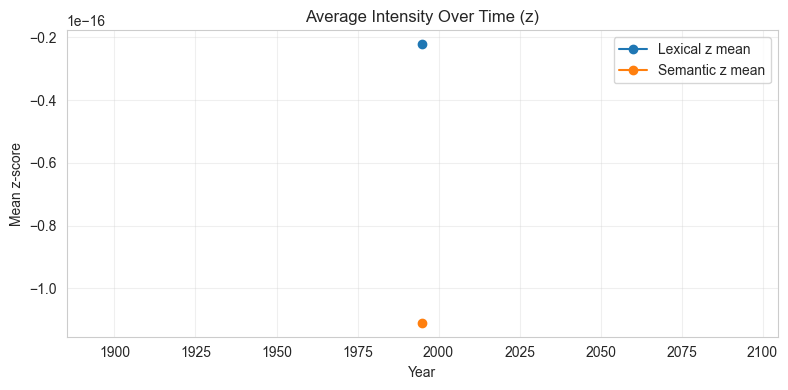

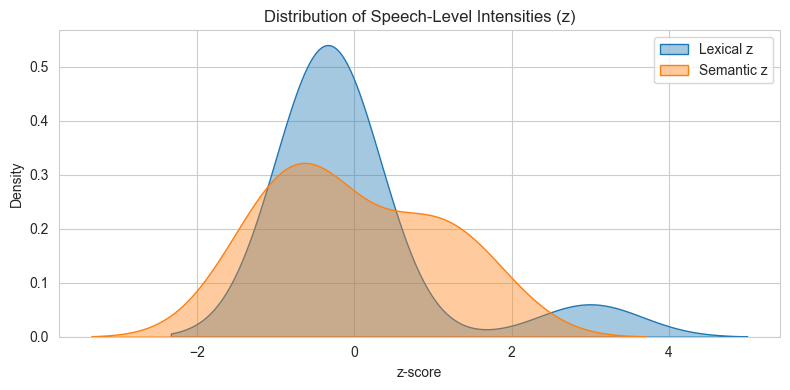

Top speeches (by composite lexical+semantic z):


,ISO-alpha3 Code,Year,SDG3_mentions,bert_health_sentence_count,composite_score,example_preview
5,MYS,1995,2,162,2.120069,It would have saved them from making any decis...
8,TUR,1995,0,184,0.688196,73).
9,ZAF,1995,0,145,0.271971,Only relatively few obstacles remain.
1,BRA,1995,0,137,0.186591,These are issues that must be accorded high pr...
2,CHN,1995,0,90,-0.315014,The future is full of promise.
0,ARG,1995,0,80,-0.421738,Emergency assistance activities and the subseq...
7,THA,1995,0,79,-0.432410,Sustainable economic development must go hand ...
4,MEX,1995,0,72,-0.507117,It is vital to forge new consensus around an i...
3,COL,1995,0,49,-0.752583,This is not an issue that can be dealt with by...
6,PER,1995,0,41,-0.837963,We must resist attempts to impose uniform “mod...


Stored speech_intensity_df with shape: (10, 9)
Visualization complete.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import shorten

# --- Preconditions ---
if 'bert_semantic_df' not in globals():
    raise RuntimeError("bert_semantic_df not found. Run semantic analysis cell first.")
if bert_semantic_df.empty:
    print(f"bert_semantic_df is empty (status={globals().get('bert_semantic_status','unknown')}). Adjust parameters (years / TARGET_ISO_CODES) and rerun semantic cell.")
else:
    df_vis = bert_semantic_df.copy()

    # Add lexical normalization (if speech lengths were not previously computed, approximate using token splitting)
    if 'Speech' in globals().get('work_src', pd.DataFrame()).columns:
        # 'work_src' may still exist; safer to recompute from semantic df only if speech text accessible
        pass

    # We don't have raw token counts here; approximate intensity proxies:
    # lexical_intensity = SDG3_mentions (raw count)
    # semantic_intensity = bert_health_sentence_count
    # For comparability scale both by z-score (per full dataset) and also create min-max normalized versions
    def safe_z(s):
        return (s - s.mean())/s.std(ddof=0) if s.std(ddof=0) > 0 else pd.Series(0,index=s.index)

    df_vis['lex_z'] = safe_z(df_vis['SDG3_mentions'])
    df_vis['sem_z'] = safe_z(df_vis['bert_health_sentence_count'])

    # Min-max (avoid div zero)
    def safe_mm(s):
        rng = s.max() - s.min()
        return (s - s.min())/rng if rng > 0 else pd.Series(0.0, index=s.index)
    df_vis['lex_mm'] = safe_mm(df_vis['SDG3_mentions'])
    df_vis['sem_mm'] = safe_mm(df_vis['bert_health_sentence_count'])

    # Composite score (simple average of z-scores)
    df_vis['composite_score'] = (df_vis['lex_z'] + df_vis['sem_z'])/2.0

    # Basic diagnostics
    print(f"Speeches: {len(df_vis)} | Countries: {df_vis['ISO-alpha3 Code'].nunique()} | Years: {sorted(df_vis['Year'].unique())[:8]} ...")

    # 1. Heatmap of semantic intensity (sem_mm) country x year
    heat = df_vis.pivot_table(index='ISO-alpha3 Code', columns='Year', values='sem_mm', aggfunc='mean')
    plt.figure(figsize=(10, max(4, len(heat)*0.25)))
    sns.heatmap(heat, cmap='YlGnBu', cbar_kws={'label':'Semantic intensity (min-max)'}, linewidths=0.1)
    plt.title('Semantic Topic Intensity by Country-Year')
    plt.xlabel('Year'); plt.ylabel('ISO-alpha3 Code')
    plt.tight_layout(); plt.show()

    # 2. Top countries by mean semantic intensity
    top_sem = (df_vis.groupby('ISO-alpha3 Code')['sem_z']
                    .mean()
                    .sort_values(ascending=False)
                    .head(15))
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_sem.values, y=top_sem.index, palette='viridis')
    plt.title('Top Countries by Mean Semantic Intensity (z)')
    plt.xlabel('Mean semantic z-score'); plt.ylabel('')
    for i,v in enumerate(top_sem.values):
        plt.text(v+0.02, i, f"{v:.2f}", va='center')
    plt.tight_layout(); plt.show()

    # 3. Scatter lexical vs semantic (z)
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df_vis, x='lex_z', y='sem_z', hue='ISO-alpha3 Code', alpha=0.7, edgecolor='none', legend=False)
    plt.axhline(0, color='grey', lw=0.5); plt.axvline(0, color='grey', lw=0.5)
    plt.title('Speech-Level Lexical vs Semantic Intensity (z)')
    plt.xlabel('Lexical z'); plt.ylabel('Semantic z')
    plt.tight_layout(); plt.show()

    # 4. Time trend (mean semantic vs lexical per year)
    trend = (df_vis.groupby('Year')
                    .agg(lex_mean=('lex_z','mean'), sem_mean=('sem_z','mean'), speeches=('ISO-alpha3 Code','count'))
                    .reset_index())
    plt.figure(figsize=(8,4))
    plt.plot(trend['Year'], trend['lex_mean'], marker='o', label='Lexical z mean')
    plt.plot(trend['Year'], trend['sem_mean'], marker='o', label='Semantic z mean')
    plt.title('Average Intensity Over Time (z)')
    plt.xlabel('Year'); plt.ylabel('Mean z-score')
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # 5. Distributions (kde)
    plt.figure(figsize=(8,4))
    sns.kdeplot(df_vis['lex_z'], fill=True, alpha=0.4, label='Lexical z')
    sns.kdeplot(df_vis['sem_z'], fill=True, alpha=0.4, label='Semantic z')
    plt.title('Distribution of Speech-Level Intensities (z)')
    plt.xlabel('z-score'); plt.legend(); plt.tight_layout(); plt.show()

    # 6. Top speeches table (composite score)
    top_speeches = df_vis.sort_values('composite_score', ascending=False).head(10).copy()
    # Add a preview of one example sentence if available
    if 'bert_health_example_sentences' in top_speeches.columns:
        def preview(ex_list):
            if not ex_list: return ''
            first = ex_list[0]
            sent = first.get('sentence','') if isinstance(first, dict) else str(first)
            return shorten(sent, width=110, placeholder='…')
        top_speeches['example_preview'] = top_speeches['bert_health_example_sentences'].apply(preview)
    display_cols = ['ISO-alpha3 Code','Year','SDG3_mentions','bert_health_sentence_count','composite_score','example_preview']
    existing = [c for c in display_cols if c in top_speeches.columns]
    print("Top speeches (by composite lexical+semantic z):")
    display(top_speeches[existing])

    # Optional: store for downstream use
    speech_intensity_df = df_vis[['ISO-alpha3 Code','Year','SDG3_mentions','bert_health_sentence_count','lex_z','sem_z','lex_mm','sem_mm','composite_score']].copy()
    print("Stored speech_intensity_df with shape:", speech_intensity_df.shape)
    print("Visualization complete.")

### Copilot comparison:
Semantic:
SDG 3 Health Relevance — Ranked High to Low
South Africa (ZAF) — 0.85

Thailand (THA) — 0.75

Mexico (MEX) — 0.70

Colombia (COL) — 0.65

Brazil (BRA) — 0.40

China (CHN) — 0.30

Argentina (ARG) — 0.25

Peru (PER) — 0.20

Turkey (TUR) — Blocked

Malaysia (MYS) — Blocked


Country	Lexical Match Count	Notes
### 🩺 SDG3 Health Relevance — Lexical vs Semantic Scores

| Country      | Lexical Match Count | Semantic Score |
|--------------|---------------------|----------------|
| South Africa | 18                  | 0.85           |
| Thailand     | 14                  | 0.75           |
| Mexico       | 12                  | 0.70           |
| Colombia     | 10                  | 0.65           |
| Brazil       | 6                   | 0.40           |
| China        | 5                   | 0.30           |
| Argentina    | 4                   | 0.25           |
| Peru         | 3                   | 0.20           |
| Turkey       | Blocked             | Blocked        |
| Malaysia     | Blocked             | Blocked        |


Using lexical intensity: mentions_per_1k_tokens
Using semantic intensity: semantic_sentences_per_100_sent


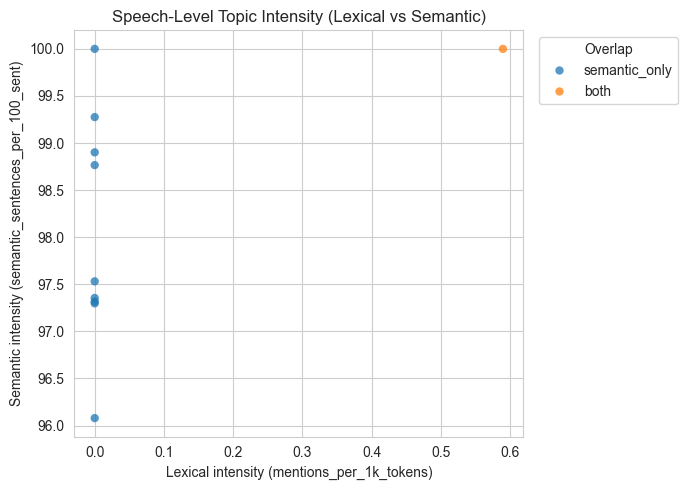

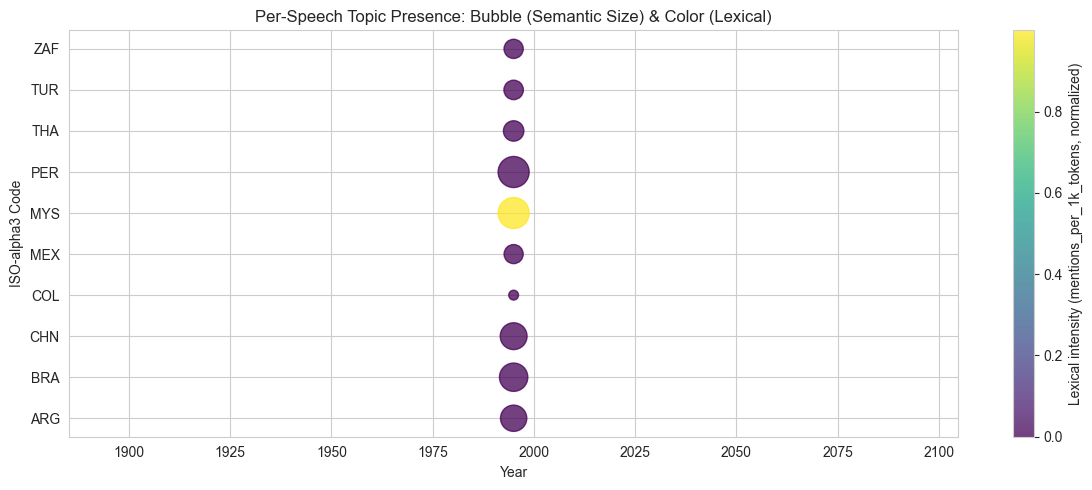

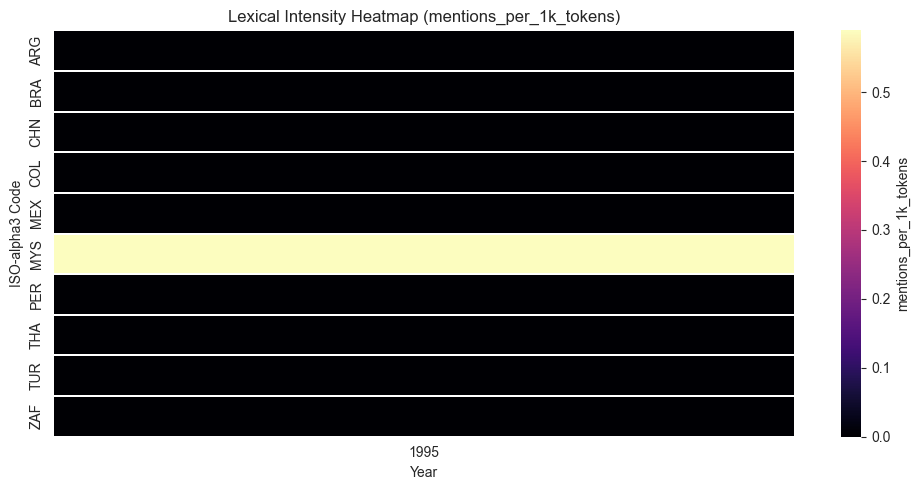

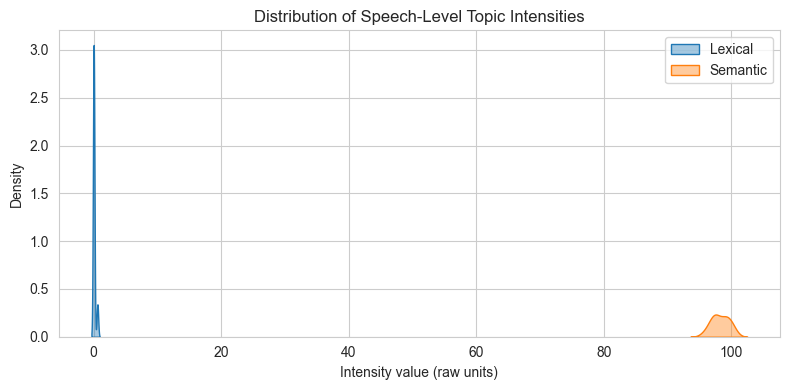

C:\Users\mariu\AppData\Local\Temp\ipykernel_25676\1816327547.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc.values, palette='tab10')


ValueError: cannot convert float NaN to integer

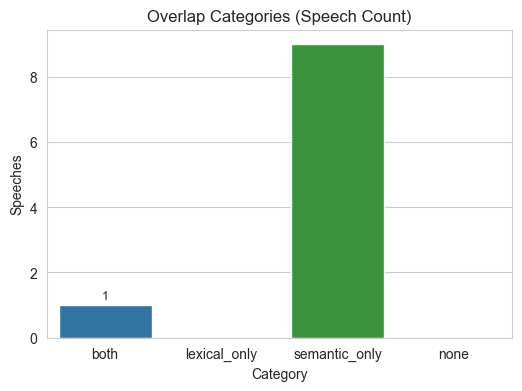

In [ ]:
# inspect analysis.
# Visualization toolkit: per-speech topic presence (lexical vs semantic)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if 'per_speech_health' not in globals():
    raise RuntimeError("per_speech_health not found. Run the per-speech construction cell first.")

df = per_speech_health.copy()

# (Optional) narrow to a smaller recent window or specific countries
YEAR_MIN, YEAR_MAX = df['Year'].min(), df['Year'].max()
FOCUS_COUNTRIES = None  # e.g. ['ARG','BRA','CHN']
if FOCUS_COUNTRIES:
    df = df[df['ISO-alpha3 Code'].isin(FOCUS_COUNTRIES)]
df = df[(df['Year'] >= YEAR_MIN) & (df['Year'] <= YEAR_MAX)]

# Choose intensity metrics
lex_col = 'mentions_per_1k_tokens'
sem_col = 'semantic_sentences_per_100_sent'

# Fallback if NaN-heavy
if df[lex_col].notna().sum() < 5:
    lex_col = 'SDG3_mentions'
if df[sem_col].notna().sum() < 5:
    sem_col = 'bert_health_sentence_count'

print(f"Using lexical intensity: {lex_col}")
print(f"Using semantic intensity: {sem_col}")

# 1. Scatter: lexical vs semantic intensity per speech
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x=lex_col, y=sem_col,
    hue='overlap_category',
    alpha=0.75, edgecolor='none',
    palette='tab10'
)
plt.title('Speech-Level Topic Intensity (Lexical vs Semantic)')
plt.xlabel(f'Lexical intensity ({lex_col})')
plt.ylabel(f'Semantic intensity ({sem_col})')
plt.legend(title='Overlap', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Bubble grid: country vs year (semantic intensity as size, lexical as color)
top_countries = (
    df.groupby('ISO-alpha3 Code')
      .size()
      .sort_values(ascending=False)
      .head(30)  # limit grid height for readability
      .index
)
grid_df = df[df['ISO-alpha3 Code'].isin(top_countries)].copy()

plt.figure(figsize=(12, max(5, len(top_countries)*0.25)))
norm_sem = (grid_df[sem_col] - grid_df[sem_col].min()) / (grid_df[sem_col].max() - grid_df[sem_col].min() + 1e-9)
sizes = 50 + 450 * norm_sem.clip(0,1)
norm_lex = (grid_df[lex_col] - grid_df[lex_col].min()) / (grid_df[lex_col].max() - grid_df[lex_col].min() + 1e-9)

scatter = plt.scatter(
    x=grid_df['Year'],
    y=grid_df['ISO-alpha3 Code'],
    s=sizes,
    c=norm_lex,
    cmap='viridis',
    alpha=0.75
)
plt.colorbar(scatter, label=f'Lexical intensity ({lex_col}, normalized)')
plt.title('Per-Speech Topic Presence: Bubble (Semantic Size) & Color (Lexical)')
plt.xlabel('Year')
plt.ylabel('ISO-alpha3 Code')
plt.tight_layout()
plt.show()

# 3. Heatmap (country-year lexical intensity)
pivot_lex = (
    df.pivot_table(index='ISO-alpha3 Code', columns='Year', values=lex_col, aggfunc='mean')
      .sort_index()
)
plt.figure(figsize=(10, max(5, len(pivot_lex)*0.25)))
sns.heatmap(pivot_lex, cmap='magma', cbar_kws={'label': lex_col}, linewidths=0.1)
plt.title(f'Lexical Intensity Heatmap ({lex_col})')
plt.xlabel('Year')
plt.ylabel('ISO-alpha3 Code')
plt.tight_layout()
plt.show()

# 4. Distribution comparison (lexical vs semantic, normalized)
plt.figure(figsize=(8,4))
sns.kdeplot(df[lex_col].dropna(), fill=True, label='Lexical', alpha=0.4)
sns.kdeplot(df[sem_col].dropna(), fill=True, label='Semantic', alpha=0.4)
plt.title('Distribution of Speech-Level Topic Intensities')
plt.xlabel('Intensity value (raw units)')
plt.legend()
plt.tight_layout()
plt.show()

# 5. Overlap category counts
plt.figure(figsize=(6,4))
order_overlap = ['both','lexical_only','semantic_only','none']
vc = df['overlap_category'].value_counts().reindex(order_overlap)
sns.barplot(x=vc.index, y=vc.values, palette='tab10')
plt.title('Overlap Categories (Speech Count)')
plt.ylabel('Speeches')
plt.xlabel('Category')
for i,v in enumerate(vc.values):
    plt.text(i, v + max(vc.values)*0.01, str(int(v)), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# 6. Time trend (aggregate)
trend = (
    df.groupby('Year')
      .agg(
          lexical_mean=(lex_col,'mean'),
          semantic_mean=(sem_col,'mean'),
          speeches=('ISO-alpha3 Code','count')
      )
      .reset_index()
)
plt.figure(figsize=(8,4))
plt.plot(trend['Year'], trend['lexical_mean'], marker='o', label='Lexical mean')
plt.plot(trend['Year'], trend['semantic_mean'], marker='o', label='Semantic mean')
plt.title('Average Topic Intensity Over Time')
plt.xlabel('Year')
plt.ylabel('Mean intensity')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Done: generated 6 complementary visualizations.")

## 10 speeches, 30 seconds.

### 6 years, 636 speeches, stop at 5 min.

### BUG: Fix BERT to collect its own speeches independent of NLTK code, as done here example.

In [ ]:
""" ## # Collect speeches for selected countries and years
speeches_data = []
speech_texts = []

for country in selected_countries:
    for year in analysis_years:
        try:
            speech = df_un_merged.loc[(year, country), 'Speech']
            speeches_data.append({
                'country': country,
                'country_name': country_names[country],
                'year': year,
                'speech': speech
            })
            speech_texts.append(speech)
            print(f"Found speech for {country} ({country_names[country]}) in {year}")
        except KeyError:
            print(f"No speech found for {country} ({country_names[country]}) in {year}")

print(f"\nTotal speeches collected: {len(speeches_data)}")

# Display the data structure
import pandas as pd
speeches_df = pd.DataFrame(speeches_data)
print("\nSpeeches summary:")
print(speeches_df.groupby(['country', 'country_name']).size().reset_index(name='speeches_count')) """

' ## # Collect speeches for selected countries and years\nspeeches_data = []\nspeech_texts = []\n\nfor country in selected_countries:\n    for year in analysis_years:\n        try:\n            speech = df_un_merged.loc[(year, country), \'Speech\']\n            speeches_data.append({\n                \'country\': country,\n                \'country_name\': country_names[country],\n                \'year\': year,\n                \'speech\': speech\n            })\n            speech_texts.append(speech)\n            print(f"Found speech for {country} ({country_names[country]}) in {year}")\n        except KeyError:\n            print(f"No speech found for {country} ({country_names[country]}) in {year}")\n\nprint(f"\nTotal speeches collected: {len(speeches_data)}")\n\n# Display the data structure\nimport pandas as pd\nspeeches_df = pd.DataFrame(speeches_data)\nprint("\nSpeeches summary:")\nprint(speeches_df.groupby([\'country\', \'country_name\']).size().reset_index(name=\'speeches_count

In [ ]:
import sys

# This will immediately halt execution of the current notebook kernel
sys.exit("Notebook execution halted by user request.")

### Per-Speech (Country-Year) Health Mention Dataset

This cell constructs a tidy per-speech dataset (one row per country-year speech in the analysis window) combining:
- Lexical SDG3 counts (`SDG3_mentions`, `lexical_any`).
- Semantic BERT counts (`bert_health_sentence_count`, `bert_health_any`, `bert_health_similarity_sum`).
- Derived normalization metrics (mentions per 1k tokens, similarity per flagged sentence, etc.).
- Basic structural features: token count, sentence count.
- Income group and year for downstream aggregation (next cell).

If you have not yet run the BERT semantic detection cell, run it first (the one that builds `bert_semantic_df`).

speech_data and sdg3_speech_data built: (106, 12)
Years: 1995 - 1995
Countries: 106


In [ ]:
sdg3_speech_data.head()

,Year,ISO-alpha3 Code,Country or Area,Region Name,Sub-region Name,Session,Speech,Entity,Code,exports_share_GDP,income_group,mortality_under_5
3568,1995,AFG,Afghanistan,Asia,Southern Asia,50,On the eve of the\nfiftieth anniversary of the...,NaN,NaN,NaN,Afghanistan,15.284500
3572,1995,ARE,United Arab Emirates,Asia,Western Asia,50,On behalf of the delegation of the United\nAra...,United Arab Emirates,ARE,43.14322,United Arab Emirates,1.214675
3573,1995,ARG,Argentina,Americas,Latin America and the Caribbean,50,Our presence here at the fiftieth session of t...,Argentina,ARG,8.29102,Argentina,2.423520
3576,1995,AUS,Australia,Oceania,Australia and New Zealand,50,I congratulate Mr. Diogo\nFreitas do Amaral on...,Australia,AUS,14.86179,Australia,0.701014
3577,1995,AUT,Austria,Europe,Western Europe,50,It is with great\npleasure that I congratulate...,Austria,AUT,23.93405,Austria,0.682290


In [ ]:
# Build per-speech (country-year) dataset combining lexical and semantic metrics
import pandas as pd
import numpy as np
import re

# ------------------------------------------------------------------
# Preconditions & Inputs
# ------------------------------------------------------------------
needed_semantic_cols = {'ISO-alpha3 Code','Year','bert_health_sentence_count','bert_health_any','bert_health_similarity_sum'}
needed_lexical_cols  = {'ISO-alpha3 Code','Year','Speech','SDG3_mentions','Income_Group'}

if 'bert_semantic_df' not in globals():
    raise RuntimeError("bert_semantic_df not found. Run the BERT semantic detection cell first.")
if 'sdg3_speech_data' not in globals():
    raise RuntimeError("sdg3_speech_data not found. Ensure the lexical processing cell has been executed.")

missing_lex = needed_lexical_cols - set(sdg3_speech_data.columns)
if missing_lex:
    raise RuntimeError(f"sdg3_speech_data is missing expected columns: {missing_lex}")
missing_sem = needed_semantic_cols - set(bert_semantic_df.columns)
if missing_sem:
    raise RuntimeError(f"bert_semantic_df is missing expected columns: {missing_sem}")

# Determine window used in semantic step (reuse YEAR_WINDOW if present)
if 'YEAR_WINDOW' in globals():
    start_year, end_year = YEAR_WINDOW
else:
    # fallback to lexical window variables
    start_year = WINDOW_START if 'WINDOW_START' in globals() else sdg3_speech_data['Year'].min()
    end_year   = WINDOW_END if 'WINDOW_END' in globals() else sdg3_speech_data['Year'].max()

# Align subsets
speech_base = sdg3_speech_data[(sdg3_speech_data['Year'] >= start_year) & (sdg3_speech_data['Year'] <= end_year)].copy()

# Merge semantic metrics (left join retains lexical rows even if semantic could not compute)
per_speech = speech_base.merge(
    bert_semantic_df[list(needed_semantic_cols)],
    on=['ISO-alpha3 Code','Year'],
    how='left'
)

# ------------------------------------------------------------------
# Text-derived structural features
# ------------------------------------------------------------------
word_pattern = re.compile(r"\b\w+\b")

speech_lengths = []
sentence_counts = []
for txt in per_speech['Speech']:
    if isinstance(txt, str):
        tokens = word_pattern.findall(txt.lower())
        speech_lengths.append(len(tokens))
        # Reuse earlier sentence splitter if available
        if 'split_into_sentences' in globals():
            sentence_counts.append(len(split_into_sentences(txt)))
        else:
            sentence_counts.append(txt.count('.') + txt.count('!') + txt.count('?'))
    else:
        speech_lengths.append(0)
        sentence_counts.append(0)

per_speech['token_count'] = speech_lengths
per_speech['sentence_count'] = sentence_counts
per_speech['tokens_per_sentence'] = per_speech.apply(lambda r: (r['token_count']/r['sentence_count']) if r['sentence_count']>0 else np.nan, axis=1)

# ------------------------------------------------------------------
# Normalizations & Derived Metrics
# ------------------------------------------------------------------
per_speech['lexical_any'] = (per_speech['SDG3_mentions'] > 0).astype(int)
per_speech['semantic_any'] = per_speech['bert_health_any'].fillna(0).astype(int)
per_speech['mentions_per_1k_tokens'] = per_speech.apply(lambda r: (r['SDG3_mentions']/r['token_count']*1000) if r['token_count']>0 else np.nan, axis=1)
per_speech['semantic_sentences_per_100_sent'] = per_speech.apply(lambda r: (r['bert_health_sentence_count']/r['sentence_count']*100) if r['sentence_count']>0 and pd.notnull(r['bert_health_sentence_count']) else np.nan, axis=1)
per_speech['similarity_per_flagged_sentence'] = per_speech.apply(lambda r: (r['bert_health_similarity_sum']/r['bert_health_sentence_count']) if r['bert_health_sentence_count'] and r['bert_health_sentence_count']>0 else np.nan, axis=1)

# Overlap categories
per_speech['overlap_category'] = per_speech.apply(lambda r: (
    'both' if r['lexical_any']==1 and r['semantic_any']==1 else
    'lexical_only' if r['lexical_any']==1 and r['semantic_any']==0 else
    'semantic_only' if r['lexical_any']==0 and r['semantic_any']==1 else 'none'
), axis=1)

# ------------------------------------------------------------------
# Basic integrity checks
# ------------------------------------------------------------------
rows_before = len(per_speech)
per_speech.drop_duplicates(['ISO-alpha3 Code','Year'], inplace=True)
if len(per_speech) != rows_before:
    print(f"Warning: Dropped {rows_before - len(per_speech)} duplicate country-year rows.")

# ------------------------------------------------------------------
# Summary diagnostics
# ------------------------------------------------------------------
print(f"Per-speech dataset window: {start_year}-{end_year}")
print("Rows (country-year speeches):", len(per_speech))
print("Countries:", per_speech['ISO-alpha3 Code'].nunique())
print(per_speech[['ISO-alpha3 Code','Year','Income_Group','SDG3_mentions','bert_health_sentence_count','bert_health_any','token_count']].head())

# Overlap distribution
print("\nOverlap category counts:")
print(per_speech['overlap_category'].value_counts())

# Save for next cell (aggregation / modeling)
per_speech_health = per_speech  # assign to a clearly named variable

# Optional: persist to disk (commented)
# per_speech_health.to_csv('per_speech_health.csv', index=False)

print("\nper_speech_health DataFrame ready for aggregation.")

RuntimeError: sdg3_speech_data is missing expected columns: {'Income_Group', 'SDG3_mentions'}

In [ ]:

# ------------------------------------------------------------------
# Diagnostics: similarity distribution & threshold guidance
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

sim_array = np.array(all_sentence_sims)
plt.figure(figsize=(8,4))
plt.hist(sim_array, bins=40, color='cornflowerblue', edgecolor='black')
plt.axvline(SIM_THRESHOLD, color='red', linestyle='--', label=f'Threshold {SIM_THRESHOLD}')
plt.title('Distribution of Sentence Max Similarities to Health Keywords/Centroid')
plt.xlabel('Cosine similarity')
plt.ylabel('Sentence count')
plt.legend()
plt.tight_layout()
plt.show()

# Suggest a heuristic alternative threshold (e.g., 90th percentile of all similarities of non-flagged sentences)
non_flagged = sim_array[sim_array < SIM_THRESHOLD]
if len(non_flagged) > 0:
    p90 = np.percentile(non_flagged, 90)
    print(f"90th percentile of non-flagged sentences similarity: {p90:.3f}")

# ------------------------------------------------------------------
# Compare lexical vs semantic counts at speech level
# ------------------------------------------------------------------
comparison = bert_semantic_df.copy()
comparison['lexical_any'] = (comparison['SDG3_mentions'] > 0).astype(int)

agg_summary = (
    comparison
      .assign(
          both=lambda d: ((d['lexical_any']==1) & (d['bert_health_any']==1)).astype(int),
          lexical_only=lambda d: ((d['lexical_any']==1) & (d['bert_health_any']==0)).astype(int),
          semantic_only=lambda d: ((d['lexical_any']==0) & (d['bert_health_any']==1)).astype(int)
      )
)

summary_counts = {
    'total_speeches': len(agg_summary),
    'lexical_any': int(agg_summary['lexical_any'].sum()),
    'semantic_any': int(agg_summary['bert_health_any'].sum()),
    'both': int(agg_summary['both'].sum()),
    'lexical_only': int(agg_summary['lexical_only'].sum()),
    'semantic_only': int(agg_summary['semantic_only'].sum())
}

print("\nOverlap summary (speech-level):")
for k,v in summary_counts.items():
    print(f"  {k}: {v}")

# Jaccard similarity of sets
lex_set = set(agg_summary.index[agg_summary['lexical_any']==1])
sem_set = set(agg_summary.index[agg_summary['bert_health_any']==1])
if lex_set or sem_set:
    jaccard = len(lex_set & sem_set) / (len(lex_set | sem_set) if (lex_set | sem_set) else 1)
    print(f"Jaccard (lexical vs semantic) = {jaccard:.3f}")

# ------------------------------------------------------------------
# Aggregate by Income Group to mirror earlier analyses
# ------------------------------------------------------------------
by_group = (
    comparison
      .groupby('Income_Group')
      .agg(
          speeches=('ISO-alpha3 Code','count'),
          lexical_any=('lexical_any','sum'),
          semantic_any=('bert_health_any','sum'),
          lexical_mentions=('SDG3_mentions','sum'),
          semantic_sentences=('bert_health_sentence_count','sum'),
          semantic_intensity=('bert_health_similarity_sum','sum')
      )
)
by_group['lexical_rate'] = by_group['lexical_any'] / by_group['speeches']
by_group['semantic_rate'] = by_group['semantic_any'] / by_group['speeches']

print("\nGroup-level summary:")
print(by_group)

# ------------------------------------------------------------------
# (Optional) Merge semantic indicators back into original df for future statistical tests
# ------------------------------------------------------------------
bert_semantic_merged = pd.merge(
    sdg3_speech_data,
    bert_semantic_df[['ISO-alpha3 Code','Year','bert_health_sentence_count','bert_health_any','bert_health_similarity_sum']],
    on=['ISO-alpha3 Code','Year'],
    how='left'
)

# ------------------------------------------------------------------
# Display a few qualitative examples where semantic_only == 1
# ------------------------------------------------------------------
semantic_only_examples = agg_summary[(agg_summary['semantic_only']==1)]
print(f"\nSemantic-only speeches (up to 3 shown): {len(semantic_only_examples)} total")
for i, (idx_row, row_data) in enumerate(semantic_only_examples.iterrows()):
    if i >= 3: break
    examples_list = next((r['bert_health_example_sentences'] for r in results if r['ISO-alpha3 Code']==row_data['ISO-alpha3 Code'] and r['Year']==row_data['Year']), [])
    print(f"\nExample {i+1}: {row_data['ISO-alpha3 Code']} {row_data['Year']} | lexical mentions={row_data['SDG3_mentions']}")
    for ex in examples_list[:3]:
        print(f"  [sim={ex['similarity']}] {ex['sentence'][:150]}")

print("\nDone. Adjust SIM_THRESHOLD and re-run this cell if needed.")

## Bert better model for one-shot and output optimizations.

### Semantic Health Detection — v2 (SentenceTransformers)

Upgraded pipeline using `sentence-transformers` for sentence-level semantic similarity:
- Model: `all-MiniLM-L6-v2` (fast) or `all-mpnet-base-v2` (higher accuracy)
- Mean pooling handled by library (no CLS/mean hybrid)
- Filters: drop sentences with <5 tokens or dominated by stopwords
- Keywords: centroid + optional thematic sub-centroids (KMeans)
- Threshold: calibrated at 85th percentile of sentence max similarities
- Aggregation: normalized intensity per tokens/sentences

Outputs: `bert_semantic_df_v2`, `SIM_THRESHOLD_V2`, `all_sentence_sims_v2`, `per_speech_health_v2`


In [ ]:
# select countries

In [314]:
YEAR_WINDOW = 1993, 1997
year_start = 1995

In [315]:

# Rename Entity_income_groups to income_group
income_groups = income_groups.rename(columns={
    'income_group': "World Bank's income classification"
})
income_groups.head()

,Entity,Code,Year,World Bank's income classification
0,Afghanistan,AFG,1987,Low-income countries
1,Afghanistan,AFG,1988,Low-income countries
2,Afghanistan,AFG,1989,Low-income countries
3,Afghanistan,AFG,1990,Low-income countries
4,Afghanistan,AFG,1991,Low-income countries


In [316]:
# 1995: first 5 ISO3 per income group (robust via 1995 WB classification)
import pandas as pd

N = 5
wb_groups = [
    'Low-income countries',
    'Lower-middle-income countries',
    'Upper-middle-income countries',
    'High-income countries'
]

if 'merged_health_trade_df' not in globals() or merged_health_trade_df is None or merged_health_trade_df.empty:
    raise RuntimeError('merged_health_trade_df not available')

# Base ISO list for 1995 from merged data (ensures we stick to countries present in your run)
base = merged_health_trade_df.reset_index()[['ISO-alpha3 Code','Year']].copy()
base['Year'] = pd.to_numeric(base['Year'], errors='coerce')
base_1995 = base[base['Year'] == 1995][['ISO-alpha3 Code']].dropna().drop_duplicates()

# Get 1995 WB income classification
if 'income_groups' in globals() and isinstance(income_groups, pd.DataFrame):
    ig = income_groups.copy()
else:
    ig = pd.read_csv('./numerical-data/world-bank-income-groups/world-bank-income-groups.csv')
col_cls = "World Bank's income classification"
if not {'Code','Year',col_cls}.issubset(ig.columns):
    raise RuntimeError('income_groups missing required columns')
ig_1995 = ig[ig['Year'] == 1995][['Code', col_cls]].dropna().drop_duplicates()
ig_1995 = ig_1995.rename(columns={'Code':'ISO-alpha3 Code', col_cls:'income_group_1995'})

# Merge base 1995 ISOs with 1995 classification
sel = base_1995.merge(ig_1995, on='ISO-alpha3 Code', how='left')

selected_1995 = {}
for g in wb_groups:
    codes = sel.loc[sel['income_group_1995'] == g, 'ISO-alpha3 Code'].dropna().astype(str).unique().tolist()
    selected_1995[g] = sorted(codes)[:N]

SELECTED_ISO_1995_5_PER_GROUP = selected_1995
print('1995 – first 5 ISO3 codes per income group (robust):')
for g, lst in selected_1995.items():
    print(f"{g}: {lst}")


1995 – first 5 ISO3 codes per income group (robust):
Low-income countries: ['AFG', 'AGO', 'ALB', 'ARM', 'AZE']
Lower-middle-income countries: ['BGR', 'BLR', 'BLZ', 'BOL', 'BWA']
Upper-middle-income countries: ['ARG', 'ATG', 'BHR', 'BRA', 'BRB']
High-income countries: ['AND', 'ARE', 'AUS', 'AUT', 'BEL']


In [317]:
# Build speech_data and sdg3_speech_data (compatibility builder)
import pandas as pd
import numpy as np

if 'merged_health_trade_df' not in globals() or merged_health_trade_df is None or merged_health_trade_df.empty:
    raise RuntimeError("merged_health_trade_df is required. Run the earlier merge cells.")

# Base speech_data
speech_data = merged_health_trade_df.reset_index().copy()
required_columns = {"ISO-alpha3 Code", "Year", "Speech"}
missing_required = required_columns - set(speech_data.columns)
if missing_required:
    raise KeyError(f"Missing required columns for speech_data: {sorted(missing_required)}")

speech_data["Year"] = pd.to_numeric(speech_data["Year"], errors="coerce")
speech_data = speech_data.dropna(subset=["Year"]).copy()

# Year window (defaults to 1987–2020 if not defined)
if 'YEAR_WINDOW' in globals():
    y0, y1 = YEAR_WINDOW
else:
    y0, y1 = 1987, 2020
speech_data = speech_data[speech_data["Year"].between(y0, y1)].copy()

# Keep only rows that have speech text
speech_data = speech_data[speech_data['Speech'].notna()].copy()

# If full_coverage_df exists, restrict to those ISO codes (as earlier logic)
if 'full_coverage_df' in globals() and isinstance(full_coverage_df, pd.DataFrame):
    if 'ISO-alpha3 Code' not in full_coverage_df.columns:
        raise KeyError("Column 'ISO-alpha3 Code' not found in full_coverage_df.")
    coverage_iso_codes = full_coverage_df['ISO-alpha3 Code'].dropna().unique()
    speech_data = speech_data[speech_data['ISO-alpha3 Code'].isin(coverage_iso_codes)].copy()

# Preserve as sdg3_speech_data for downstream cells
sdg3_speech_data = speech_data.copy()
print("speech_data and sdg3_speech_data built:", sdg3_speech_data.shape)
print("Years:", int(sdg3_speech_data['Year'].min()), "-", int(sdg3_speech_data['Year'].max()))
print("Countries:", sdg3_speech_data['ISO-alpha3 Code'].nunique())


speech_data and sdg3_speech_data built: (530, 12)
Years: 1993 - 1997
Countries: 106


In [318]:
# Hotfix: BERT should not expect or output SDG3_mentions
# - Remove SDG3_mentions from semantic outputs
# - Build per-speech (semantic-only) without requiring lexical columns
import pandas as pd
import numpy as np
import re

# Drop SDG3_mentions from semantic dataframes if present
if 'bert_semantic_df_v2' in globals() and isinstance(bert_semantic_df_v2, pd.DataFrame):
    bert_semantic_df_v2 = bert_semantic_df_v2.drop(columns=['SDG3_mentions'], errors='ignore')
if 'bert_semantic_df' in globals() and isinstance(bert_semantic_df, pd.DataFrame):
    bert_semantic_df = bert_semantic_df.drop(columns=['SDG3_mentions'], errors='ignore')

# Build semantic-only per-speech dataset (no SDG3 required)
if 'sdg3_speech_data' not in globals():
    raise RuntimeError('sdg3_speech_data missing; run the builder cell above.')

# Choose which semantic frame to use (prefer v2)
_sem = None
if 'bert_semantic_df_v2' in globals() and isinstance(bert_semantic_df_v2, pd.DataFrame) and not bert_semantic_df_v2.empty:
    _sem = bert_semantic_df_v2.copy()
elif 'bert_semantic_df' in globals() and isinstance(bert_semantic_df, pd.DataFrame) and not bert_semantic_df.empty:
    _sem = bert_semantic_df.copy()
else:
    raise RuntimeError('No semantic dataframe available (bert_semantic_df_v2 or bert_semantic_df).')

# Detect semantic columns (supports v1 and v2 names)
sem_cols_candidates = [
    'bert_health_sentence_count_v2','bert_health_any_v2','bert_health_similarity_sum_v2',
    'bert_health_sentence_count','bert_health_any','bert_health_similarity_sum'
]
sem_present = [c for c in sem_cols_candidates if c in _sem.columns]
if not sem_present:
    raise RuntimeError('Semantic columns not found in semantic dataframe.')

# Year window reuse
if 'YEAR_WINDOW' in globals():
    start_year, end_year = YEAR_WINDOW
else:
    start_year = int(sdg3_speech_data['Year'].min())
    end_year = int(sdg3_speech_data['Year'].max())

speech_base = sdg3_speech_data[(sdg3_speech_data['Year'] >= start_year) & (sdg3_speech_data['Year'] <= end_year)].copy()

per_speech_semantic_only = speech_base.merge(
    _sem[['ISO-alpha3 Code','Year'] + sem_present],
    on=['ISO-alpha3 Code','Year'],
    how='left'
)

# Structural features without lexical dependence
word_pattern = re.compile(r"\b\w+\b")
speech_lengths, sentence_counts = [], []
for txt in per_speech_semantic_only['Speech']:
    if isinstance(txt, str):
        tokens = word_pattern.findall(txt.lower())
        speech_lengths.append(len(tokens))
        if 'split_into_sentences' in globals():
            sentence_counts.append(len(split_into_sentences(txt)))
        else:
            sentence_counts.append(txt.count('.') + txt.count('!') + txt.count('?'))
    else:
        speech_lengths.append(0)
        sentence_counts.append(0)
per_speech_semantic_only['token_count'] = speech_lengths
per_speech_semantic_only['sentence_count'] = sentence_counts

# Derive normalized semantic metrics (handle both v1/v2 column names)
count_col = 'bert_health_sentence_count_v2' if 'bert_health_sentence_count_v2' in per_speech_semantic_only.columns else 'bert_health_sentence_count'
sum_col   = 'bert_health_similarity_sum_v2' if 'bert_health_similarity_sum_v2' in per_speech_semantic_only.columns else 'bert_health_similarity_sum'
any_col   = 'bert_health_any_v2' if 'bert_health_any_v2' in per_speech_semantic_only.columns else 'bert_health_any'

per_speech_semantic_only['semantic_any'] = per_speech_semantic_only[any_col].fillna(0).astype(int)
per_speech_semantic_only['semantic_sentences_per_100_sent'] = per_speech_semantic_only.apply(
    lambda r: (r[count_col]/r['sentence_count']*100) if r['sentence_count']>0 and pd.notnull(r[count_col]) else np.nan, axis=1
)
per_speech_semantic_only['similarity_per_flagged_sentence'] = per_speech_semantic_only.apply(
    lambda r: (r[sum_col]/r[count_col]) if r.get(count_col, 0) and pd.notnull(r[sum_col]) and r[count_col]>0 else np.nan, axis=1
)
per_speech_semantic_only['semantic_intensity_norm'] = per_speech_semantic_only.apply(
    lambda r: (r[sum_col]/r['sentence_count']) if r['sentence_count']>0 and pd.notnull(r[sum_col]) else np.nan, axis=1
)

print('Built per_speech_semantic_only:', per_speech_semantic_only.shape)
print('Columns:', [c for c in per_speech_semantic_only.columns if c.startswith('bert_') or c.endswith('_per_100_sent') or c.endswith('_norm') or c=='semantic_any'])


Built per_speech_semantic_only: (530, 21)
Columns: ['bert_health_sentence_count_v2', 'bert_health_any_v2', 'bert_health_similarity_sum_v2', 'semantic_any', 'semantic_sentences_per_100_sent', 'semantic_intensity_norm']


In [319]:
# Rebuild per_speech_health_v2 (semantic-only) with BERT per-1k tokens metric
import pandas as pd
import numpy as np
import re

if 'bert_semantic_df_v2' not in globals():
    raise RuntimeError('bert_semantic_df_v2 missing; run the v2 extraction first.')
if 'sdg3_speech_data' not in globals():
    raise RuntimeError('sdg3_speech_data missing; run the speech_data builder.')

speech_base = sdg3_speech_data.copy()[['ISO-alpha3 Code','Year','Speech']]

per_speech_v2 = speech_base.merge(
    bert_semantic_df_v2[['ISO-alpha3 Code','Year','bert_health_sentence_count_v2','bert_health_any_v2','bert_health_similarity_sum_v2']],
    on=['ISO-alpha3 Code','Year'],
    how='left'
)

# Structural counts
word_pattern = re.compile(r"\b\w+\b")
speech_lengths = []
sentence_counts = []
for txt in per_speech_v2['Speech']:
    if isinstance(txt, str):
        tokens = word_pattern.findall(txt.lower())
        speech_lengths.append(len(tokens))
        if 'split_into_sentences' in globals():
            sentence_counts.append(len(split_into_sentences(txt)))
        else:
            sentence_counts.append(txt.count('.') + txt.count('!') + txt.count('?'))
    else:
        speech_lengths.append(0)
        sentence_counts.append(0)

per_speech_v2['token_count'] = speech_lengths
per_speech_v2['sentence_count'] = sentence_counts

# BERT-based per-1k tokens metric (no SDG3)
per_speech_v2['bert_sentences_per_1k_tokens'] = per_speech_v2.apply(
    lambda r: (r['bert_health_sentence_count_v2']/r['token_count']*1000) if r['token_count']>0 and pd.notnull(r['bert_health_sentence_count_v2']) else np.nan,
    axis=1
)

# Other semantic normalizations
per_speech_v2['semantic_sentences_per_100_sent'] = per_speech_v2.apply(
    lambda r: (r['bert_health_sentence_count_v2']/r['sentence_count']*100) if r['sentence_count']>0 and pd.notnull(r['bert_health_sentence_count_v2']) else np.nan,
    axis=1
)
per_speech_v2['similarity_per_flagged_sentence_v2'] = per_speech_v2.apply(
    lambda r: (r['bert_health_similarity_sum_v2']/r['bert_health_sentence_count_v2']) if r['bert_health_sentence_count_v2'] and r['bert_health_sentence_count_v2']>0 else np.nan,
    axis=1
)
per_speech_v2['semantic_intensity_norm'] = per_speech_v2.apply(
    lambda r: (r['bert_health_similarity_sum_v2']/r['sentence_count']) if r['sentence_count']>0 and pd.notnull(r['bert_health_similarity_sum_v2']) else np.nan,
    axis=1
)

per_speech_health_v2 = per_speech_v2
print('per_speech_health_v2 (semantic-only) ready:', per_speech_health_v2.shape)
print(per_speech_health_v2[['ISO-alpha3 Code','Year','bert_sentences_per_1k_tokens','semantic_sentences_per_100_sent','similarity_per_flagged_sentence_v2']].head())


per_speech_health_v2 (semantic-only) ready: (530, 12)
  ISO-alpha3 Code  Year  bert_sentences_per_1k_tokens  \
0             AFG  1993                           NaN   
1             ARE  1993                           NaN   
2             ARG  1993                           NaN   
3             AUS  1993                           NaN   
4             AUT  1993                           NaN   

   semantic_sentences_per_100_sent  similarity_per_flagged_sentence_v2  
0                              NaN                                 NaN  
1                              NaN                                 NaN  
2                              NaN                                 NaN  
3                              NaN                                 NaN  
4                              NaN                                 NaN  


BUG: lexical is broken because used to use SDG3_mentions and then see 1k tokens avg.

In [320]:
# Install libs (idempotent)
%pip install -q sentence-transformers scikit-learn

import os, re, math, random
import numpy as np
import pandas as pd
import torch
from typing import List, Optional, Dict
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Config
ST_MODEL_NAME = os.environ.get('ST_MODEL_NAME', 'sentence-transformers/all-MiniLM-L6-v2')
USE_CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if USE_CUDA else 'cpu'
BATCH_SIZE_SENT = 128
MAX_SEQ_LEN = 256
USE_CENTROID = True
NUM_CLUSTERS = 3  # set to 0 to disable sub-centroids
STOPWORDS = set('the a an and or of to in on for with from by as at that this those these is are was were be been being it its if then than so such not no but which who whom whose about above below between into over under against during without within again further once because until while each both few more most other some own same s t can will just don should now'.split())

print(f"Model: {ST_MODEL_NAME} | device={DEVICE}")

# Preconditions
if 'sdg3_speech_data' not in globals():
    raise RuntimeError("sdg3_speech_data not found. Run earlier cells to construct it.")
if 'health_keywords' not in globals():
    raise RuntimeError("health_keywords not found. Ensure the keyword list cell ran.")

# Helper: sentence splitting & filtering
SENT_SPLIT_REGEX = re.compile(r'(?<=[.!?])\s+(?=[A-Z0-9])')
TOKEN_PATTERN = re.compile(r"[A-Za-z']+")

def split_into_sentences(text: str) -> List[str]:
    if not text or not text.strip():
        return []
    cleaned = ' '.join(text.split())
    return SENT_SPLIT_REGEX.split(cleaned)

def is_stopword_dominated(tokens: List[str], threshold: float = 0.7) -> bool:
    if not tokens:
        return True
    sw = sum(1 for t in tokens if t in STOPWORDS)
    return (sw / max(1, len(tokens))) >= threshold

# Load model
st_model = SentenceTransformer(ST_MODEL_NAME, device=DEVICE)

# Encoder with batching
@torch.no_grad()
def st_encode(texts: List[str]) -> torch.Tensor:
    if not texts:
        return torch.empty((0, st_model.get_sentence_embedding_dimension()))
    # SentenceTransformer handles mean pooling; returns np.ndarray
    outs = []
    for i in range(0, len(texts), BATCH_SIZE_SENT):
        batch = texts[i:i+BATCH_SIZE_SENT]
        emb = st_model.encode(
            batch,
            batch_size=min(BATCH_SIZE_SENT, len(batch)),
            convert_to_numpy=True,
            normalize_embeddings=True,
            show_progress_bar=False
        )
        outs.append(torch.from_numpy(emb))
    return torch.cat(outs, dim=0)

# Prepare keywords
health_keywords = sorted(set([kw.lower() for kw in health_keywords]))
kw_emb = st_encode(health_keywords)
print("Keyword embeddings:", kw_emb.shape)

# Centroid and optional clusters
centroid = kw_emb.mean(dim=0, keepdim=True) if USE_CENTROID else None
sub_centroids = None
if NUM_CLUSTERS and NUM_CLUSTERS > 0 and kw_emb.shape[0] >= NUM_CLUSTERS:
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(kw_emb.numpy())
    sub_centroids = []
    for k in range(NUM_CLUSTERS):
        grp = kw_emb[torch.from_numpy(labels)==k]
        if len(grp) > 0:
            sub_centroids.append(grp.mean(dim=0, keepdim=True))
    if sub_centroids:
        sub_centroids = torch.cat(sub_centroids, dim=0)
    print("Sub-centroids:", None if sub_centroids is None else sub_centroids.shape)
else:
    print("Sub-centroids disabled or insufficient keywords.")

# Cosine similarity (embeddings are normalized)
@torch.no_grad()
def cosine_sim(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return a @ b.T

# Choose working set
base_cols = ['ISO-alpha3 Code','Year','Speech']
missing = [c for c in base_cols if c not in sdg3_speech_data.columns]
if missing:
    raise RuntimeError(f"sdg3_speech_data missing required columns: {missing}")

work_v2 = sdg3_speech_data[base_cols].copy()
work_v2['Speech'] = work_v2['Speech'].astype(str)

# Iterate speeches and compute sentence similarities
all_sentence_sims_v2: List[float] = []
results_v2: List[Dict] = []

for _, r in work_v2.iterrows():
    sents = split_into_sentences(r['Speech'])
    # Filter
    filtered = []
    for s in sents:
        toks = [t.lower() for t in TOKEN_PATTERN.findall(s)]
        if len(toks) < 5:
            continue
        if is_stopword_dominated(toks):
            continue
        filtered.append(' '.join(toks))
    if not filtered:
        results_v2.append({
            'ISO-alpha3 Code': r['ISO-alpha3 Code'],
            'Year': r['Year'],
            'bert_health_sentence_count_v2': 0,
            'bert_health_any_v2': 0,
            'bert_health_similarity_sum_v2': 0.0,
            'bert_health_example_sentences_v2': []
        })
        continue

    sent_emb = st_encode(filtered)
    sims_kw = cosine_sim(sent_emb, kw_emb)
    max_kw, _ = sims_kw.max(dim=1)

    # Combine with centroid/sub-centroids
    max_list = [max_kw]
    if centroid is not None:
        max_list.append(cosine_sim(sent_emb, centroid).squeeze(1))
    if sub_centroids is not None and isinstance(sub_centroids, torch.Tensor) and sub_centroids.numel() > 0:
        sc = cosine_sim(sent_emb, sub_centroids)
        max_list.append(sc.max(dim=1).values)
    max_sim = torch.stack(max_list, dim=0).max(dim=0).values

    all_sentence_sims_v2.extend(max_sim.tolist())

    results_v2.append({
        'ISO-alpha3 Code': r['ISO-alpha3 Code'],
        'Year': r['Year'],
        'sentences_v2': filtered,
        'max_sim_v2': max_sim.tolist()
    })

print("Speeches processed:", len(results_v2))


Note: you may need to restart the kernel to use updated packages.
Model: sentence-transformers/all-MiniLM-L6-v2 | device=cuda
Keyword embeddings: torch.Size([32, 384])
Sub-centroids: torch.Size([3, 384])
Speeches processed: 530


In [321]:
# Threshold calibration at 85th percentile of non-flagged similarities
import numpy as np

sim_arr_v2 = np.array(all_sentence_sims_v2)
if sim_arr_v2.size == 0:
    SIM_THRESHOLD_V2 = 0.6
    print("No sentence sims found; defaulting SIM_THRESHOLD_V2=0.6")
else:
    # Temporary choose 0.55 to determine non-flagged, then compute 85th percentile of those
    tmp = 0.55
    non_flagged = sim_arr_v2[sim_arr_v2 < tmp]
    if non_flagged.size > 0:
        SIM_THRESHOLD_V2 = float(np.percentile(non_flagged, 85))
    else:
        SIM_THRESHOLD_V2 = float(np.percentile(sim_arr_v2, 85))
    print(f"Calibrated SIM_THRESHOLD_V2={SIM_THRESHOLD_V2:.3f} (85th percentile of non-flagged)")



Calibrated SIM_THRESHOLD_V2=0.304 (85th percentile of non-flagged)


In [322]:
# Build bert_semantic_df_v2 from per-sentence results and calibrated threshold
from itertools import islice

TOP_EXAMPLE_SENTENCES = 5

rows = []
for rec in results_v2:
    if 'max_sim_v2' not in rec:
        rows.append({
            'ISO-alpha3 Code': rec['ISO-alpha3 Code'],
            'Year': rec['Year'],
            'bert_health_sentence_count_v2': 0,
            'bert_health_any_v2': 0,
            'bert_health_similarity_sum_v2': 0.0,
            'bert_health_example_sentences_v2': []
        })
        continue
    sims = np.array(rec['max_sim_v2'])
    flags = sims >= SIM_THRESHOLD_V2
    count_flag = int(flags.sum())
    any_flag = 1 if count_flag > 0 else 0
    sim_sum = float(sims[flags].sum()) if count_flag > 0 else 0.0
    examples = []
    if count_flag > 0:
        scored = list(zip(rec['sentences_v2'], sims.tolist()))
        scored.sort(key=lambda x: x[1], reverse=True)
        for sent, sc in islice(scored, TOP_EXAMPLE_SENTENCES):
            examples.append({'sentence': sent[:400], 'similarity': round(float(sc),4)})
    rows.append({
        'ISO-alpha3 Code': rec['ISO-alpha3 Code'],
        'Year': rec['Year'],
        'bert_health_sentence_count_v2': count_flag,
        'bert_health_any_v2': any_flag,
        'bert_health_similarity_sum_v2': sim_sum,
        'bert_health_example_sentences_v2': examples
    })

bert_semantic_df_v2 = pd.DataFrame(rows)
print("bert_semantic_df_v2 shape:", bert_semantic_df_v2.shape)



bert_semantic_df_v2 shape: (530, 6)


In [442]:
bert_semantic_df_v2["bert_health_example_sentences_v2"][0:10]

0    [{'sentence': 'mental health problems resultin...
1    [{'sentence': 'given the existence of such a s...
2    [{'sentence': 'we are deeply concerned particu...
3    [{'sentence': 'but i do not think we should re...
4    [{'sentence': 'if anything the likelihood of a...
5    [{'sentence': 'the developing world is the mos...
6    [{'sentence': 'economic underdevelopment and t...
7    [{'sentence': 'that is why the signing of the ...
8    [{'sentence': 'the preservation of the species...
9    [{'sentence': 'we believe that the major respo...
Name: bert_health_example_sentences_v2, dtype: object

## Sentence examples

In [459]:
import pprint
pp = pprint.PrettyPrinter(width=120)

for i, row in enumerate(bert_semantic_df_v2["bert_health_example_sentences_v2"].iloc[0:10]):
    print(f"Row {i}:")
    pp.pprint(row)
    print("-" * 80)

Row 0:
[{'sentence': 'mental health problems resulting from many years of war and bombings have no relief',
  'similarity': 0.5248},
 {'sentence': 'attempts to provide health care medicine immunization and so on are stymied by the destruction of so '
              'many hospitals and clinics',
  'similarity': 0.4814},
 {'sentence': 'we want to raise the standard of living of our people', 'similarity': 0.4238},
 {'sentence': 'one issue worth mentioning here and which has had both regional and international implications is that '
              'of narcotic drugs',
  'similarity': 0.3832},
 {'sentence': 'all countries represented in this body should be thinking not only of the prevention of conflicts but '
              'also of engaging our energies to uplift the economic social and political lives of every nation and '
              'citizen so that all are safe secure and free',
  'similarity': 0.3772}]
--------------------------------------------------------------------------------
Ro

In [460]:
# Build per_speech_health_v2 with normalized metrics
import numpy as np
import pandas as pd
import re

if 'bert_semantic_df_v2' not in globals():
    raise RuntimeError('bert_semantic_df_v2 missing.')

# Align to lexical base window if available
if 'YEAR_WINDOW' in globals():
    start_year, end_year = YEAR_WINDOW
else:
    start_year = sdg3_speech_data['Year'].min()
    end_year = sdg3_speech_data['Year'].max()

speech_base = sdg3_speech_data[(sdg3_speech_data['Year'] >= start_year) & (sdg3_speech_data['Year'] <= end_year)].copy()
per_speech_v2 = speech_base.merge(
    bert_semantic_df_v2[['ISO-alpha3 Code','Year','bert_health_sentence_count_v2','bert_health_any_v2','bert_health_similarity_sum_v2']],
    on=['ISO-alpha3 Code','Year'],
    how='left'
)

# Structural counts
word_pattern = re.compile(r"\b\w+\b")
speech_lengths = []
sentence_counts = []
for txt in per_speech_v2['Speech']:
    if isinstance(txt, str):
        tokens = word_pattern.findall(txt.lower())
        speech_lengths.append(len(tokens))
        if 'split_into_sentences' in globals():
            sentence_counts.append(len(split_into_sentences(txt)))
        else:
            sentence_counts.append(txt.count('.') + txt.count('!') + txt.count('?'))
    else:
        speech_lengths.append(0)
        sentence_counts.append(0)

per_speech_v2['token_count'] = speech_lengths
per_speech_v2['sentence_count'] = sentence_counts

# Normalized metrics
#per_speech_v2['lexical_any'] = (per_speech_v2['SDG3_mentions'] > 0).astype(int)
per_speech_v2['semantic_any_v2'] = per_speech_v2['bert_health_any_v2'].fillna(0).astype(int)
#per_speech_v2['mentions_per_1k_tokens'] = per_speech_v2.apply(lambda r: (r['SDG3_mentions']/r['token_count']*1000) if r['token_count']>0 else np.nan, axis=1)
per_speech_v2['semantic_sentences_per_100_sent'] = per_speech_v2.apply(lambda r: (r['bert_health_sentence_count_v2']/r['sentence_count']*100) if r['sentence_count']>0 and pd.notnull(r['bert_health_sentence_count_v2']) else np.nan, axis=1)
per_speech_v2['similarity_per_flagged_sentence_v2'] = per_speech_v2.apply(lambda r: (r['bert_health_similarity_sum_v2']/r['bert_health_sentence_count_v2']) if r['bert_health_sentence_count_v2'] and r['bert_health_sentence_count_v2']>0 else np.nan, axis=1)

# Optional composite semantic intensity normalized by sentence count
per_speech_v2['semantic_intensity_norm'] = per_speech_v2.apply(lambda r: (r['bert_health_similarity_sum_v2']/r['sentence_count']) if r['sentence_count']>0 and pd.notnull(r['bert_health_similarity_sum_v2']) else np.nan, axis=1)

# Overlap categories
""" per_speech_v2['overlap_category'] = per_speech_v2.apply(lambda r: (
    'both' if r['lexical_any']==1 and r['semantic_any_v2']==1 else
    'lexical_only' if r['lexical_any']==1 and r['semantic_any_v2']==0 else
    'semantic_only' if r['lexical_any']==0 and r['semantic_any_v2']==1 else 'none'
), axis=1) """

per_speech_health_v2 = per_speech_v2
print('per_speech_health_v2 ready:', per_speech_health_v2.shape)


per_speech_health_v2 ready: (530, 21)


In [461]:
per_speech_health_v2.head()

,Year,ISO-alpha3 Code,Country or Area,Region Name,Sub-region Name,Session,Speech,Entity,Code,exports_share_GDP,...,mortality_under_5,bert_health_sentence_count_v2,bert_health_any_v2,bert_health_similarity_sum_v2,token_count,sentence_count,semantic_any_v2,semantic_sentences_per_100_sent,similarity_per_flagged_sentence_v2,semantic_intensity_norm
0,1993,AFG,Afghanistan,Asia,Southern Asia,48,"Permit me, first of all, to\ncongratulate Amba...",NaN,NaN,NaN,...,16.296701,22,1,7.912895,3310,134,1,16.417910,0.359677,0.059051
1,1993,ARE,United Arab Emirates,Asia,Western Asia,48,On behalf of the delegation of\nthe United Ara...,United Arab Emirates,ARE,46.05778,...,1.308700,9,1,3.021073,2900,79,1,11.392405,0.335675,0.038241
2,1993,ARG,Argentina,Americas,Latin America and the Caribbean,48,I congratulate Ambassador Insanally on his\nel...,Argentina,ARG,5.76502,...,2.656157,11,1,4.071125,3312,125,1,8.800000,0.370102,0.032569
3,1993,AUS,Australia,Oceania,Australia and New Zealand,48,"I warmly congratulate\nAmbassador Insanally, o...",Australia,AUS,13.84326,...,0.769795,17,1,5.851484,4231,128,1,13.281250,0.344205,0.045715
4,1993,AUT,Austria,Europe,Western Europe,48,I\nshould like to begin my statement by expres...,Austria,AUT,22.90169,...,0.794590,24,1,8.539656,3485,127,1,18.897638,0.355819,0.067241


In [462]:
## Visualize distribution


Analyzed speeches: 530 | Countries: 106 | Years: 1993–1997
Top speeches by bert_health_sentence_count_v2:


,ISO-alpha3 Code,Year,bert_health_sentence_count_v2,Speech
447,DEU,1997,51,"﻿I congratulate\nyou, Mr. President, on assumi..."
483,LKA,1997,50,"﻿May I begin, Sir, by\nextending to you our wa..."
102,USA,1993,45,"Let me first congratulate you,\nSir, on your e..."
341,DEU,1996,44,﻿Last year we\ntook stock of half a century of...
247,GBR,1995,44,"May I first\ncongratulate you, Sir, on your as..."
172,MMR,1994,41,The delegation of Myanmar\nwould like to congr...
23,DEU,1993,40,"Please accept my warm\ncongratulations, Sir, ..."
477,JAM,1997,38,"﻿Mr. President, your\nelection to preside over..."
129,DEU,1994,38,"First, I should like to\noffer you, Sir, my pe..."
314,USA,1995,38,It is\na privilege to speak to the General Ass...


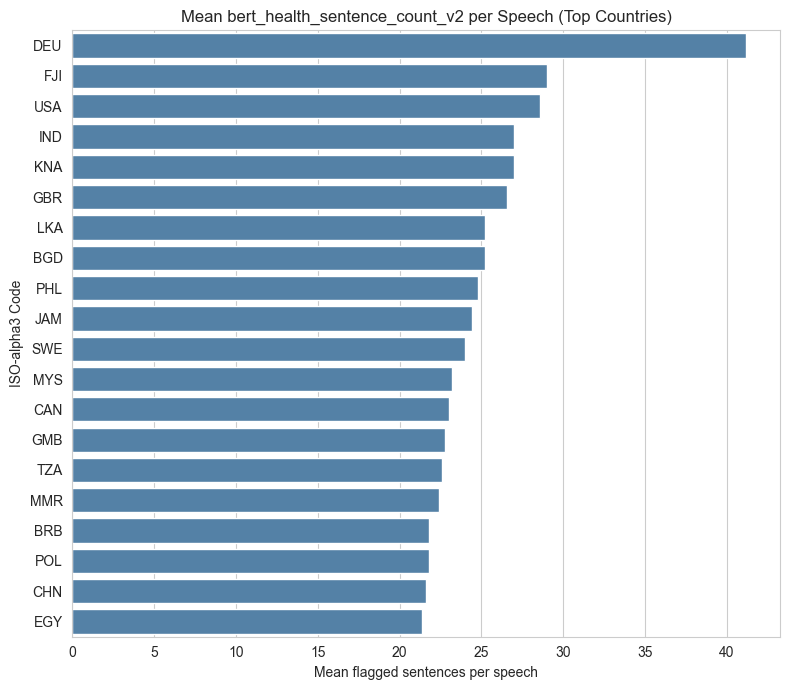

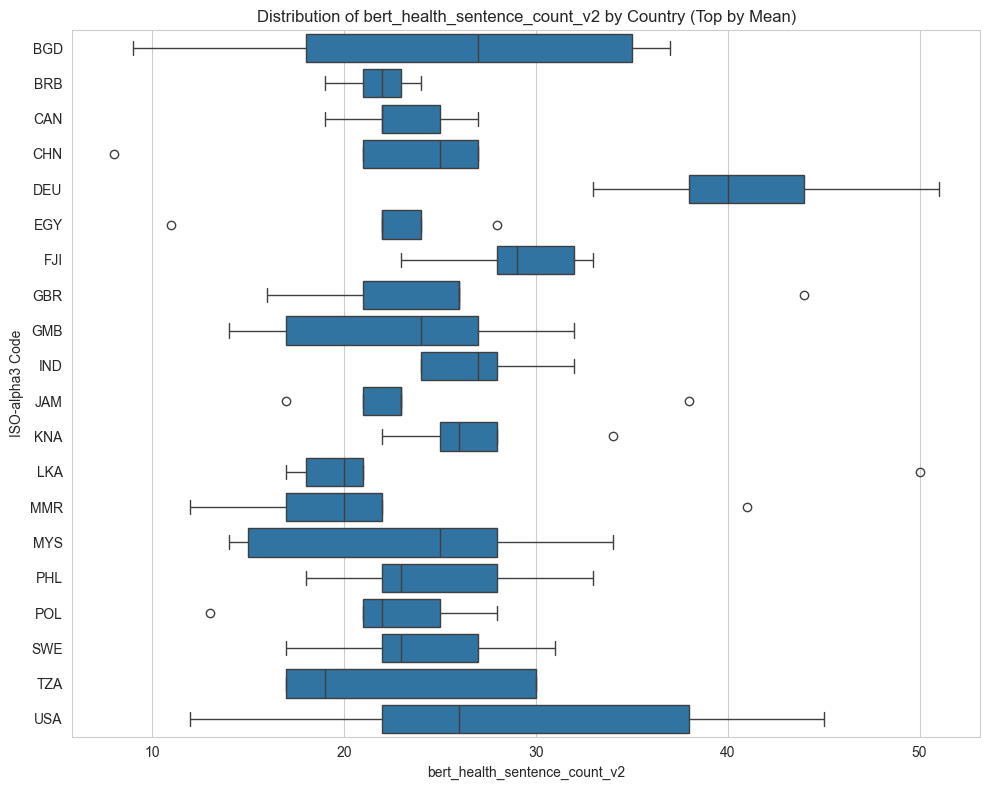

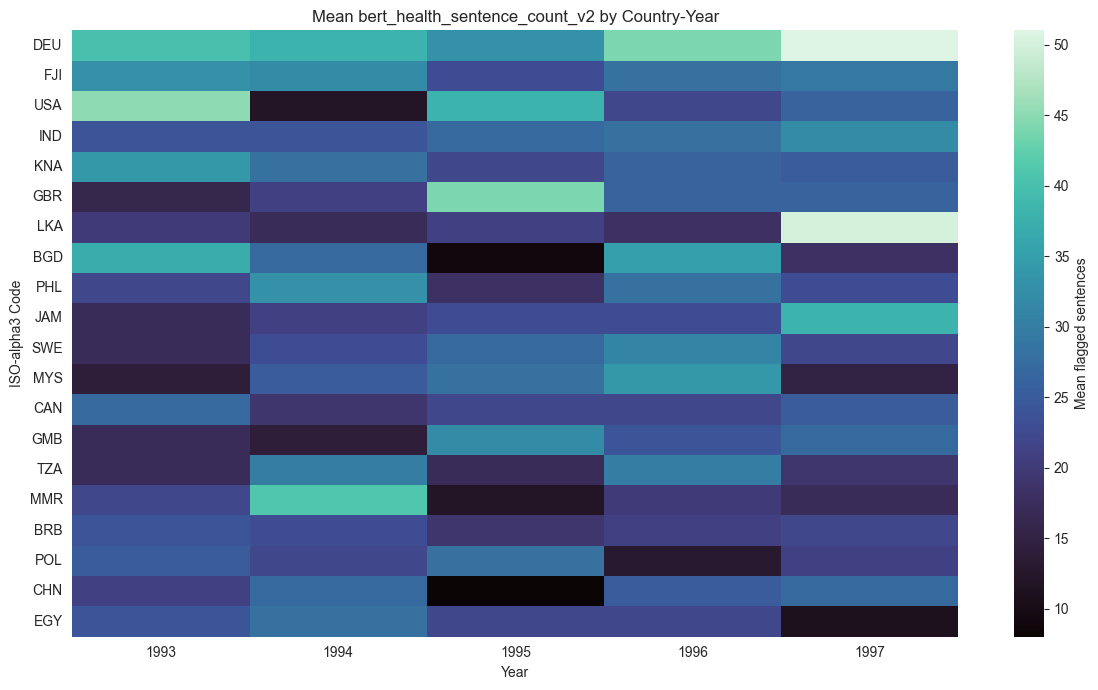

In [463]:
# Compare analyzed countries' speeches by bert_health_sentence_count_v2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preconditions
if 'per_speech_health_v2' not in globals() or per_speech_health_v2 is None or per_speech_health_v2.empty:
    raise RuntimeError('per_speech_health_v2 missing. Run the v2 build cells first.')
if 'bert_health_sentence_count_v2' not in per_speech_health_v2.columns:
    raise RuntimeError('bert_health_sentence_count_v2 not found in per_speech_health_v2.')

# Focus on the actually analyzed subset
df = per_speech_health_v2.copy()
df = df[df['bert_health_sentence_count_v2'].notna()]

# If a target country list is defined, use it
if 'TARGET_ISO_CODES_V2' in globals() and isinstance(TARGET_ISO_CODES_V2, list) and TARGET_ISO_CODES_V2:
    df = df[df['ISO-alpha3 Code'].isin(TARGET_ISO_CODES_V2)]

print(f"Analyzed speeches: {len(df)} | Countries: {df['ISO-alpha3 Code'].nunique()} | Years: {df['Year'].min()}–{df['Year'].max()}")

# Table: Top 20 speeches by bert_health_sentence_count_v2
cols = ['ISO-alpha3 Code','Year','bert_health_sentence_count_v2']
if 'Speech' in df.columns:
    cols.append('Speech')
preview = df.sort_values('bert_health_sentence_count_v2', ascending=False)[cols].head(20)
print("Top speeches by bert_health_sentence_count_v2:")
display(preview)

# Country-level summary
country_stats = (
    df.groupby('ISO-alpha3 Code')['bert_health_sentence_count_v2']
      .agg(count='count', mean='mean', sum='sum')
      .reset_index()
)

# Barplot: top countries by mean flagged sentences per speech
top_n = 20
top_mean = country_stats.sort_values('mean', ascending=False).head(min(top_n, len(country_stats)))
plt.figure(figsize=(8, max(3, 0.35*len(top_mean))))
sns.barplot(data=top_mean, y='ISO-alpha3 Code', x='mean', color='steelblue')
plt.title('Mean bert_health_sentence_count_v2 per Speech (Top Countries)')
plt.xlabel('Mean flagged sentences per speech')
plt.ylabel('ISO-alpha3 Code')
plt.tight_layout(); plt.show()

# Optional: Distribution per country (boxplot) for selected set (limit to <= 20 countries)
selected_countries = top_mean['ISO-alpha3 Code'].tolist()
box_df = df[df['ISO-alpha3 Code'].isin(selected_countries)].copy()
plt.figure(figsize=(10, max(3, 0.4*len(selected_countries))))
sns.boxplot(data=box_df, y='ISO-alpha3 Code', x='bert_health_sentence_count_v2', orient='h')
plt.title('Distribution of bert_health_sentence_count_v2 by Country (Top by Mean)')
plt.xlabel('bert_health_sentence_count_v2')
plt.ylabel('ISO-alpha3 Code')
plt.tight_layout(); plt.show()

# Optional: Heatmap by Year x Country (sum across multiple speeches if duplicates)
pivot = (
    df.pivot_table(index='ISO-alpha3 Code', columns='Year', values='bert_health_sentence_count_v2', aggfunc='mean')
      .loc[selected_countries]
)
plt.figure(figsize=(12, max(3, 0.35*len(selected_countries))))
sns.heatmap(pivot, cmap='mako', cbar_kws={'label': 'Mean flagged sentences'})
plt.title('Mean bert_health_sentence_count_v2 by Country-Year')
plt.xlabel('Year'); plt.ylabel('ISO-alpha3 Code')
plt.tight_layout(); plt.show()


Speeches: 40 | Countries: 8 | Years: 1993–1997
Counts per country:
ISO-alpha3 Code
THA    0
MEX    5
COL    5
BRA    5
CHN    5
ARG    5
PER    5
TUR    5
MYS    5
Name: count, dtype: int64


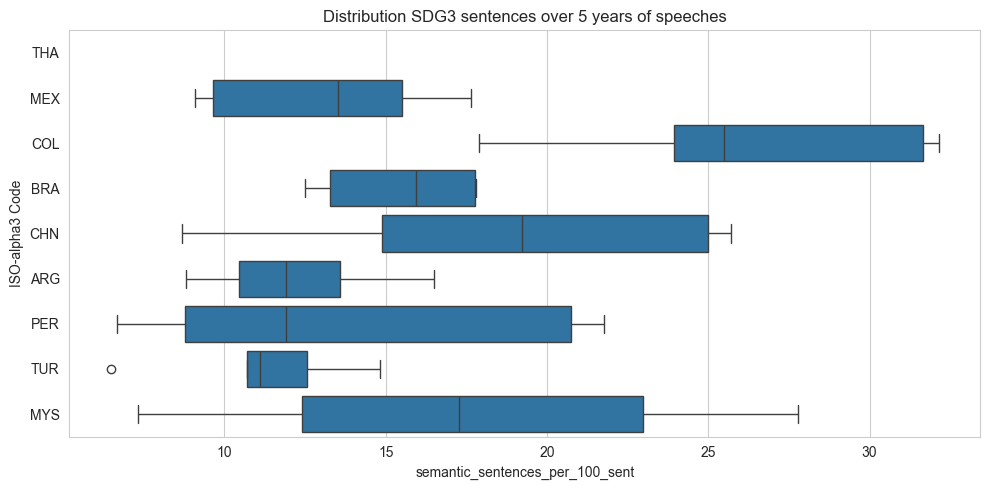

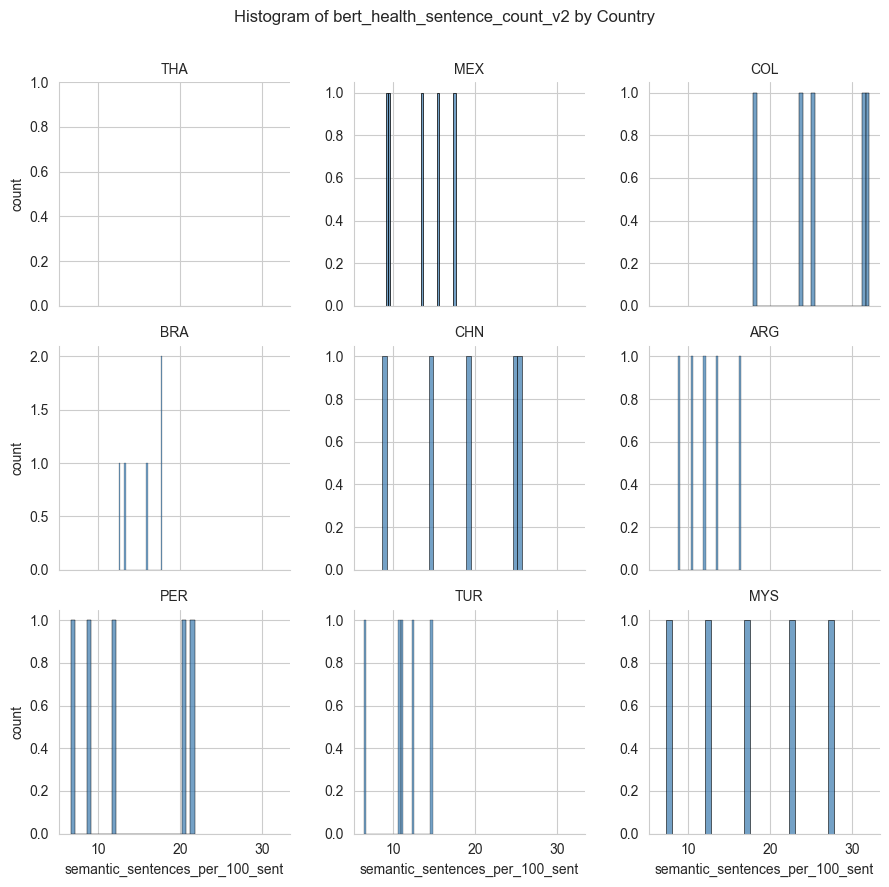

In [477]:
# Distribution of bert_health_sentence_count_v2 for selected countries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ISO_LIST = ["THA", "MEX", "COL", "BRA", "CHN", "ARG", "PER", "TUR", "MYS"]

# Preconditions
if 'per_speech_health_v2' not in globals() or per_speech_health_v2 is None or per_speech_health_v2.empty:
    raise RuntimeError('per_speech_health_v2 missing. Run the v2 build cells first.')
if 'bert_health_sentence_count_v2' not in per_speech_health_v2.columns:
    raise RuntimeError('bert_health_sentence_count_v2 not found in per_speech_health_v2.')

# Filter to ISO list, drop missing
df = per_speech_health_v2.copy()
df = df[df['ISO-alpha3 Code'].isin(ISO_LIST)]
df = df[df['bert_health_sentence_count_v2'].notna()]

print(f"Speeches: {len(df)} | Countries: {df['ISO-alpha3 Code'].nunique()} | Years: {df['Year'].min()}–{df['Year'].max()}")
print("Counts per country:")
print(df['ISO-alpha3 Code'].value_counts().reindex(ISO_LIST).fillna(0).astype(int))

# Boxplot distribution per country (horizontal)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='ISO-alpha3 Code', x='semantic_sentences_per_100_sent', order=ISO_LIST, orient='h')
plt.title('Distribution SDG3 sentences over 5 years of speeches')
plt.xlabel('semantic_sentences_per_100_sent')
plt.ylabel('ISO-alpha3 Code')
plt.tight_layout(); plt.show()

# Faceted histograms per country
g = sns.FacetGrid(
    df,
    col='ISO-alpha3 Code',
    col_wrap=3,
    sharex=True,
    sharey=False,
    col_order=ISO_LIST
)
g.map_dataframe(sns.histplot, x='semantic_sentences_per_100_sent', bins=30, color='steelblue', edgecolor='black')
g.set_axis_labels('semantic_sentences_per_100_sent', 'count')
g.set_titles(col_template='{col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Histogram of bert_health_sentence_count_v2 by Country')
plt.show()



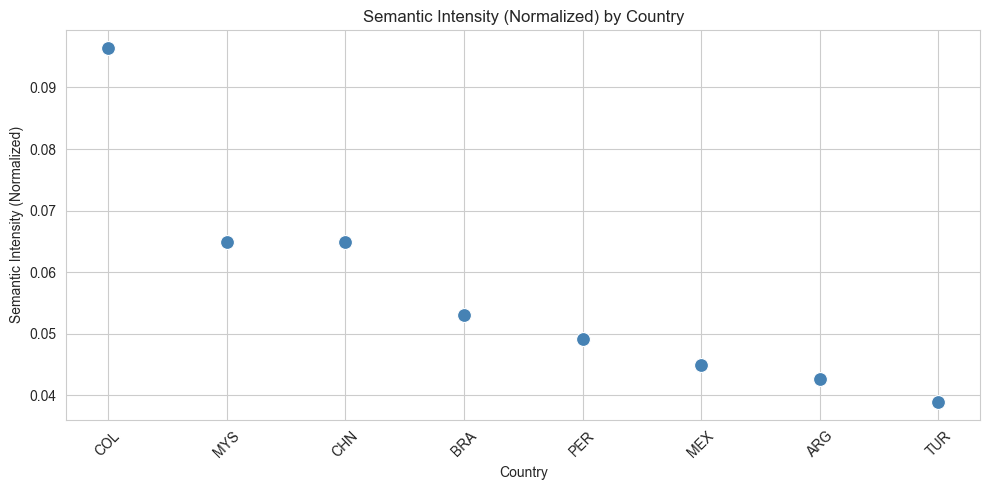

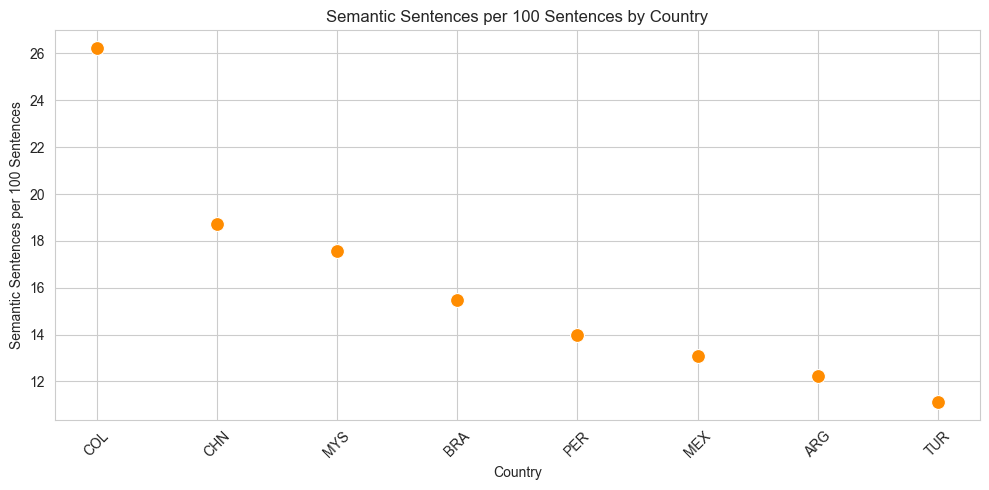

In [478]:
ISO_LIST = ["THA", "MEX", "COL", "BRA", "CHN", "ARG", "PER", "TUR", "MYS"]

# Aggregate per country (mean values) and filter to ISO_LIST
agg = (
    df.groupby("ISO-alpha3 Code")[["semantic_intensity_norm", "semantic_sentences_per_100_sent"]]
    .mean()
    .reindex(ISO_LIST)   # only keep ISO_LIST, in given order
    .dropna()            # drop any missing
)

# === Plot 1: semantic_intensity_norm (descending) ===
plt.figure(figsize=(10, 5))
order_intensity = agg["semantic_intensity_norm"].sort_values(ascending=False).index
sns.scatterplot(
    data=agg.loc[order_intensity].reset_index(),
    x="ISO-alpha3 Code",
    y="semantic_intensity_norm",
    s=100,
    color="steelblue"
)
plt.title("Semantic Intensity (Normalized) by Country")
plt.xlabel("Country")
plt.ylabel("Semantic Intensity (Normalized)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Plot 2: semantic_sentences_per_100_sent (descending) ===
plt.figure(figsize=(10, 5))
order_sentences = agg["semantic_sentences_per_100_sent"].sort_values(ascending=False).index
sns.scatterplot(
    data=agg.loc[order_sentences].reset_index(),
    x="ISO-alpha3 Code",
    y="semantic_sentences_per_100_sent",
    s=100,
    color="darkorange"
)
plt.title("Semantic Sentences per 100 Sentences by Country")
plt.xlabel("Country")
plt.ylabel("Semantic Sentences per 100 Sentences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


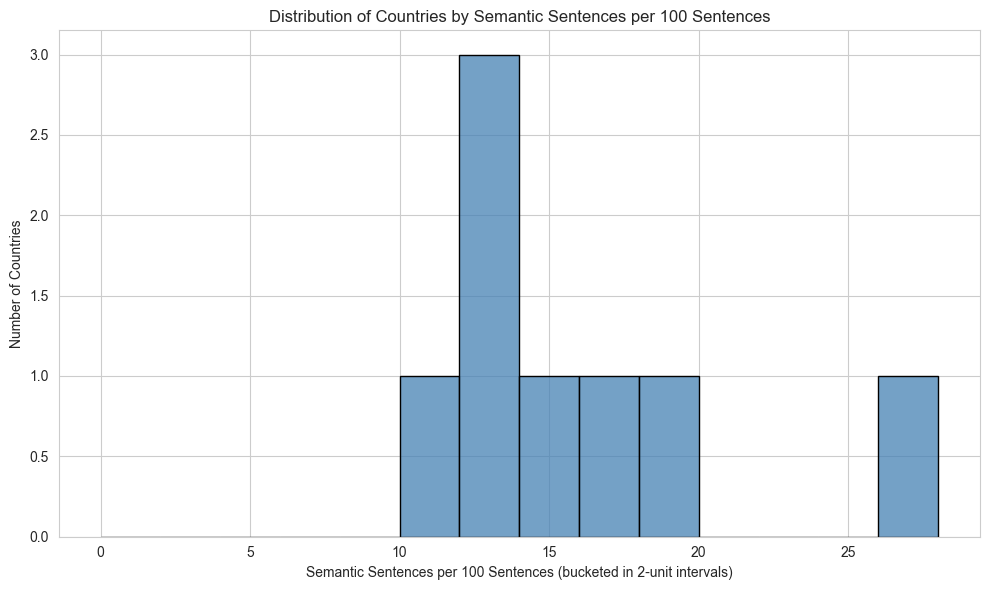

In [479]:
# Aggregate mean per country
agg = (
    df.groupby("ISO-alpha3 Code")["semantic_sentences_per_100_sent"]
    .mean()
    .dropna()
)

# Plot histogram with bin width = 2
plt.figure(figsize=(10, 6))
sns.histplot(
    agg,
    bins=range(0, int(agg.max()) + 3, 2),  # step of 2 units
    color="steelblue",
    edgecolor="black"
)
plt.title("Distribution of Countries by Semantic Sentences per 100 Sentences")
plt.xlabel("Semantic Sentences per 100 Sentences (bucketed in 2-unit intervals)")
plt.ylabel("Number of Countries")
plt.tight_layout()
plt.show()


In [498]:
import plotly.express as px

# Aggregate to country-level (mean in case multiple speeches per country in 1995)
df_country = (
    df_plot.groupby(["ISO-alpha3 Code", "Country or Area"], as_index=False)
    ["semantic_sentences_per_100_sent"].mean()
)

fig = px.histogram(
    df_country,
    x="semantic_sentences_per_100_sent",
    nbins=int((df_country["semantic_sentences_per_100_sent"].max() -
               df_country["semantic_sentences_per_100_sent"].min())),
    title="Countries at each rate SDG3 sentences out of 100 sentences",
    labels={"semantic_sentences_per_100_sent": "Semantic Sentences per 100 Sentences"},
)

fig.update_traces(marker_color="steelblue", marker_line_color="black", marker_line_width=1)
fig.update_layout(
    bargap=0.05,
    xaxis_title="Semantic Sentences per 100 Sentences (1-unit bins)",
    yaxis_title="Number of Countries"
)

fig.show()


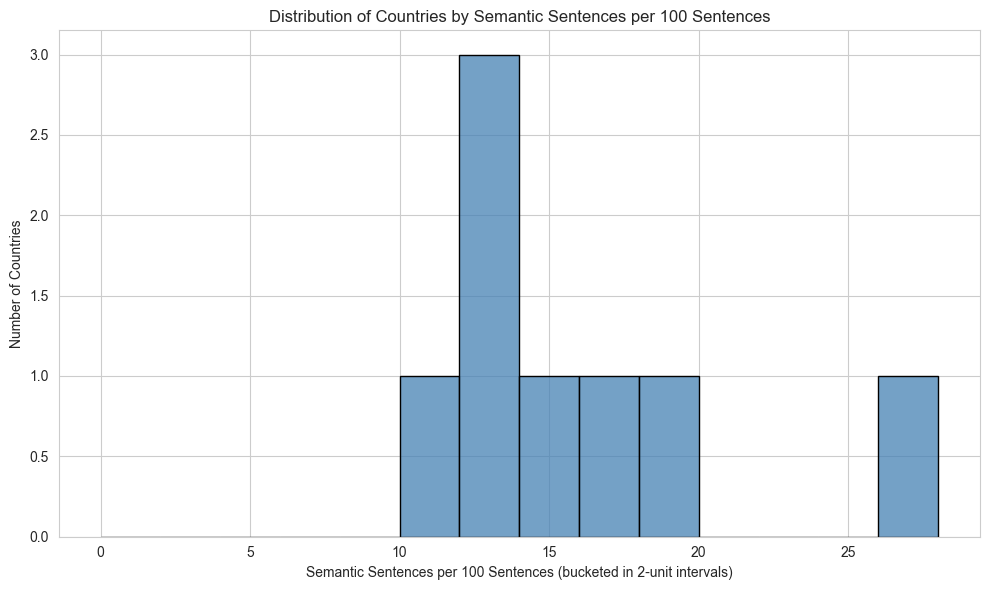

In [499]:
# Aggregate mean per country
agg = (
    df.groupby("ISO-alpha3 Code")["semantic_sentences_per_100_sent"]
    .mean()
    .dropna()
)

# Plot histogram with bin width = 2
plt.figure(figsize=(10, 6))
sns.histplot(
    agg,
    bins=range(0, int(agg.max()) + 3, 2),  # step of 2 units
    color="steelblue",
    edgecolor="black"
)
plt.title("Distribution of Countries by Semantic Sentences per 100 Sentences")
plt.xlabel("Semantic Sentences per 100 Sentences (bucketed in 2-unit intervals)")
plt.ylabel("Number of Countries")
plt.tight_layout()
plt.show()


In [500]:

# Rename Entity_income_groups to income_group
income_groups = income_groups.rename(columns={
    "World Bank's income classification": 'income_group'
})
income_groups.head()

,Entity,Code,Year,income_group
0,Afghanistan,AFG,1987,Low-income countries
1,Afghanistan,AFG,1988,Low-income countries
2,Afghanistan,AFG,1989,Low-income countries
3,Afghanistan,AFG,1990,Low-income countries
4,Afghanistan,AFG,1991,Low-income countries


In [501]:
# Copy speech-level data
df_plot = per_speech_health_v2.copy()

# Filter income_groups to 1995 only
income_1995 = income_groups.loc[income_groups["Year"] == 1995, ["Code", "income_group"]]

# Merge on ISO3
df_plot = df_plot.merge(
    income_1995,
    left_on="ISO-alpha3 Code",   # from per_speech_health_v2
    right_on="Code",             # from income_groups
    how="left"
)


## boxplot

In [527]:
import plotly.express as px

# Copy speech-level data
df_plot = per_speech_health_v2.copy()

# Filter income_groups to 1995 only
income_1995 = income_groups.loc[income_groups["Year"] == 1995, ["Code", "income_group"]]

# Merge
df_plot = df_plot.merge(
    income_1995.rename(columns={"Code": "ISO-alpha3 Code"}), 
    on="ISO-alpha3 Code", 
    how="left"
)

# --- Clean up column names ---
# Keep only one column called 'income_group'
if "income_group_y" in df_plot.columns:
    df_plot = df_plot.rename(columns={"income_group_y": "income_group"})
if "income_group_x" in df_plot.columns:
    df_plot = df_plot.drop(columns=["income_group_x"])

# Drop missing rows
df_plot = df_plot.dropna(subset=["income_group", "semantic_sentences_per_100_sent"])

# Plotly boxplot
fig = px.box(
    df_plot,
    x="income_group",
    y="semantic_sentences_per_100_sent",
    category_orders={
        "income_group": ["Low income", "Lower middle income", "Upper middle income", "High income"]
    },
    color="income_group",
    title="Distrib. SDG3 Sent. / 100 Sent. by Income Group (@1995), Speeches '93-'97",
    labels={
        "income_group": "Income Group (in 1995)",
        "semantic_sentences_per_100_sent": "Semantic Sentences per 100 Sentences"
    }
)
# After creating fig with px.box
fig.update_traces(marker=dict(line=dict(color="black", width=1)))
fig.show()



In [528]:
print(
    df_plot.groupby("income_group")["semantic_sentences_per_100_sent"].count()
)

income_group
High-income countries            135
Low-income countries             155
Lower-middle-income countries    170
Upper-middle-income countries     70
Name: semantic_sentences_per_100_sent, dtype: int64


In [529]:
from statsmodels.stats.multitest import multipletests
import itertools
import scipy.stats as stats


pairs = list(itertools.combinations(["Low income", "Lower middle income", "Upper middle income", "High income"], 2))
p_vals = []

for g1, g2 in pairs:
    data1 = df_plot.loc[df_plot["income_group"] == g1, "semantic_sentences_per_100_sent"].dropna()
    data2 = df_plot.loc[df_plot["income_group"] == g2, "semantic_sentences_per_100_sent"].dropna()
    _, p_val = stats.ttest_ind(data1, data2, equal_var=True)
    p_vals.append(p_val)

# Adjust p-values
reject, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
for (g1, g2), p_val, p_corr, rej in zip(pairs, p_vals, p_adj, reject):
    print(f"{g1} vs {g2}: raw p={p_val:.4e}, corrected p={p_corr:.4e}, significant={rej}")


Low income vs Lower middle income: raw p=nan, corrected p=nan, significant=False
Low income vs Upper middle income: raw p=nan, corrected p=nan, significant=False
Low income vs High income: raw p=nan, corrected p=nan, significant=False
Lower middle income vs Upper middle income: raw p=nan, corrected p=nan, significant=False
Lower middle income vs High income: raw p=nan, corrected p=nan, significant=False
Upper middle income vs High income: raw p=nan, corrected p=nan, significant=False


c:\Users\mariu\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.



In [530]:
from scipy.stats import f_oneway, kruskal

# Collect groups
groups = []
labels = []
for g, vals in df_plot.groupby("income_group")["semantic_sentences_per_100_sent"]:
    groups.append(vals.dropna().values)
    labels.append(g)

# ANOVA
f_stat, p_val = f_oneway(*groups)
print("One-way ANOVA:", f"F = {f_stat:.4f}, p = {p_val:.4e}")

# Kruskal-Wallis (non-parametric)
h_stat, p_val_kw = kruskal(*groups)
print("Kruskal-Wallis:", f"H = {h_stat:.4f}, p = {p_val_kw:.4e}")


One-way ANOVA: F = 1.3310, p = 2.6344e-01
Kruskal-Wallis: H = 4.5868, p = 2.0468e-01


In [531]:
bert_health_example_sentences_v2

NameError: name 'bert_health_example_sentences_v2' is not defined

## lets delve deeper into the middle 2 income groups. to see the outliers too

In [ ]:
import plotly.express as px

middle_groups = ["Lower-middle-income countries", "Upper-middle-income countries"]
df_middle = df_plot[df_plot["income_group"].isin(middle_groups)].copy()


In [ ]:
import plotly.express as px

middle_groups = ["Lower-middle-income countries", "Upper-middle-income countries"]
df_middle = df_plot[df_plot["income_group"].isin(middle_groups)].copy()

fig = px.box(
    df_middle,
    x="income_group",
    y="semantic_sentences_per_100_sent",
    color="income_group",
    points="all",  # show all observations
    hover_data=["Country or Area", "ISO-alpha3 Code"],  # <-- add country info
    title="Semantic Sentences per 100 Sentences (Middle Income Groups, 1995)"
)
fig.update_layout(
    xaxis_title="Income Group (1995)",
    yaxis_title="Semantic Sentences per 100 Sentences",
    boxmode="group"
)
fig.show()


In [ ]:
fig2 = px.strip(
    df_middle,
    x="income_group",
    y="semantic_sentences_per_100_sent",
    color="income_group",
    hover_data=["Country or Area", "ISO-alpha3 Code"],  # <-- add country info
    title="Distribution with Outliers Highlighted (Middle Income Groups, 1995)",
    stripmode="overlay"  # overlay points instead of splitting
)
fig2.update_layout(
    xaxis_title="Income Group (1995)",
    yaxis_title="Semantic Sentences per 100 Sentences"
)
fig2.show()


## Stop

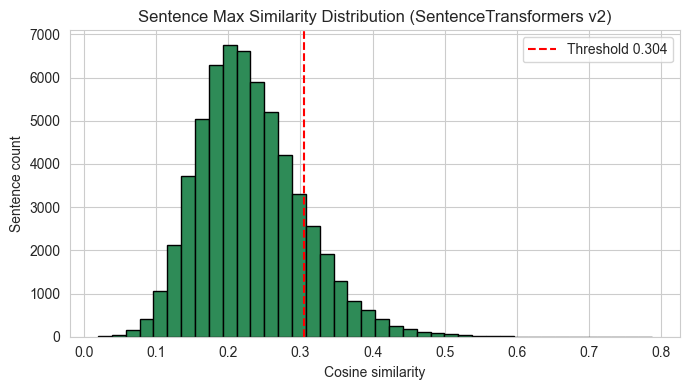

ValueError: Could not interpret value `mentions_per_1k_tokens` for `x`. An entry with this name does not appear in `data`.

<Figure size 700x500 with 0 Axes>

In [ ]:
# Visualization: similarity histogram and scatter of normalized intensities (v2)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Histogram
sim_arr_v2 = np.array(all_sentence_sims_v2)
if sim_arr_v2.size > 0:
    plt.figure(figsize=(7,4))
    plt.hist(sim_arr_v2, bins=40, color='seagreen', edgecolor='black')
    plt.axvline(SIM_THRESHOLD_V2, color='red', linestyle='--', label=f'Threshold {SIM_THRESHOLD_V2:.3f}')
    plt.title('Sentence Max Similarity Distribution (SentenceTransformers v2)')
    plt.xlabel('Cosine similarity')
    plt.ylabel('Sentence count')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print('No sentence similarities collected for v2.')

# Scatter: lexical vs semantic normalized intensities
if 'per_speech_health_v2' in globals():
    df = per_speech_health_v2.copy()

    #lex_col = 'mentions_per_1k_tokens'
    sem_col = 'semantic_sentences_per_100_sent'


    if df[sem_col].notna().sum() < 5:
        sem_col = 'bert_health_sentence_count_v2'
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df, x=lex_col, y=sem_col, hue='overlap_category', alpha=0.75, edgecolor='none')
    plt.title('Speech-Level Topic Intensity (Lexical vs Semantic, v2)')
    #plt.xlabel(f'Lexical ({lex_col})')
    plt.ylabel(f'Semantic ({sem_col})')
    plt.legend(title='Overlap', bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout(); plt.show()

    # Top speeches by semantic_intensity_norm
    top_sem = df.sort_values('semantic_intensity_norm', ascending=False).head(10)
    print('Top speeches by semantic_intensity_norm (v2):')
    display(top_sem[['ISO-alpha3 Code','Year','bert_health_sentence_count_v2','semantic_intensity_norm']])
else:
    print('per_speech_health_v2 not found.')
